In [3]:
# -*- coding: utf-8 -*-
# Packages -----------------
import os
import sys
import shutil
import warnings
import datetime

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pedophysics import predict, Soil
import FDEM
from FDEM import Initialize

from scipy import constants
from utils.spatial_utils import utm_to_epsg, get_coincident
from utils.profile_utils import merge_layers, plot_profile, check_uniformity_and_interpolate

from PyPDF2 import PdfMerger

sys.path.insert(0,'../src/') # this add the emagpy/src directory to the PATH
from emagpy import Problem
pd.set_option('display.max_columns', None)

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# User input
config = {}

only_samples = False

s_site = 'P'; # P = Proefhoeve; M = Middelkerke
# Define input datatype and source folder
datafolder = 'data' # data folder
em_intype = 'rec'   # 'rec' = rECa transect; 'lin' = LIN ECa transect; 
                    # 'survey' = rEC full survey

# Sensor settings
config['instrument_code'] = 'Dualem-421S' # instrument code
config['instrument_height'] = 0.165     # instrument height
config['instrument_orientation'] = 'HCP'    # instrument orientation

# Remove coils for inversion?
config['remove_coil'] = True    # set to True if you want to remove coils in the inversion process
config['coil_n'] = [0, 1]    # indexes of coils to remove (cf. emagpy indexing)
                            # for Proefhoeve, coils 0 (HCP05) and 1 (PRP06) are best
                            # removed, for Middelkerke coils 4 (HCP4.0) and 5 (PRP4.1)

# Inversion parameters
config['fs_emp'] = 'FSeq' #'CS', 'FSlin' or 'FSeq'
config['opt_method'] = 'L-BFGS-B'  # mMinimize = ['L-BFGS-B','TNC','CG','Nelder-Mead'] --> https://docs.scipy.org/doc/scipy/reference/optimize.html 
                                # mMCMC = ['ROPE','DREAM', 'MCMC'] # ??? 'SCEUA' ??? --> https://spotpy.readthedocs.io/en/latest/ 
                                # mOther = ['ANN','Gauss-Newton','GPS'] (ANN requires tensorflow)
config['constrain']=True
config['regularization'] = 'l2'
config['alpha'] = 0.07

# Reference profile for starting model (conductivity values)
config['start_avg'] = True     # take average of input resistivity profiles per layer as starting model
                                # if false, reference profile is taken as starting model

config['reference_profile'] = 15 # ID of ERT (conductivity) profile to be used 
                                 #  to generate starting model
                                 # For proefhoeve nr 15 is used, for middelkerke 65

# Define the interfaces depths between layers for starting model and inversion
#           (number of layers = len(config['interface'])+1)
config['n_int'] = True # if True custom interfaces are defined (via config['interface']), 
                        # otherwise reference profile interfaces are used
config['interface'] = [0.3, 
                       0.6, 
                       1.0,
                       2.0
                        ] # depths to custom model interfaces
# Inversion constraining
# if constrained inversion is used, you can set custom EC bounds (and other params)
'''
    config['bounds'] is the 'bnds' used in emagpy constraining
    if you fix 2 interface and fit 3 layer EC:
    [(layer1_ec_min, layer1_ec_max), 
    (layer2_ec_min, layer2_ec_max), 
    (layer3_ec_min, layer3_ec_max)]

    If you fit 2 interfaces and fit 3 layer EC:
    [(int1_min, int1_max), 
    (int2_min, int2_max), 
    (layer1_ec_min, layer1_ec_max), 
    (layer2_ec_min, layer2_ec_max), 
    (layer3_ec_min, layer3_ec_max)]

    autobounds MDK:[(22.877321099166068, 83.29767890083818), 
    (50.6150000000018, 381.79940055200086), 
    (75.5445000000012, 819.2347232074701), 
    (124.346000000001, 1108.1655185859772), 
    (188.4700000000009, 1025.8167426267287)]   
'''

config['custom_bounds'] = True
config['bounds'] = [(10, 55), (20, 120), (50, 335), (50, 250), (10, 50)]

# !!! ---

# [  6.  43.]
#  [ 27. 183.]
#  [ 36. 307.]
#  [ 63. 335.]
#  [ 47. 337.]
#  [ 82. 224.]
#  [ 53. 103.]
#  [ 39.  73.]

if config['n_int'] == False and config['custom_bounds']:
    print('Check if bounds and number of interfaces match')

# Geographic operations (if needed)
c_transform = False
c_utmzone = '31N'
c_target_cs = 'EPSG:31370'

# remove profiles at transect edges
config['n_omit'] =  10 # number of profiles to exclude from the start
                       # and end of the ERT transect (none = 0) for the inversion
                       # a total of 60 profiles is available, for middelkerke
                       # 120 profiles are available  

# ---------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------- #

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if config['instrument_code'] == 'Dualem-21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'
inv_folder = os.path.join(datafolder, 'inverted')
os.makedirs(inv_folder, exist_ok=True) 
cal_folder = os.path.join(datafolder, 'calibrated')
ert_file = os.path.join(datafolder, f'{profile_prefix}-profiles-ERT.csv')
em_rec = os.path.join(cal_folder, f'{emfile_prefix}_transect_calibrated_rECa.csv')
em_lin = os.path.join(cal_folder,f'{emfile_prefix}_transect_calibrated_LIN.csv')
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_calibrated_rECa.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samps.csv')

if em_intype == 'rec':
    infile = em_rec
elif em_intype == 'survey':
    infile = em_survey
else:
    infile = em_lin

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                    instrument_orientation=config['instrument_orientation']
                                    )

# Column names for emapgy input
emp_21HS = [f"HCP0.5f9000{config['instrument_height']}", 'PRP0.6f9000h0.165', 'HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165',
            'HCP0.5f9000h0.165_inph', 'PRP0.6f9000h0.165_inph', 'HCP1.0f9000h0.165_inph',
            'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph'
            ]

emp_421S = ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165', 
            'HCP1.0f9000h0.165_inph', 'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph',
            'HCP4.0f9000h0.165_inph', 'PRP4.1f9000h0.165_inph',
            ]

if config['opt_method'] == 'Gauss-Newton':
    config['regularization'] = 'l2'

# Datetime for filename
now = (datetime.datetime.now())
now = now.strftime("%y%m%d_%H%M")

# 1.0 Data import and structuring into dataframe
ert_p = pd.read_csv(ert_file, sep=',', header=0)
em_rec = pd.read_csv(em_rec, sep=',', header=0)
em_lin = pd.read_csv(em_lin, sep=',', header=0)
em_survey = pd.read_csv(em_survey, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)

print('em_survey', em_survey)

if c_transform:
    # Create a new filename with the target EPSG code
    em_rec = utm_to_epsg(em_rec, c_utmzone, target_epsg=c_target_cs)
    em_lin = utm_to_epsg(em_lin, c_utmzone, target_epsg=c_target_cs)
    em_survey = utm_to_epsg(em_survey, c_utmzone, target_epsg=c_target_cs)

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                        instrument_orientation=config['instrument_orientation']
                                        )
em_samples = get_coincident(em_survey,samples)
print('em_samples.head()', em_samples.head())

# ---------------------------------------------------------------------------- #
# Get ERT profiles
# ---------------- #
# Group the data by profile ID for efficient access to each profile
profiles = ert_p.groupby('ID')

# Exclude the first and last n_omit profiles
unique_ids = ert_p['ID'].unique()

if config['n_omit'] == 0:
    ert_final = ert_p.copy()
else:
    if config['n_omit']*2 >= len(unique_ids):
        warnings.warn('!!! You removed all profiles !!! Change value for config[n_omit]')
        raise KeyboardInterrupt
    else:
        selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
        ert_p = ert_p.loc[ert_p['ID'].isin(selected_ids)]
        ert_final = ert_p.copy()

dataset_name = 'Resistivity(ohm.m)'  # The variable of interest

# convert resistivity to conductivity and modify column names

ert_final[dataset_name] = (1/ert_final[dataset_name])
dc_corr = ert_final.copy()
dc_corr[dataset_name] = predict.BulkEC(Soil(
                                                frequency_ec = 9000,
                                                bulk_ec_dc = dc_corr[dataset_name].values
                                                ))

ert_final.loc[:, dataset_name] = ert_final[dataset_name]*1000
dc_corr.loc[:,dataset_name] = dc_corr[dataset_name]*1000
ert_final = ert_final.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})
dc_corr = dc_corr.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})

# ------------------------------------------------------------------------------

# Columns containing the resistivity data
data_column = ['EC(mS/m)']
# Assuming ert_final is your DataFrame with profile data
all_profiles_df, uniform_intervals = check_uniformity_and_interpolate(
    dc_corr, 'ID', 'Z', *data_column
)

dataset_name = 'EC(mS/m)'  # The variable of interest
# #Plotting combined profiles
# plot_combined_profiles(ert_final, all_profiles_df, 
#                        data_column, compare_name = data_column)
print('em_rec', em_rec)


em_survey                    x              y          z         t      HCP1QP  \
0      107769.789686  183238.107498  28.550000  32700.12  163.602188   
1      107769.789686  183238.107565  28.550000  32700.32  163.222325   
2      107769.789687  183238.107644  28.550000  32700.52  163.982113   
3      107769.789687  183238.107737  28.550000  32700.72  163.792143   
4      107769.789706  183238.109983  28.550000  32700.92  163.222325   
...              ...            ...        ...       ...         ...   
13574  107801.964510  183286.619216  27.779549  35666.96   68.996469   
13575  107801.905626  183286.602620  27.779549  35667.15   69.001096   
13576  107801.840524  183286.585058  27.779549  35667.35   69.183625   
13577  107801.840220  183286.584977  27.779549  35667.55   69.007111   
13578  107801.777620  183286.568815  27.779549  35667.95   69.558001   

           PRP1QP      HCP2QP      PRP2QP      HCP4QP      PRP4QP    HCP1IP  \
0      112.926475  170.078176  150.400765  108

<Figure size 1000x800 with 0 Axes>

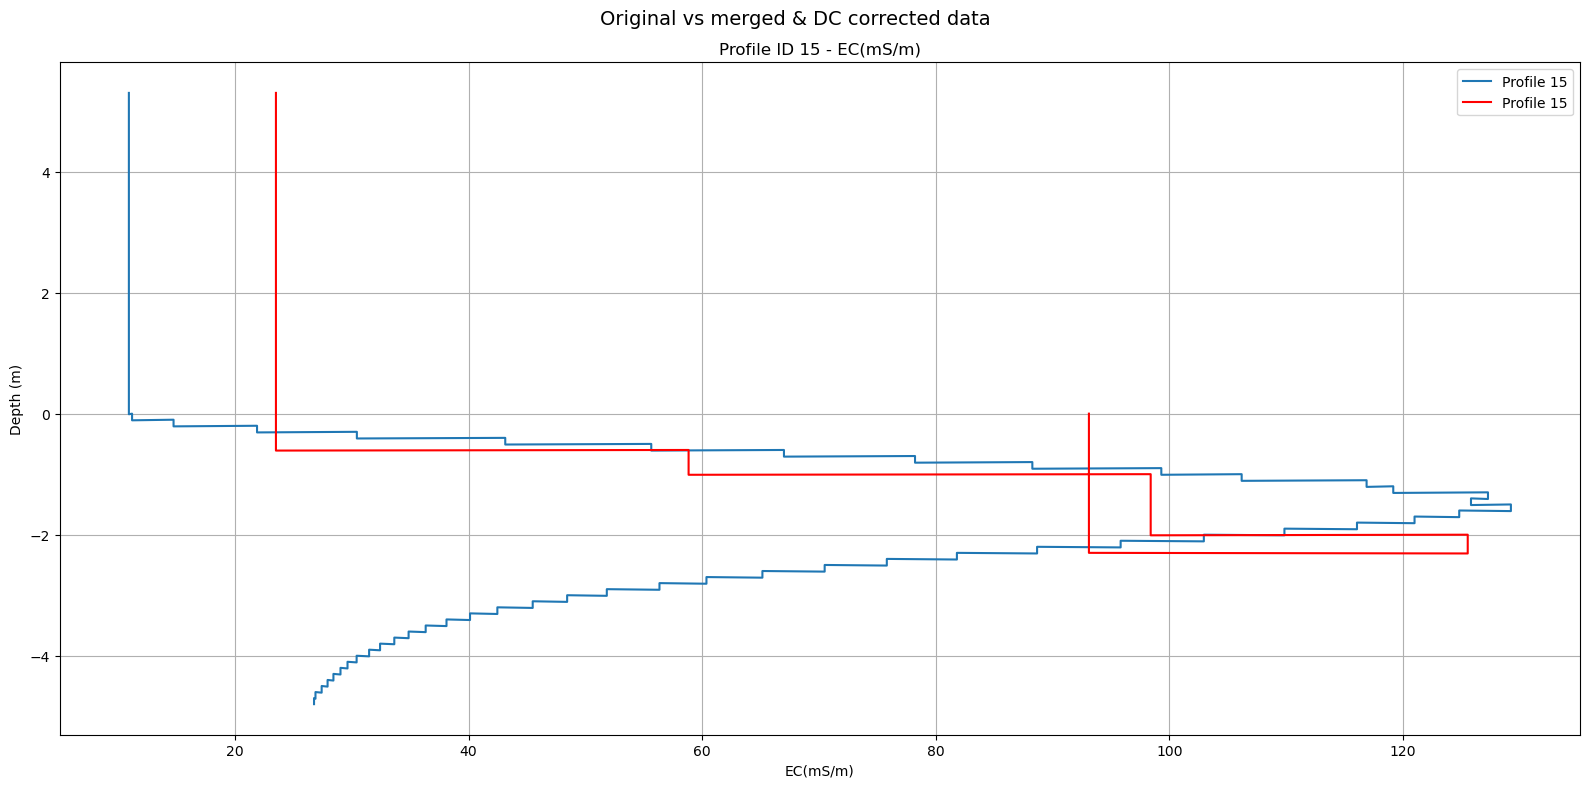

In [5]:
# config['reference_profile'] = 11

if config['reference_profile'] not in all_profiles_df['ID'].unique():
    warnings.warn("Warning: the reference profile ID does not exist. Provide correct profile ID.")
    raise KeyboardInterrupt
else:
    profile_id = config['reference_profile']

# Create new layer configuration for prior model based on ERT data
if config['n_int']:
    new_int = config['interface']
    merged_df = merge_layers(all_profiles_df, new_int,'EC(mS/m)')
else:
    merged_df = all_profiles_df
comparedf = merged_df.copy()

# Plot original and (merged and) DC corrected reference profile
if config['n_int']:
    plot_title = 'Original vs merged & DC corrected data'
    first_in = .1
else: 
    plot_title = 'Original vs DC corrected data'
    first_in = .0
ert_eval = ert_final.copy()
ert_eval['Z'] = ert_eval['Z'].values + first_in

plot_profile(ert_eval, profile_id, dataset_name, compare=True, compare_df = comparedf, compare_name = 'EC(mS/m)', block=True, plot_title=plot_title)

# Get prior model info
def generate_forward_model_inputs(df, profile_id_col, depth_col, res_col):
    models = {}  # Dictionary to store models by profile ID

    for profile_id, group in df.groupby(profile_id_col):
        # Assuming uniform interval after previous interpolation
        uniform_interval = abs(group[depth_col].diff().iloc[1])
        #print(uniform_interval)
        num_layers = len(group[res_col])
                # Thicknesses are the intervals between depths, except for the last value which does not define a new layer
        thick = np.full(num_layers - 1, uniform_interval)
        thick[0] = 2 * thick[0]
        # Conductivity is the inverse of resistivity
        con = group[res_col].values/1000
        # Permittivity is the epsilon_0 for all layers
        perm = np.full(num_layers, constants.epsilon_0)
        sus = np.zeros(num_layers)
        # Create model instance
        M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])
        
        # Store the model instance in the dictionary with the profile ID as the key
        models[profile_id] = M
    return models

models = generate_forward_model_inputs(merged_df, 'ID', 'Z', 'EC(mS/m)')

conductivities [ 93.117  125.55    98.4055  58.842   23.511 ]


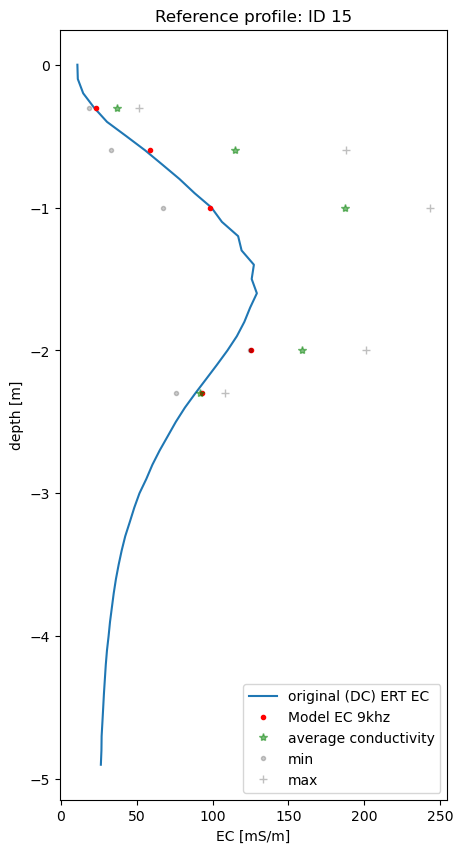

In [6]:
# 
# -------------------------------------------------------------------- #

# 
profile_data = merged_df[merged_df['ID'] == profile_id].copy()
res_col = 'EC(mS/m)'
depth = 'Z'
max_ert_depth = ert_final['Z'].abs().max()

# 
# ------------------------------------------------------------------------------

# A. Test run on the reference profile (config['reference_profile'])
#       and plot the results

if not config['n_int']:
    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)
    if first_lay == 0:
        profile_data[depth]=profile_data[depth] +second_lay
    else:
        profile_data[depth]=profile_data[depth] +first_lay
    thick = -profile_data[depth].iloc[1:].values
    #thick = -profile_data[depth].values
else:
    thick = -profile_data[depth].values

con = profile_data[res_col].values/1000
ref_len = len(con)
num_layers = len(con)
perm = np.full(num_layers, constants.epsilon_0)
sus = np.zeros(num_layers)

# # Create model instance
M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])

# ----------------------------------------------------------------------

dataset_name = 'EC(mS/m)'
layers_interfaces = np.cumsum(models[profile_id].thick)
layers_interfaces = np.insert(layers_interfaces, 0, 0)
profile_data = ert_final[ert_final['ID'] == profile_id]

fig, axr = plt.subplots(figsize=(5, 10))
axr.set_xlabel('EC [mS/m]')
axr.set_ylabel('depth [m]')
axr.plot((profile_data[dataset_name]),profile_data['Z'], label='original (DC) ERT EC',)
if not config['n_int']: 
    axr.plot(con[:-1]*1000,-thick, '.', label='Model EC 9khz',color = 'red')
else:
    axr.plot(con*1000,-thick, '.', label='Model EC 9khz',color = 'red')
axr.set_title(f'Reference profile: ID {profile_id}')

conductivities = con*1000
print('conductivities', conductivities)

ec_cols_ref = []
if 'end' in config['interface']:
    config['interface'].remove('end')
# Get conductivity stats for bounds
if config['n_int']:
    if 'end' in ec_cols_ref:
        ec_cols_ref.remove('end')
    ec_cols_ref = config['interface']
    ec_cols_ref.append('end')
    mod_layers = thick[1:]
else:
    if len(conductivities) == len(thick):
        mod_layers = thick[1:]
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    elif len(conductivities) == (len(thick)+1):
        mod_layers = thick
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    else:
        raise ValueError(f"Check length of conductivities ({len(conductivities)}) and layers ({len(thick)}) arrays!!")
    
    ec_cols_ref = np.round(layers_interfaces,decimals=1).tolist()
ec_df = pd.DataFrame(columns=ec_cols_ref)

# 
for i in merged_df['ID'].unique(): 
    profile_data = merged_df[merged_df['ID'] == i].copy()
    if not config['n_int']:
        if abs(profile_data.iloc[0]['Z']) > max((list(map(abs, ec_cols_ref)))):
            #print(f'removed {profile_data.iloc[0]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[0].name)
        elif abs(profile_data.iloc[-1]['Z']) < 0.1:
            #print(f'removed {profile_data.iloc[-1]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[-1].name)
    res_col = 'EC(mS/m)'
    depth = 'Z' 
    con_m = profile_data[res_col].values
    layers_interfaces = np.cumsum(models[i].thick)
    layers_interfaces = np.insert(layers_interfaces, 0, 0)
    num_layers = len(con)
    perm = np.full(num_layers, constants.epsilon_0)
    sus = np.zeros(num_layers)

    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)

    if not config['n_int']:
        first_lay = profile_data[depth].iloc[-1].round(decimals=1)
        second_lay = profile_data[depth].iloc[-2].round(decimals=1)
        if first_lay == 0:
            profile_data[depth]=profile_data[depth] +second_lay
        else:
            profile_data[depth]=profile_data[depth] +first_lay
        thick = -profile_data[depth].iloc[1:].values
    else:
        thick = -profile_data[depth].values

    ec_df = pd.concat([ec_df, pd.DataFrame([np.flip(con_m)], columns=ec_cols_ref)])

    # if a == 1:
    #     fig, ax = plt.subplots(figsize=(5, 10))
    #     ax.set_xlabel('EC [mS/m]')
    #     ax.set_ylabel('depth [m]')
    #     profile_data = ert_final[ert_final['ID'] == i]
    #     ax.plot((profile_data[dataset_name]),profile_data['z'], label='original (DC) ERT EC',)
    #     if not config['n_int']:
    #         ax.plot(con[:-1],-thick, '.', label='Model EC 9khz',color = 'red')
    #     else:
    #         ax.plot(con,-thick, '.', label='Model EC 9khz',color = 'red')
    #     ax.set_title(f'profile {i}')
    #     ax.legend()
    #     a = a +1

ec_df.reset_index(drop=True, inplace=True)

ec_stats = ec_df.describe().loc[['min', 'max', 'std', '50%', 'mean']]
ec_stats.rename(index={'50%': 'median'}, inplace=True)
ec_stats.loc['min_sd'] = ec_stats.loc['min'] - 2 * ec_stats.loc['std']
ec_stats.loc['max_sd'] = ec_stats.loc['max'] + 2 * ec_stats.loc['std']

position = -thick


# define parameters for inversion starting model
# --------------------------------------------- #

if not config['n_int']:
    minstat = np.flipud(ec_stats.loc['min'].values[1:])
    maxstat = np.flipud(ec_stats.loc['max'].values[1:])
    start_mod = ec_stats.loc['mean'].values[1:]
    boundcols = ec_cols_ref[:-1]
else:
    minstat = np.flipud(ec_stats.loc['min'].values)
    maxstat = np.flipud(ec_stats.loc['max'].values)
    start_mod = ec_stats.loc['mean'].values

axr.plot(np.flipud(start_mod),position, 
            '*', 
            label='average conductivity',
            color = 'green',
            alpha = 0.5)
axr.plot(minstat,position, 
            '.', 
            label='min',
            color = 'black',
            alpha = 0.2)
axr.plot(maxstat,position, 
            '+', 
            label='max',
            color = 'black',
            alpha = 0.25)

axr.legend()
if config['constrain']:
    if config['custom_bounds']:
        bounds = config['bounds']
    else:
        bounds = []
        for i, name in enumerate(ec_cols_ref):
            if ec_stats.loc['min_sd'][name] > 0:
                min = ec_stats.loc['min_sd'][name]
            elif ec_stats.loc['min'][name] > 0:
                min = ec_stats.loc['min'][name]
            else:
                min = 10
            max = ec_stats.loc['max_sd'][name]
            min_max = tuple([min,max])
            bounds.append(min_max)
        bounds = np.round(bounds, decimals=0)
        if not config['n_int'] and not config['custom_bounds']:
            bounds = bounds[1:]
        print(f'autobounds = {bounds}')

In [7]:
print(f'conductivities = {len(conductivities)}')
#print(f'con = {con*1000}')
print(f'thicknesses = {len(thick)}')
print(f'mod_layers = {len(mod_layers)}')

conductivities = 5
thicknesses = 5
mod_layers = 4


conductivities [ 93.117  125.55    98.4055  58.842   23.511 ]
start_mod [ 37.252325  115.078075  187.5541375 158.797375   91.694125 ]
length modlayers = 4 with 5 conductivities
conductivities [ 37.252325  115.078075  187.5541375 158.797375   91.694125 ]
Data used for inversion: ['HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165']
lengths: mod_layers = 4; bounds =  5; con = 5


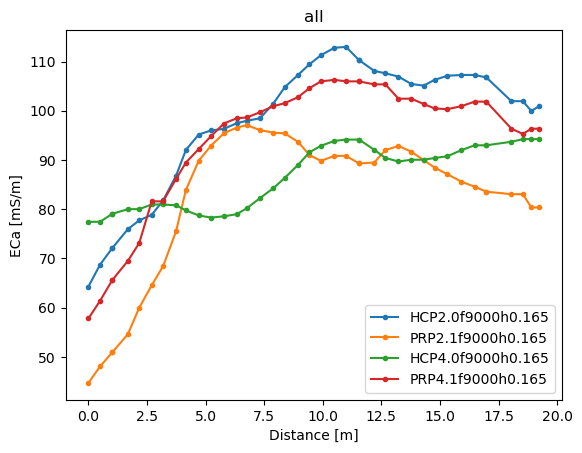

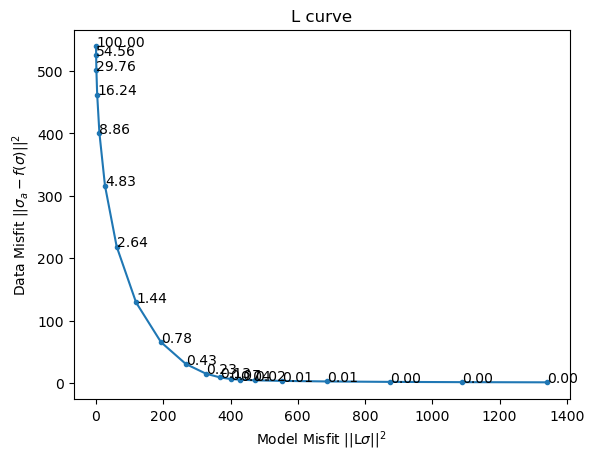

In [8]:
# FDEM inversion along ERT transect
# --------------------------------

if em_intype == 'rec':
    em_input = em_rec.copy()
elif em_intype == 'survey':
    em_input = em_survey.copy()
else:
    em_input = em_lin.copy()
print('conductivities', conductivities)

if config['start_avg']:
    print('start_mod', start_mod)
    
    conductivities = start_mod
    if len(conductivities) == len(mod_layers):
        mod_layers = mod_layers[1:]
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    elif len(conductivities) == (len(mod_layers)+1):
        mod_layers = mod_layers
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")

print('conductivities', conductivities)

if 'p_ID' in em_input.columns:
    em_input = em_input.rename(columns={"p_ID": "ID"})

temp_dir = 'temp_emp' 
infile_name = 'infile_t02.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
n = 4
em_input.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_input.columns.values[n:n+i] = new_columns

em_input.to_csv(temp_file)

# transect inversion settings
t_rec = Problem()
t_rec.createSurvey(temp_file)

t_rec.setInit(
    depths0=np.flipud(mod_layers),
    conds0=np.flipud(conductivities)
    # fixedDepths=startmodel['fixedDepths'],
    # fixedConds=startmodel['fixedConds']
    )
shutil.rmtree(temp_dir)

if config['remove_coil']:
    if type(config['coil_n']) == list:
        config['coil_n'] = sorted(config['coil_n'])
        for i in enumerate(config['coil_n']):
            r_coil = t_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
            t_rec.removeCoil(config['coil_n'][i[0]]-i[0])
    else:
        t_rec.removeCoil(config['coil_n'])
print(f'Data used for inversion: {t_rec.coils}')
t_rec.show()

# n = -2
# m = 1
# inc = 0.01
# n_alph = 10

# alphas = np.logspace(n,m,n_alph)
t_rec.lcurve()
if config['constrain']:
    print(f'lengths: mod_layers = {len(mod_layers)}; bounds =  {len(bounds)}; con = {len(conductivities)}')
else:
    print(f'lengths: mod_layers = {len(mod_layers)}; con = {len(conductivities)}')


Inversion using FSeq with L-BFGS-B, reg=l2, alpha=0.07
40/40 inverted

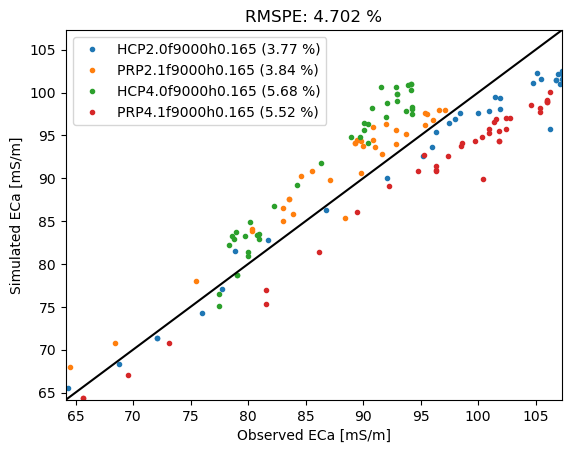

In [9]:
if not only_samples:
    # invert using ROPE solver (RObust Parameter Estimation)
    warnings.filterwarnings('ignore')
    
    inv_meth = config['fs_emp']
    opt_meth = config['opt_method']
    reg_meth = config['regularization']
    alph_param = config['alpha']

    if opt_meth in ['MCMC', 'ROPE']:
        if config['constrain']:
            print(f'Constrained inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
            print(f'Bounds are: {bounds}')
            t_rec.invert(forwardModel=inv_meth, 
                         method=opt_meth, 
                         regularization=reg_meth, 
                         alpha=alph_param, 
                         bnds=bounds,
                         rep=3000,
                         njobs=-1
                        )
        else:
            print(f'Inversion using {inv_meth} with {opt_meth},reg={reg_meth}, alpha={alph_param}')
            t_rec.invert(forwardModel=inv_meth, 
                         method=opt_meth, 
                         regularization=reg_meth, 
                         alpha=alph_param, 
                         njobs=-1
                        )  

    else:
        print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        t_rec.invert(forwardModel=inv_meth, 
                     method=opt_meth, 
                     alpha=alph_param,
                     regularization=reg_meth
                     )
    t_rec.showOne2one()

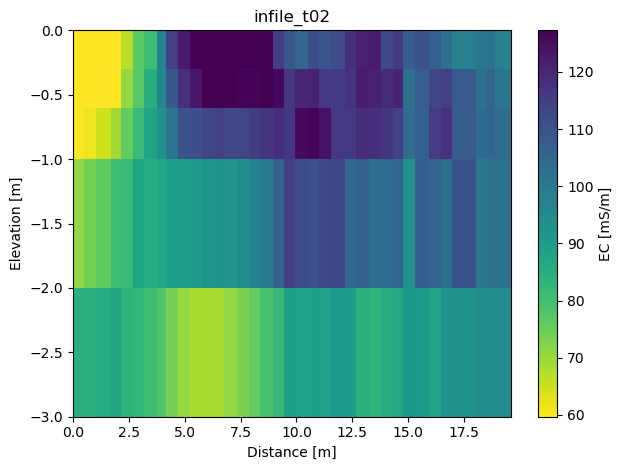

In [10]:
if not only_samples:
    # 4.1: Plot the inversion results and put outcomes into a pandas dataframe
    # ------------------------------------------------------------------------
    csv_filename = f'{now}_{emfile_prefix}_inverted_transect_{opt_meth}.csv'

    # ******************************************************************** #

    # Plot inversion outcomes down to a max depth of 2 m, and plotting the data
    # based on their true coordinates along the transect (dist=True).
    t_rec.showResults(dist=True, errorbar = True) 

    # Extracting the values from the first row of the transect.depths[0] array
    depth_values = t_rec.depths[0][0]

    # Creating the custom column names for layer_cols
    layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

    # Combining the data from the 'x', 'y' columns and the transect.models[0] array
    data = np.c_[t_rec.surveys[0].df[['x', 'y']].values, t_rec.models[0]]

    # Creating the final dataframe with the desired column names
    dt_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
    dt_inv['pos'] = em_input['ID']
    # ----------------------------------------------------------------------

    # Export the dataframe as a csv-file
    outfile_transect = os.path.join(inv_folder, csv_filename)
    dt_inv.to_csv(outfile_transect)

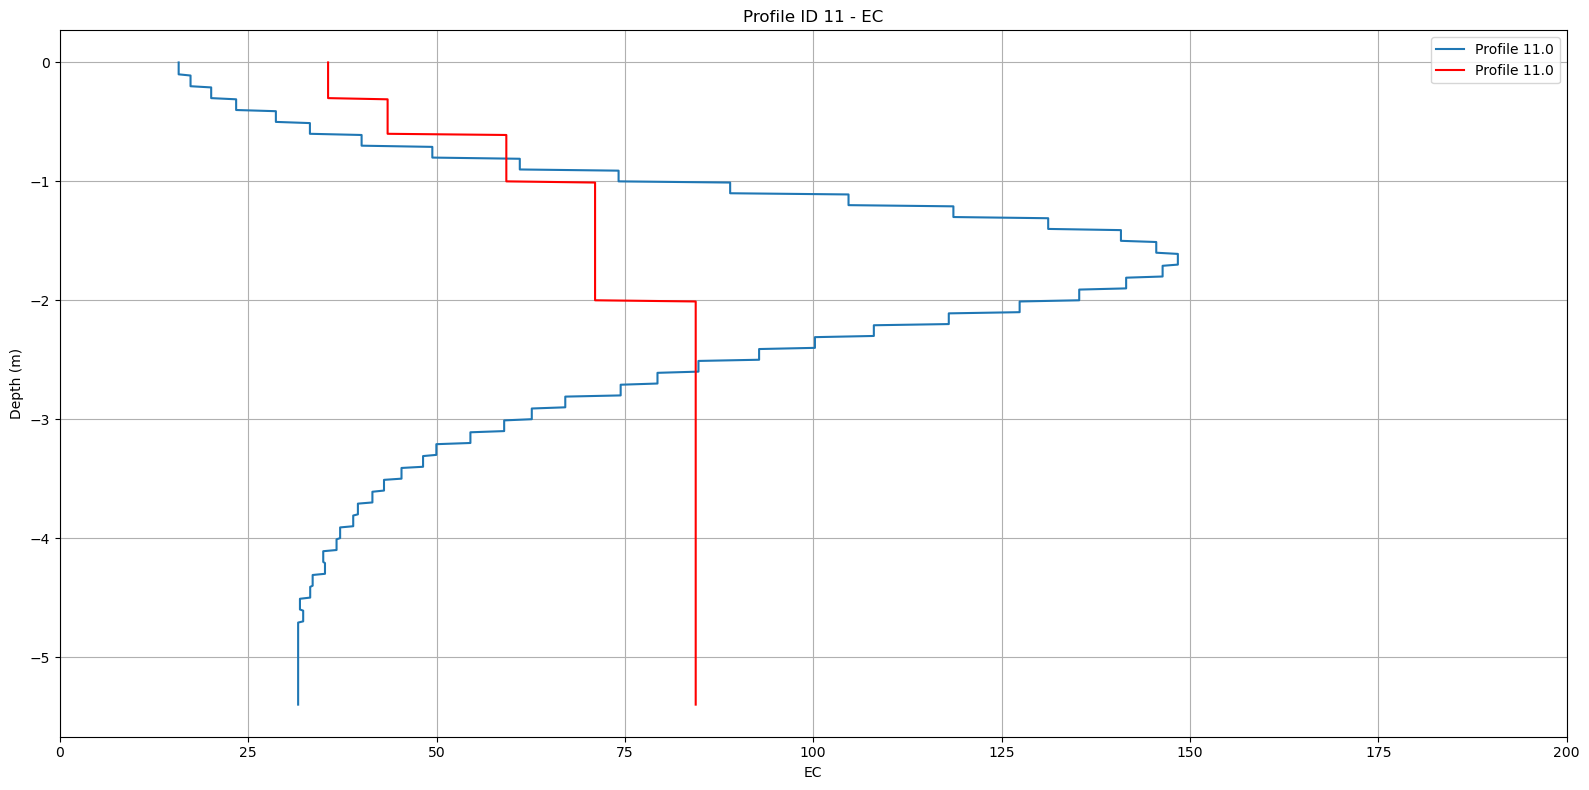

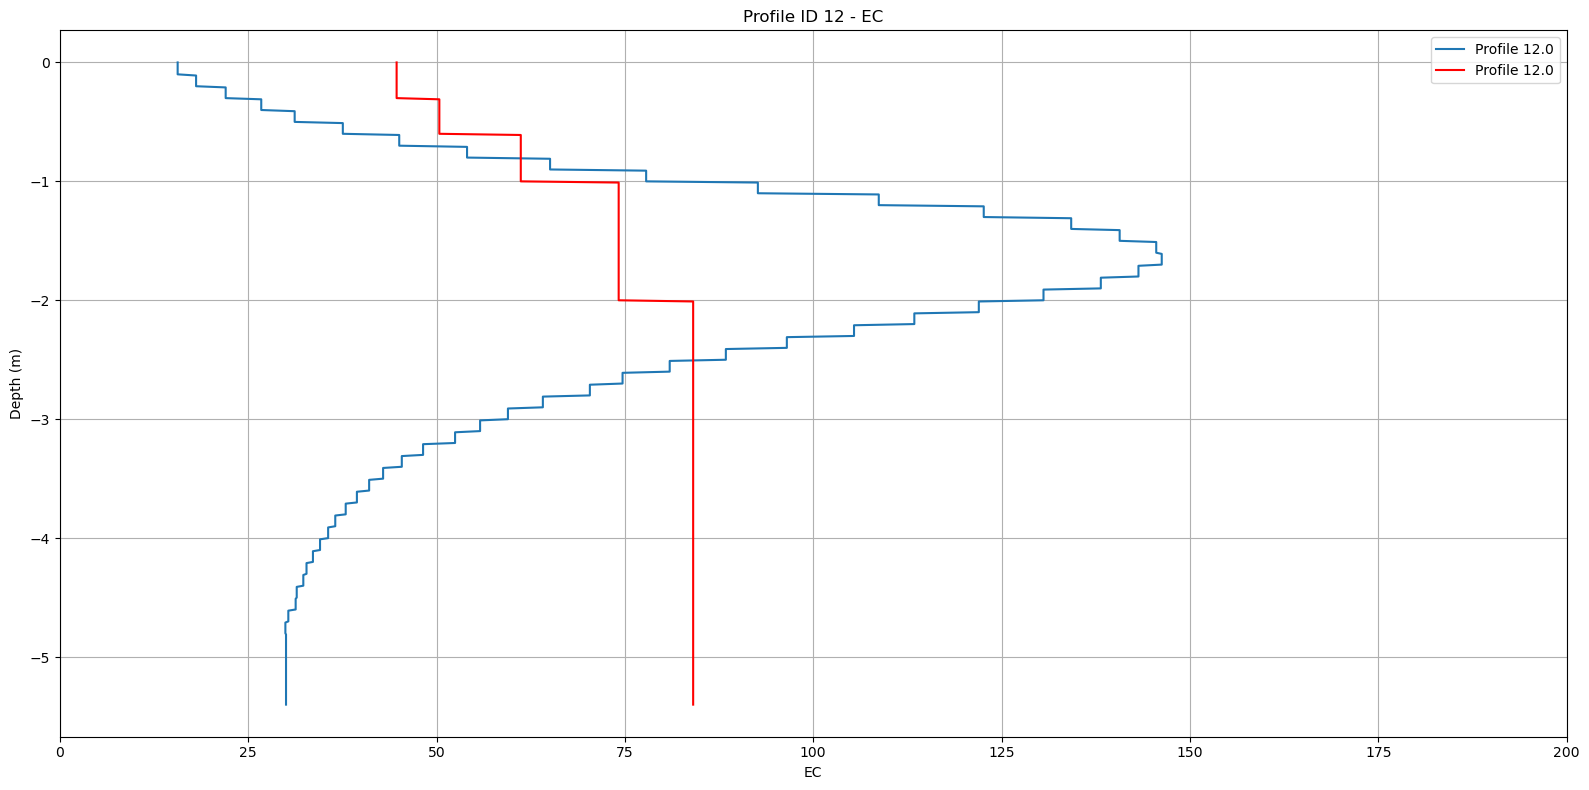

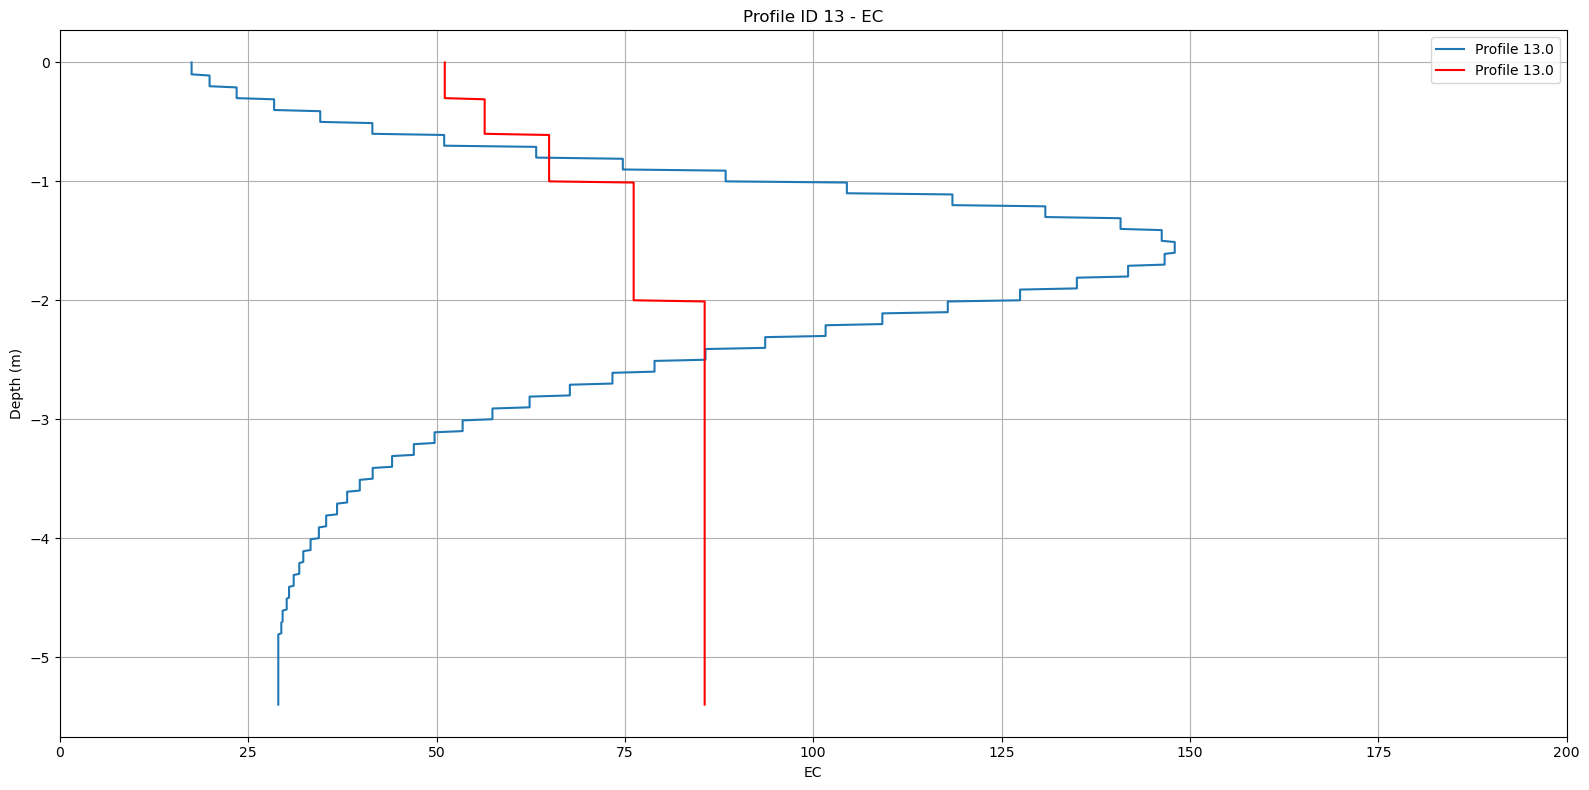

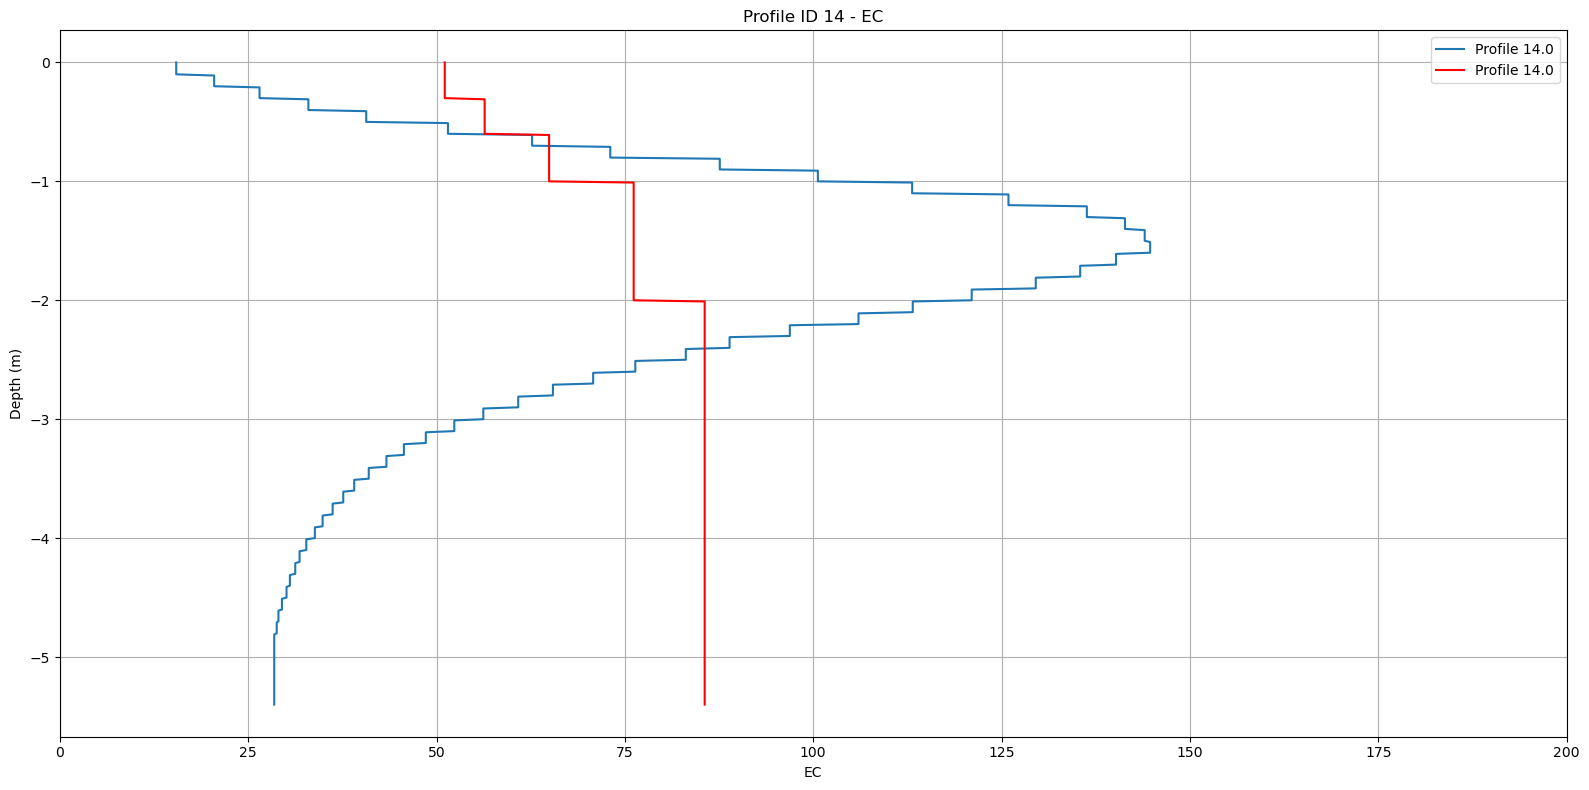

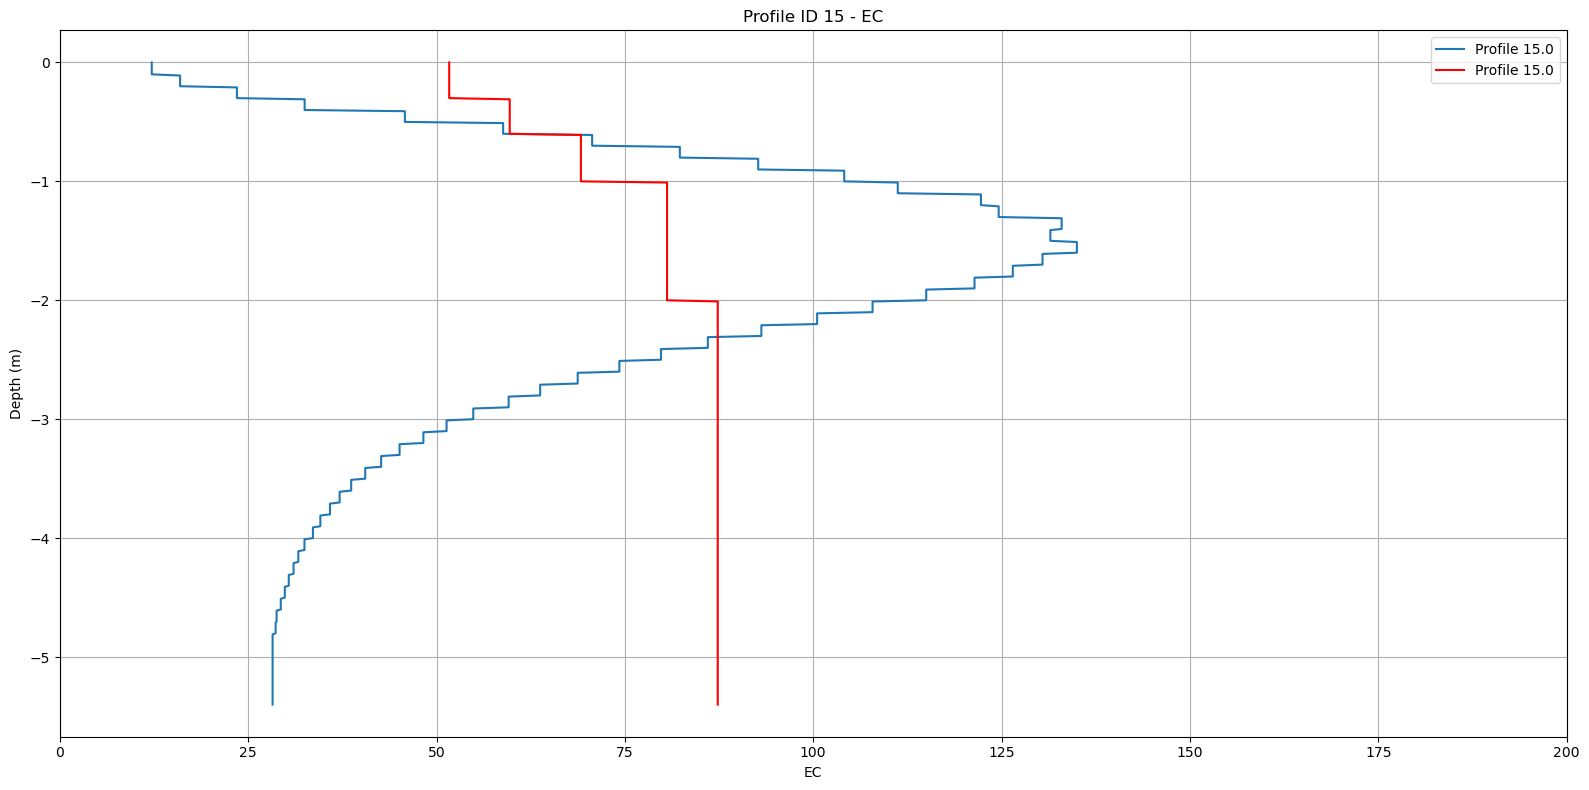

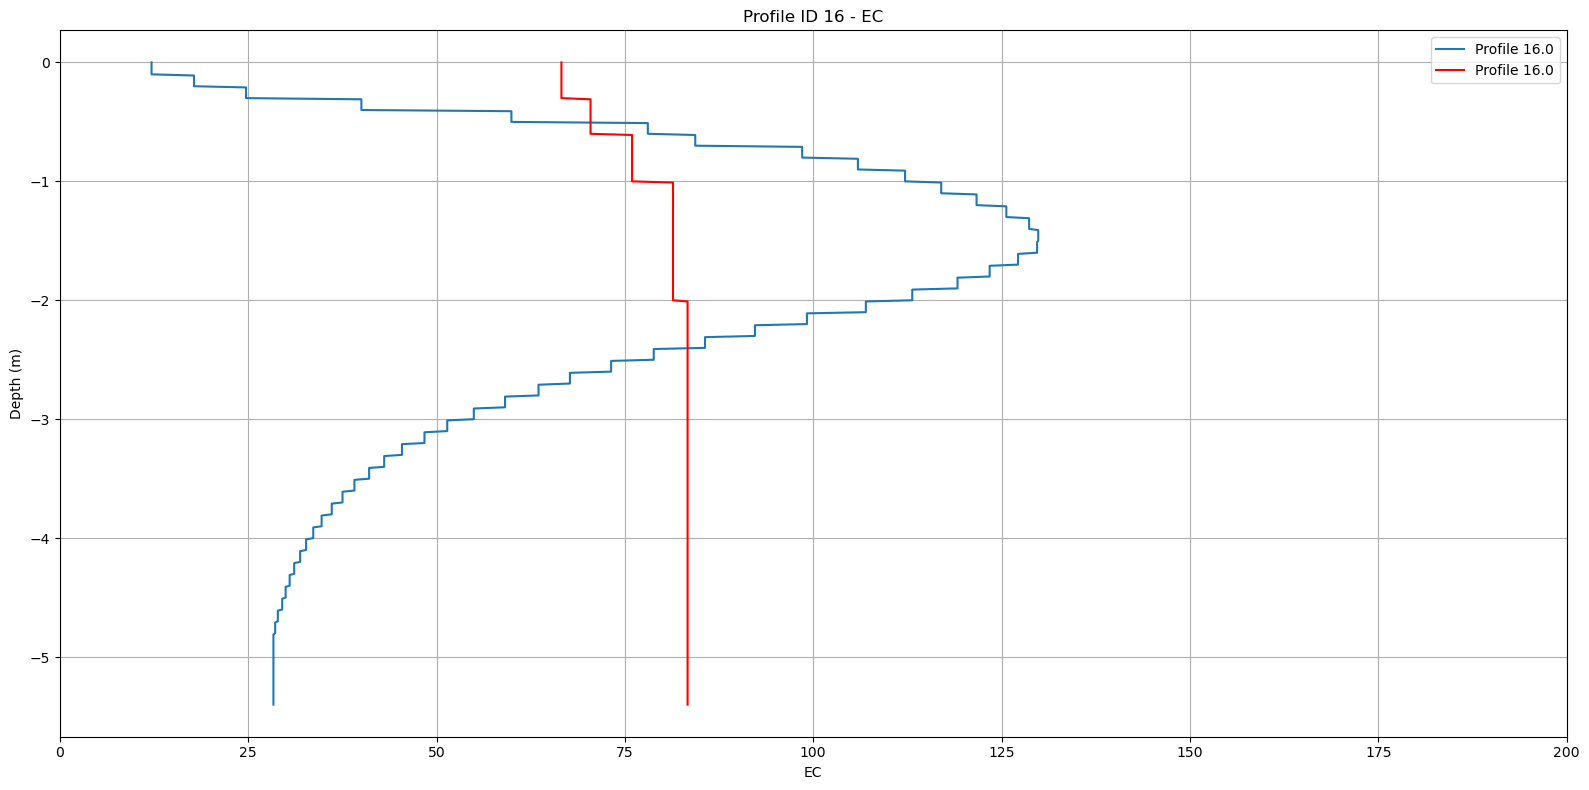

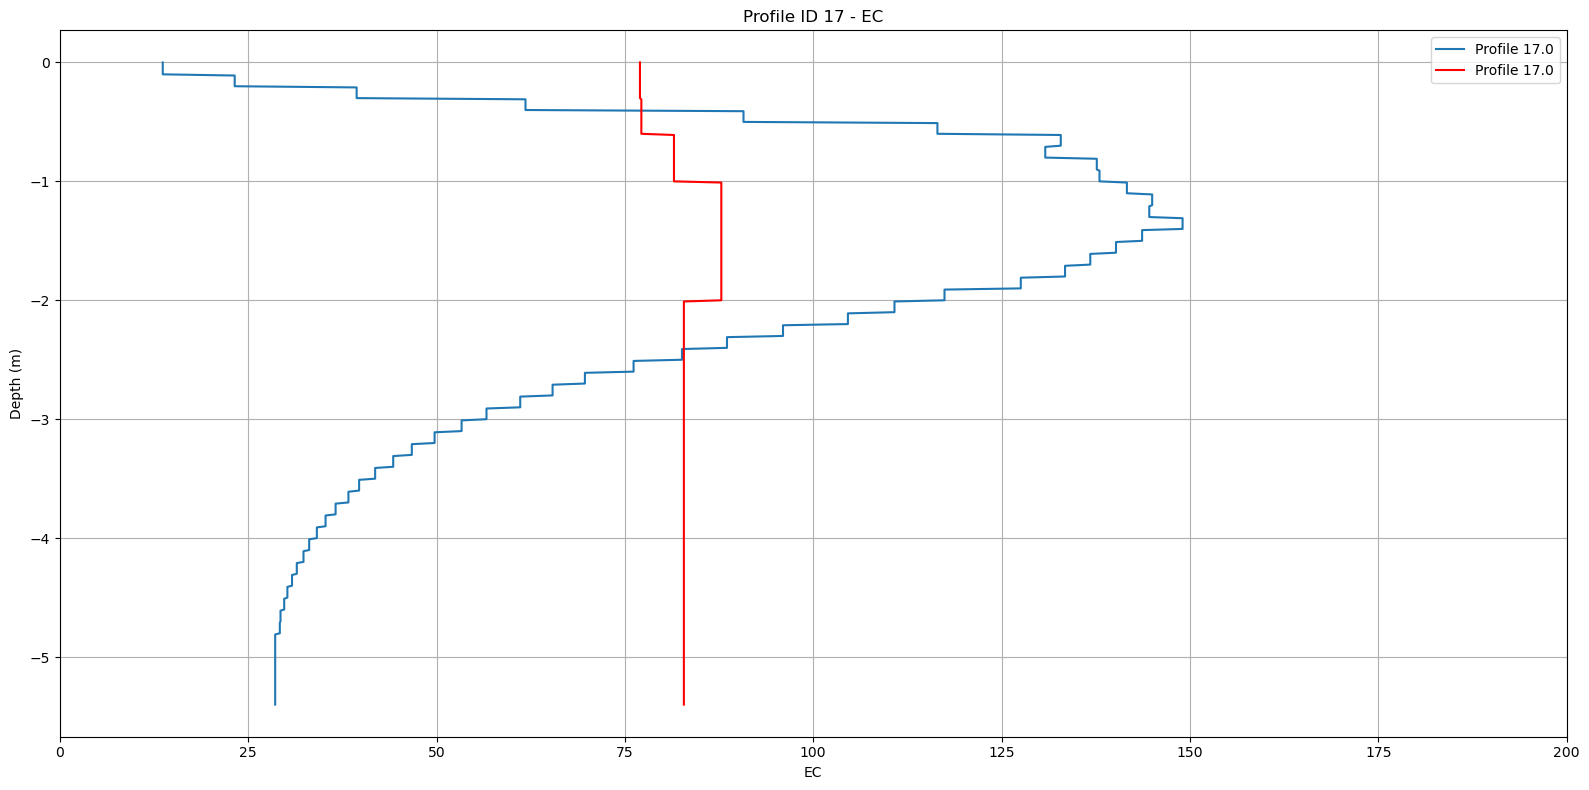

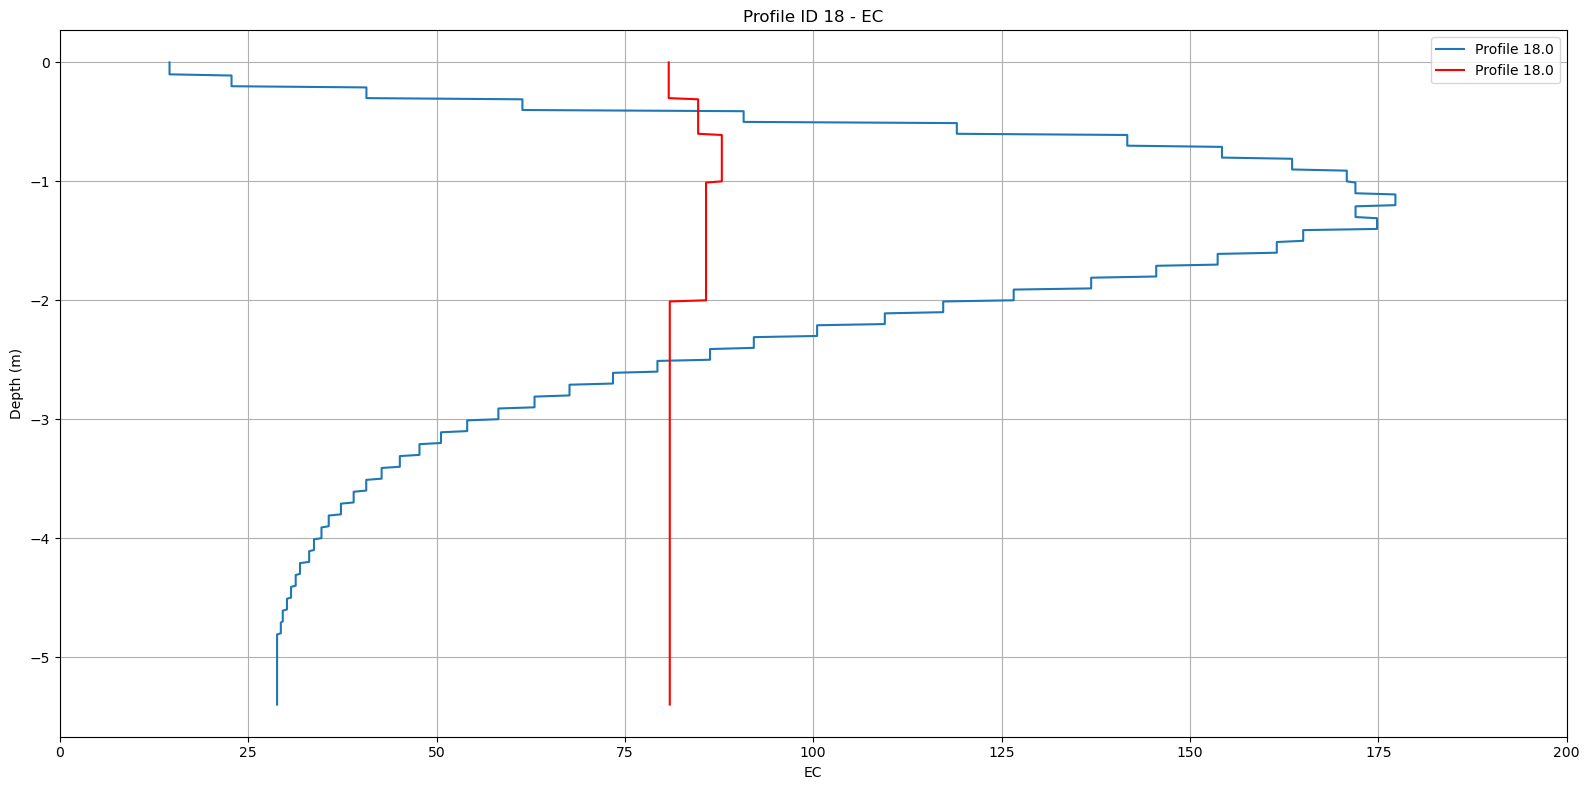

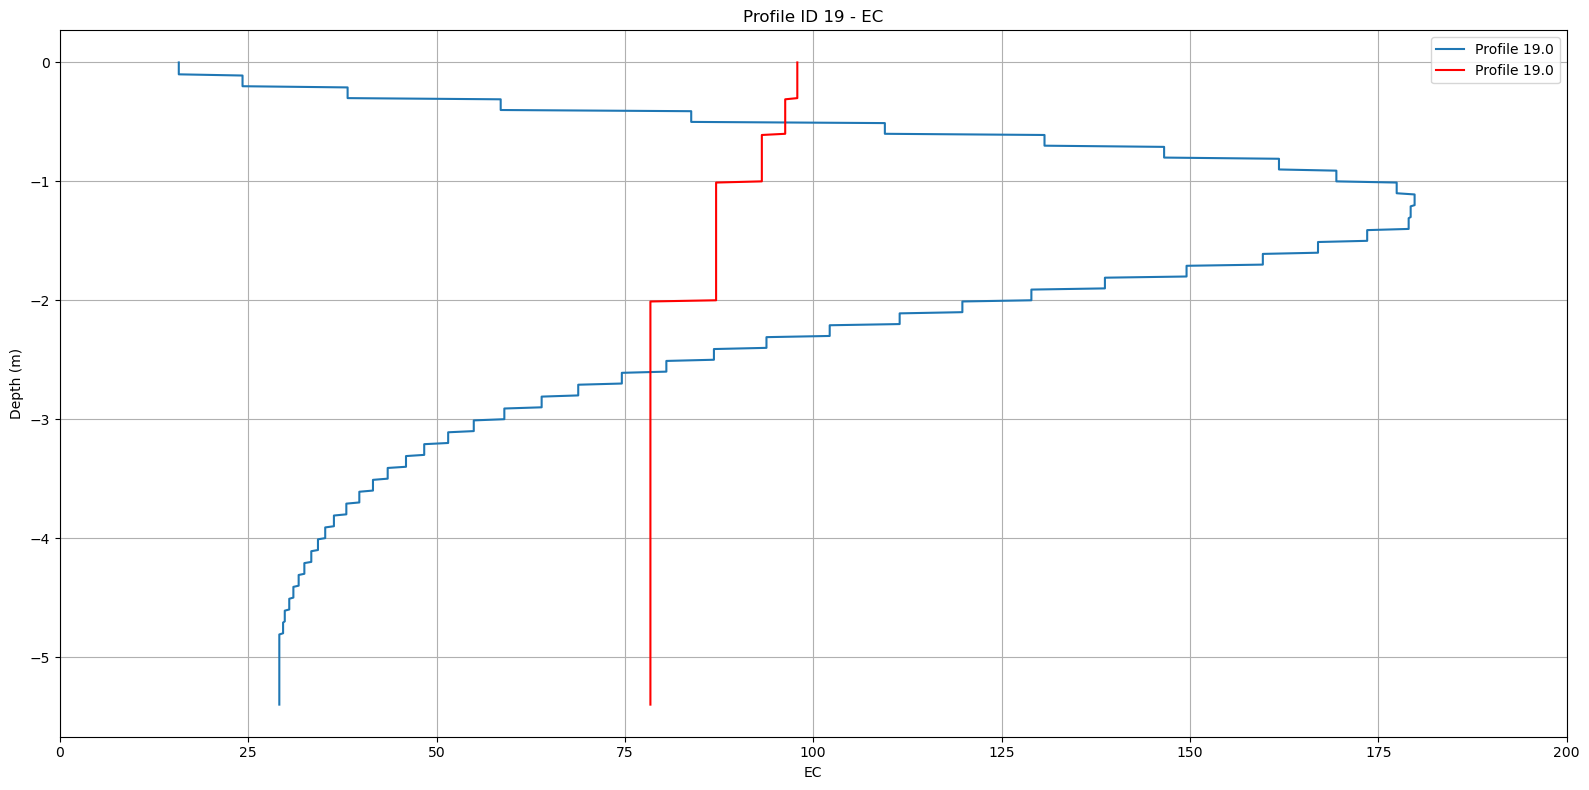

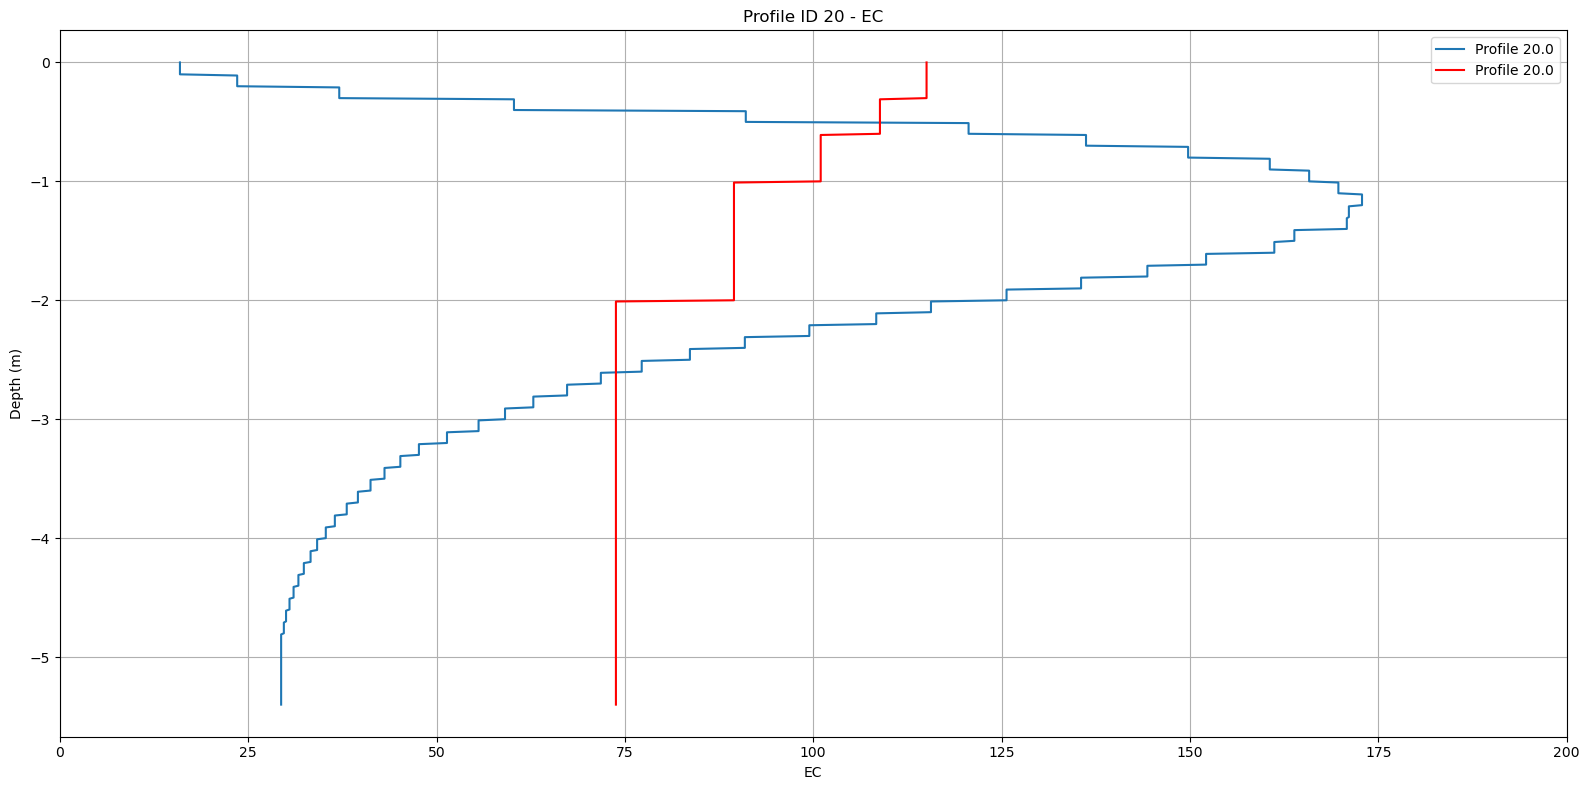

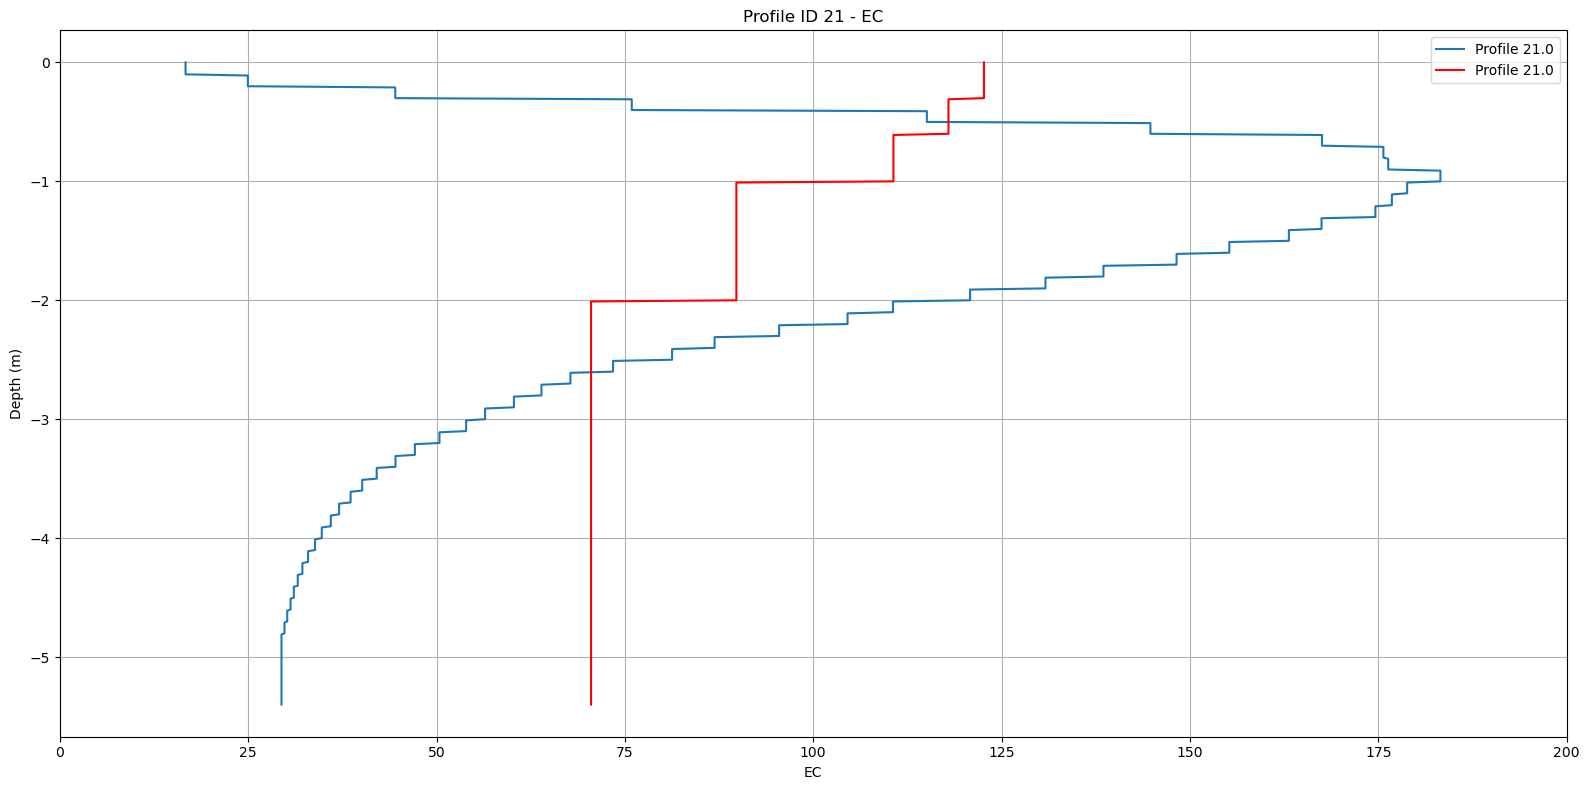

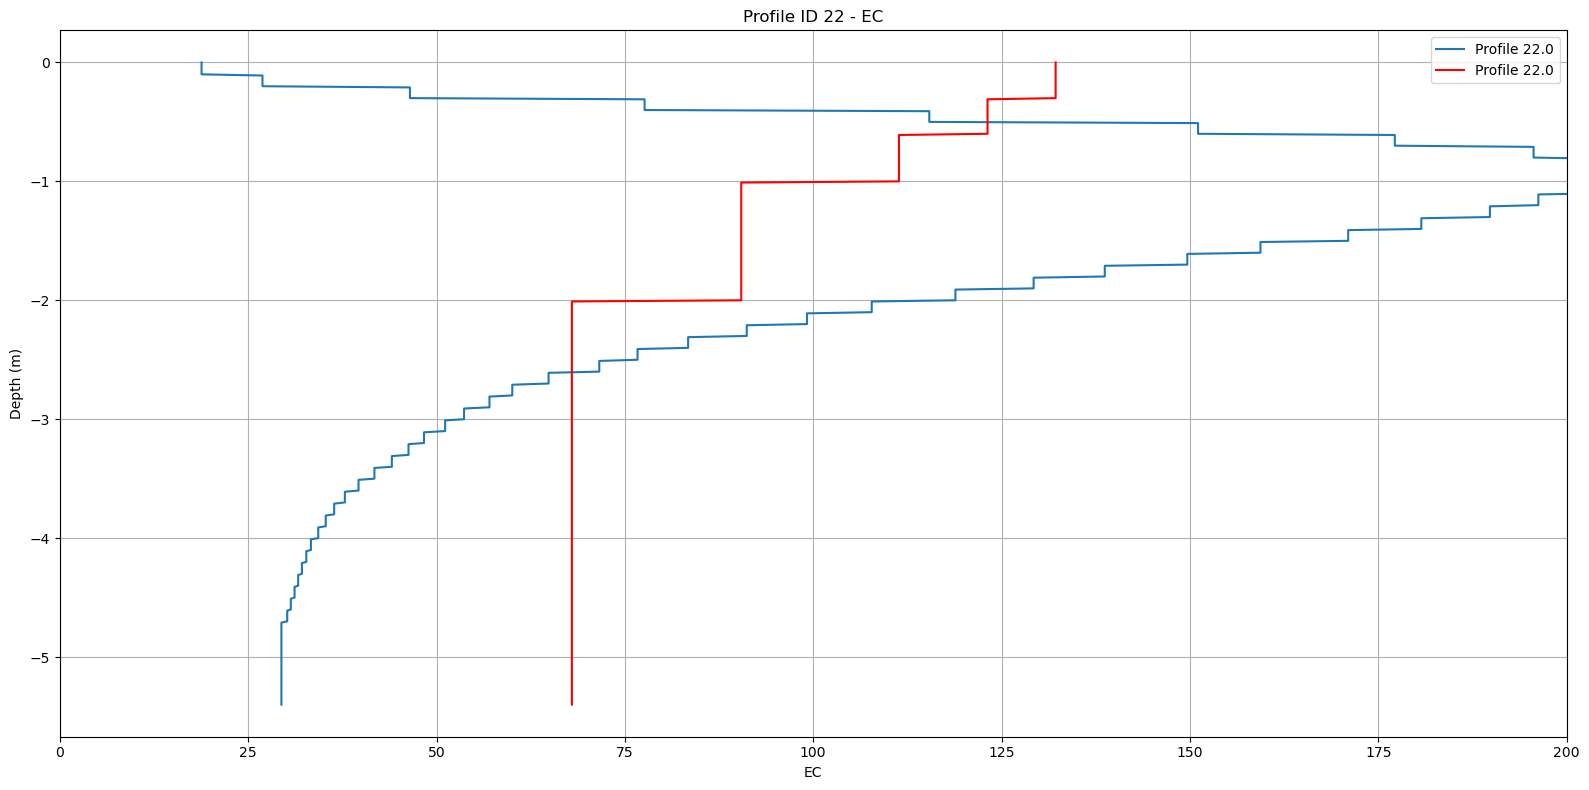

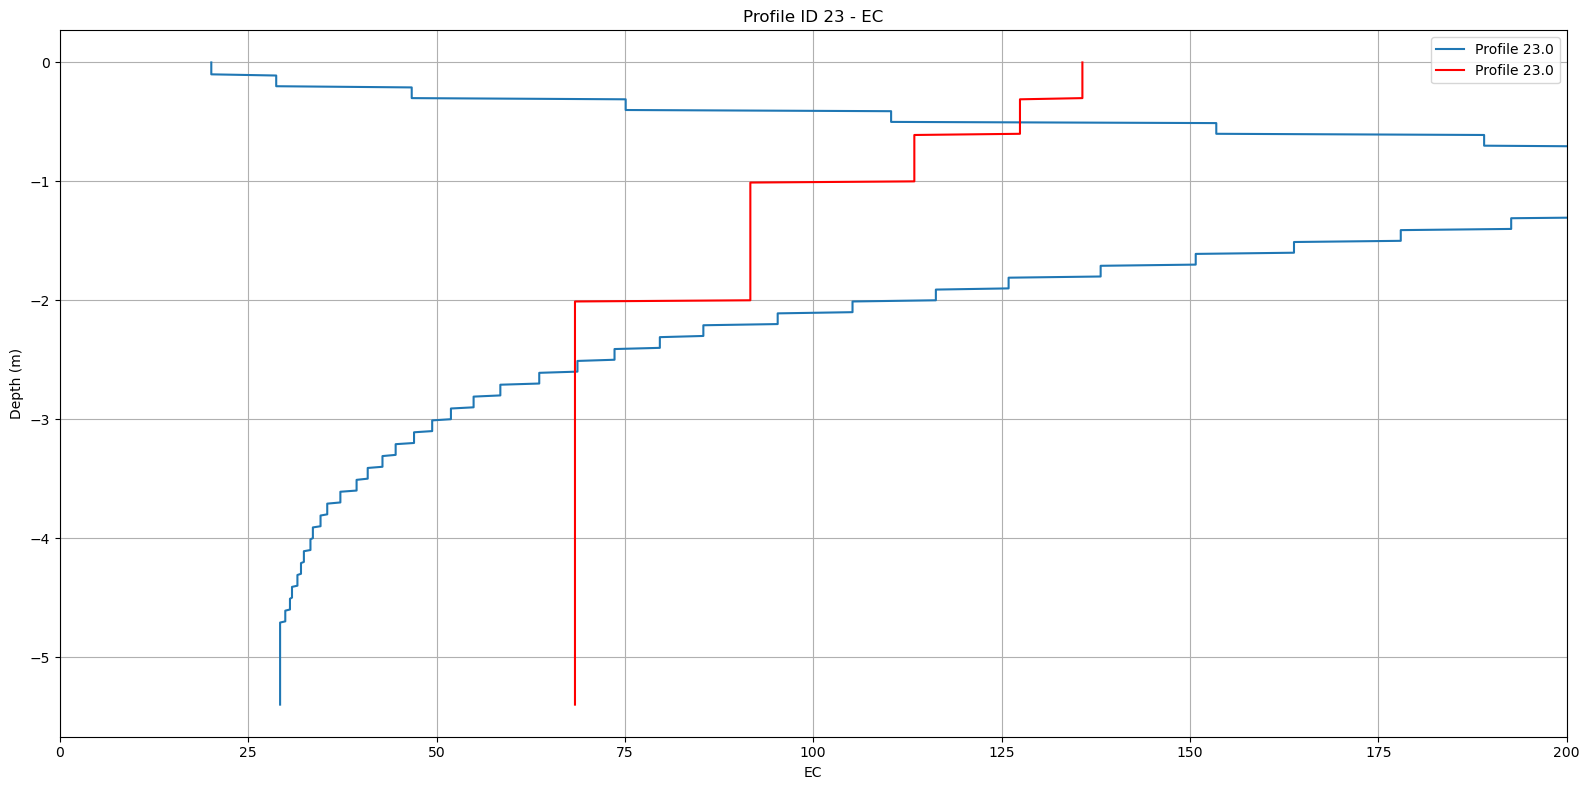

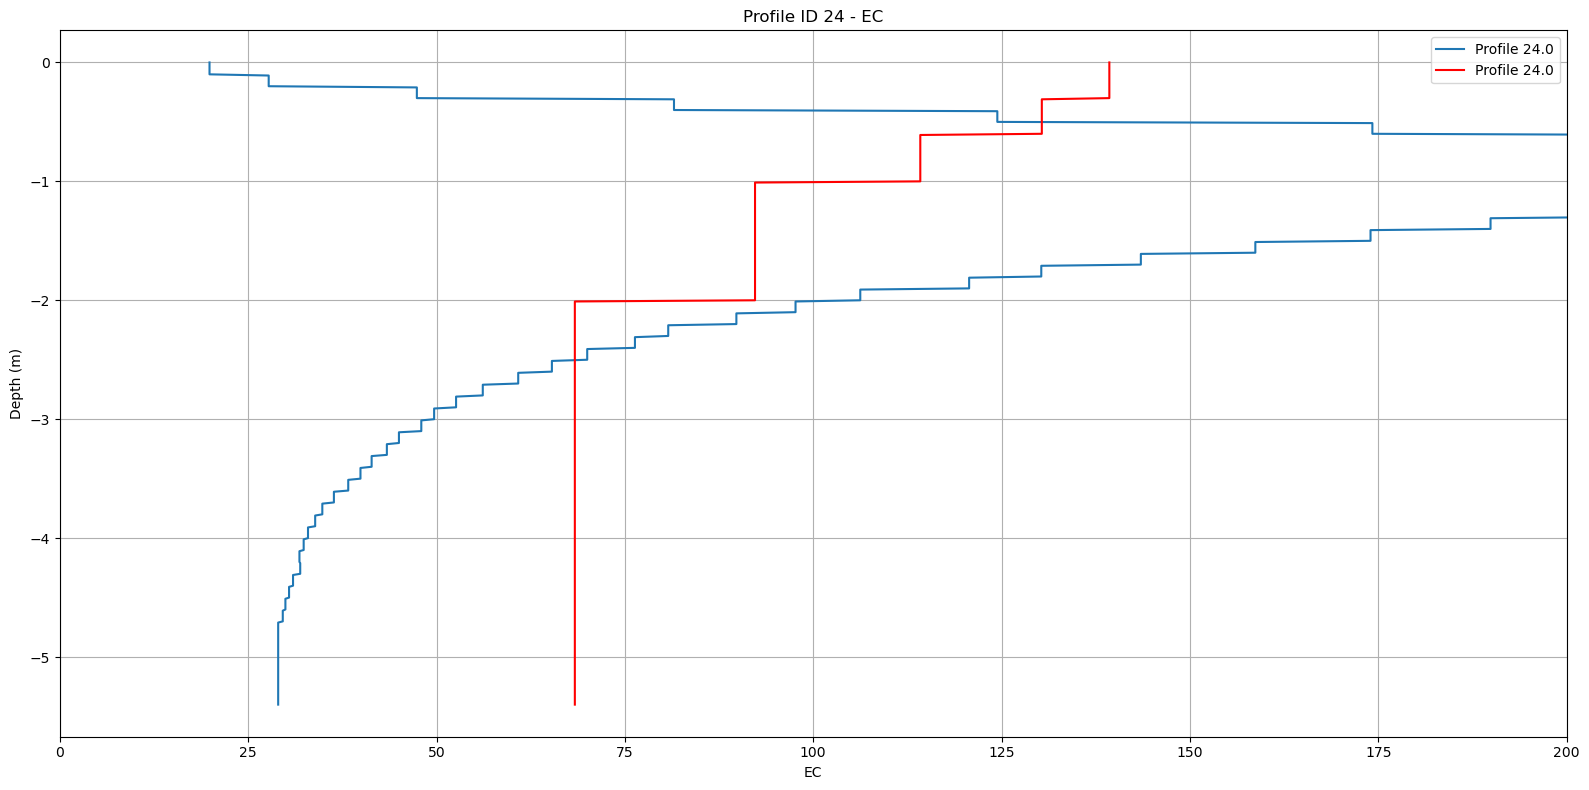

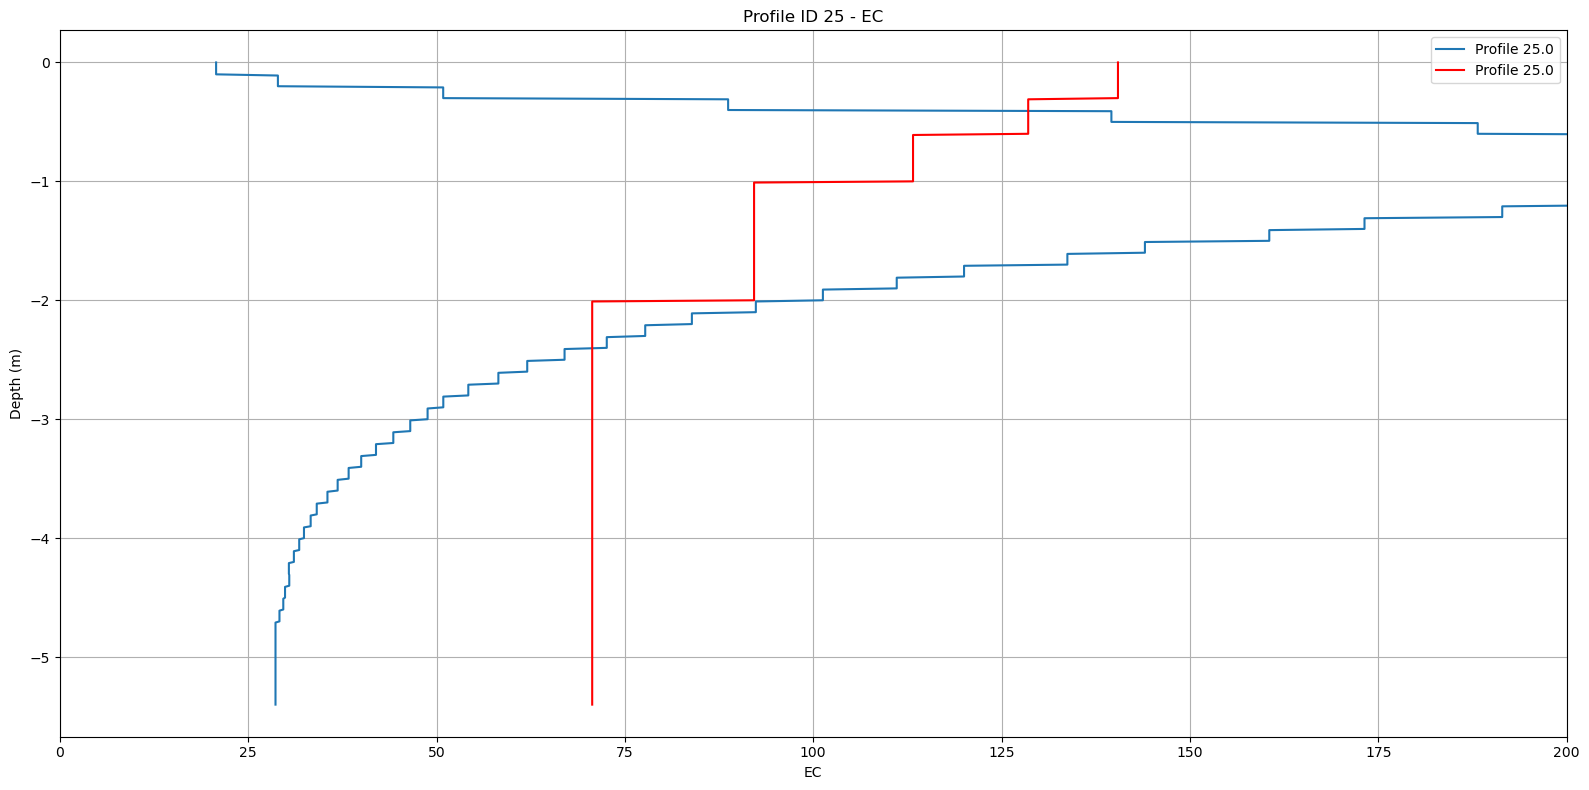

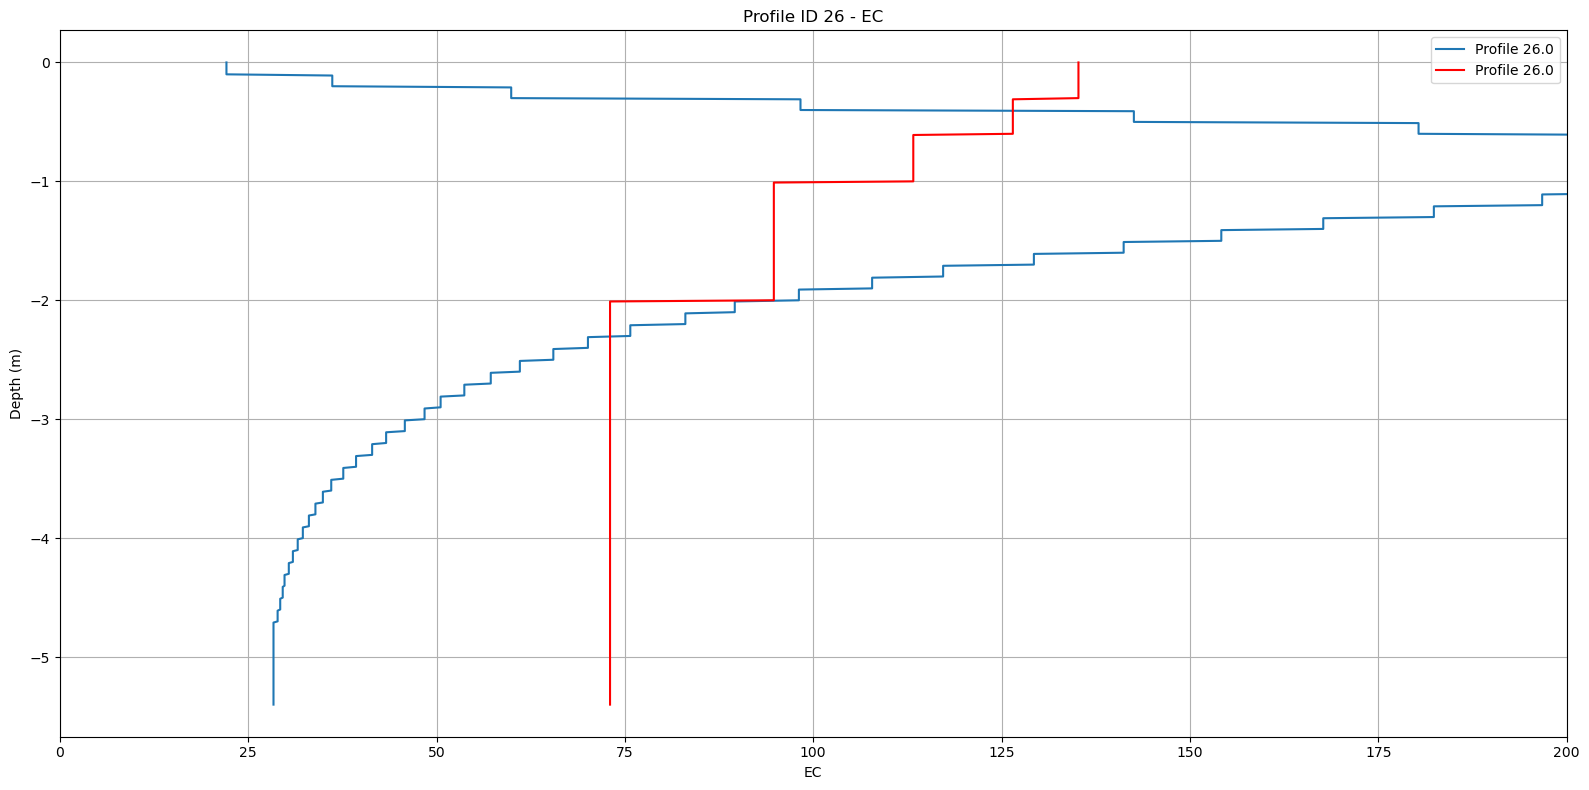

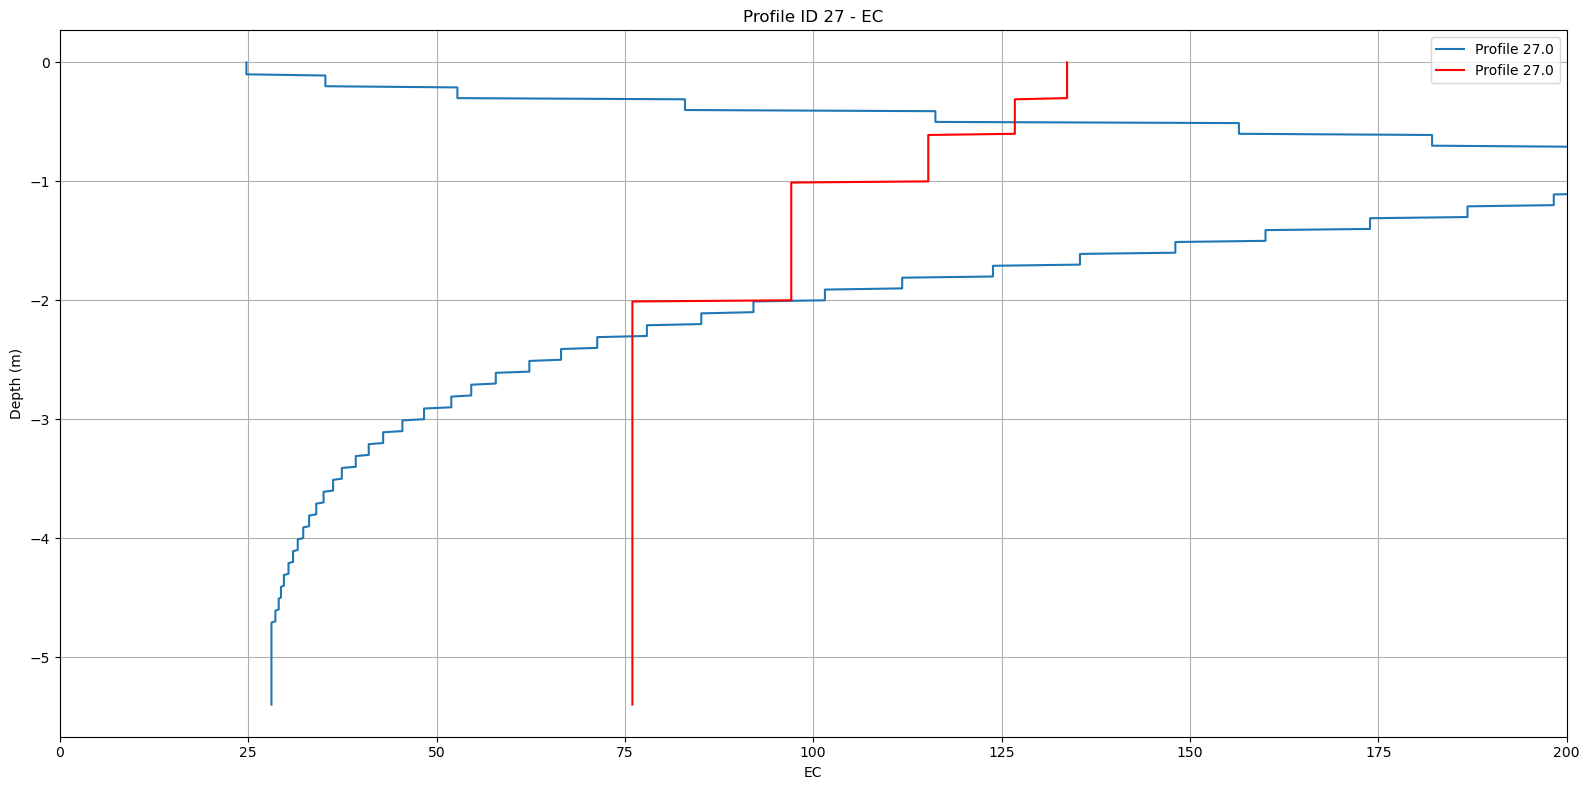

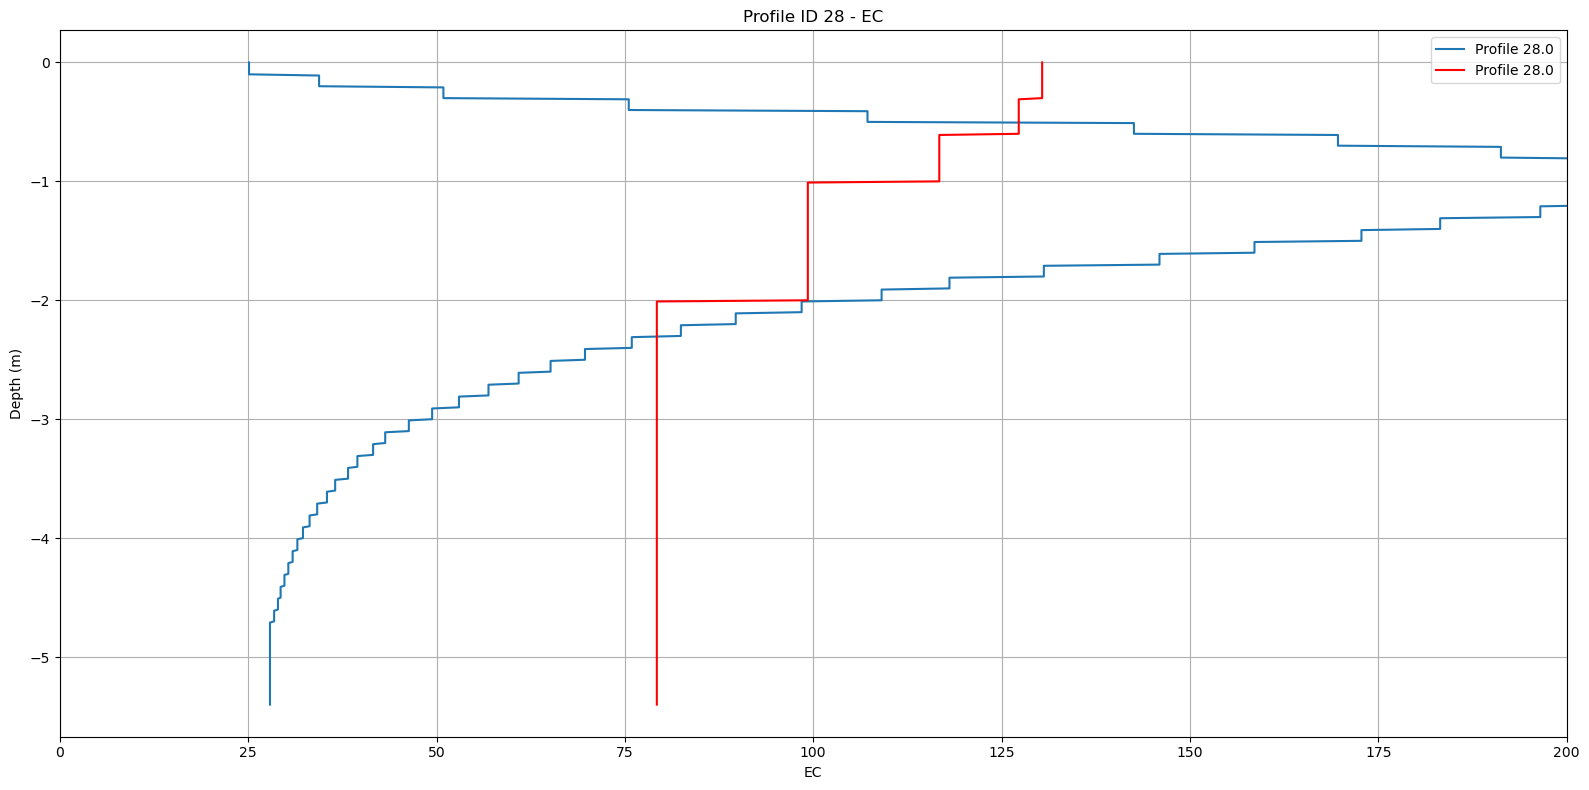

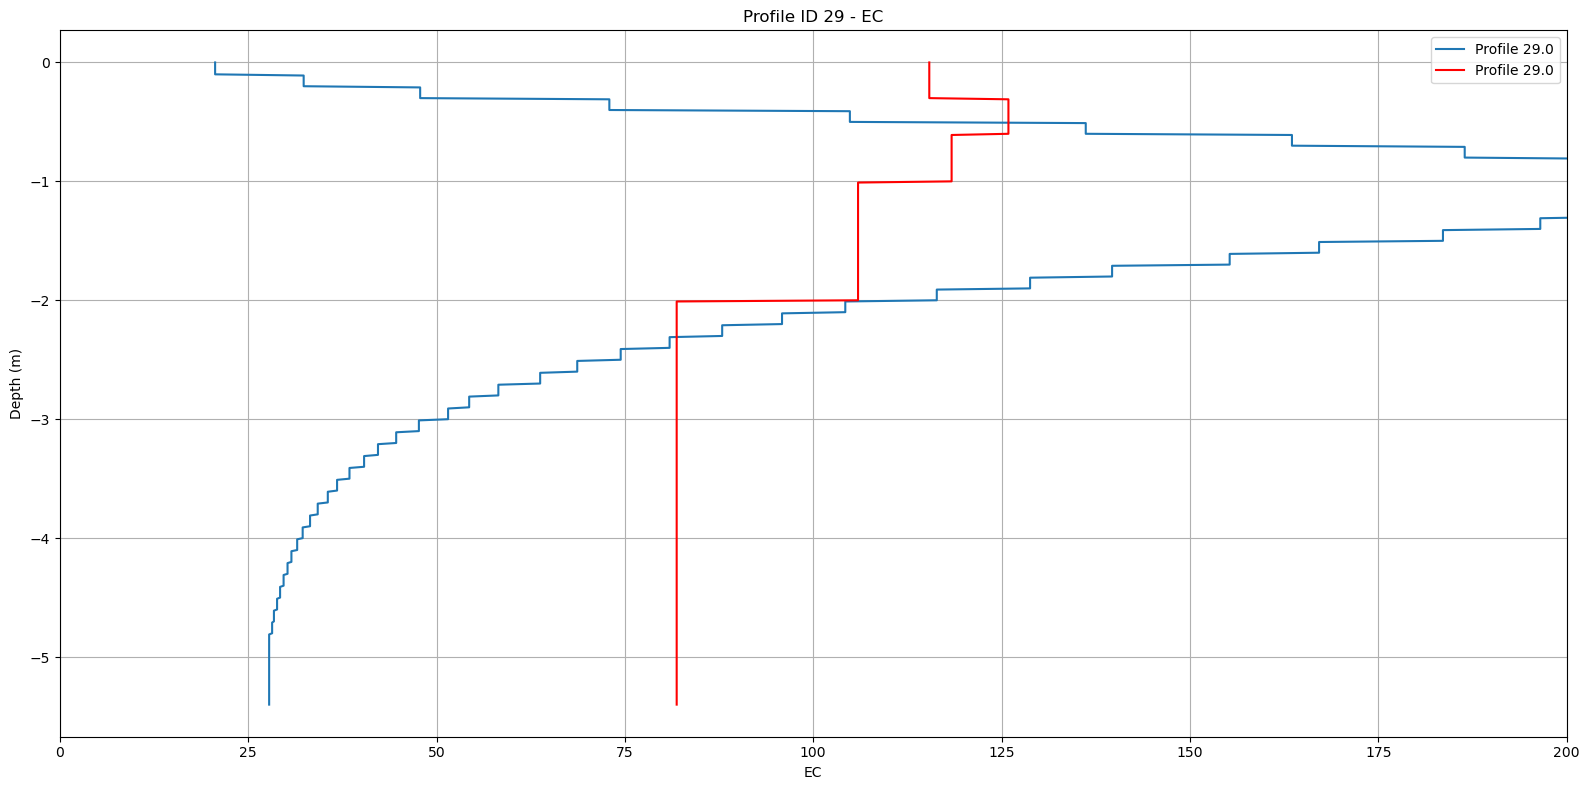

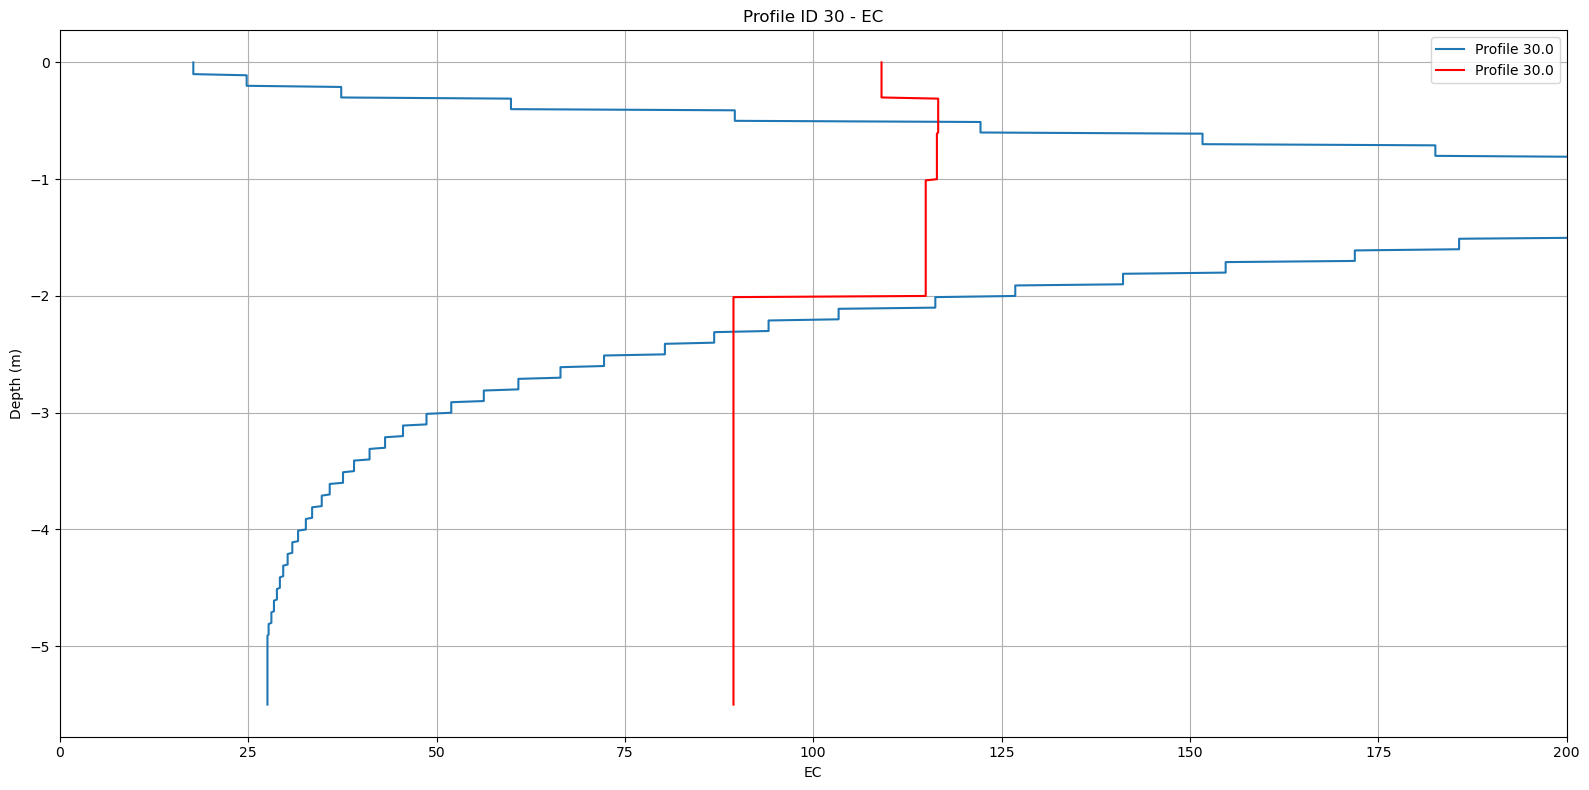

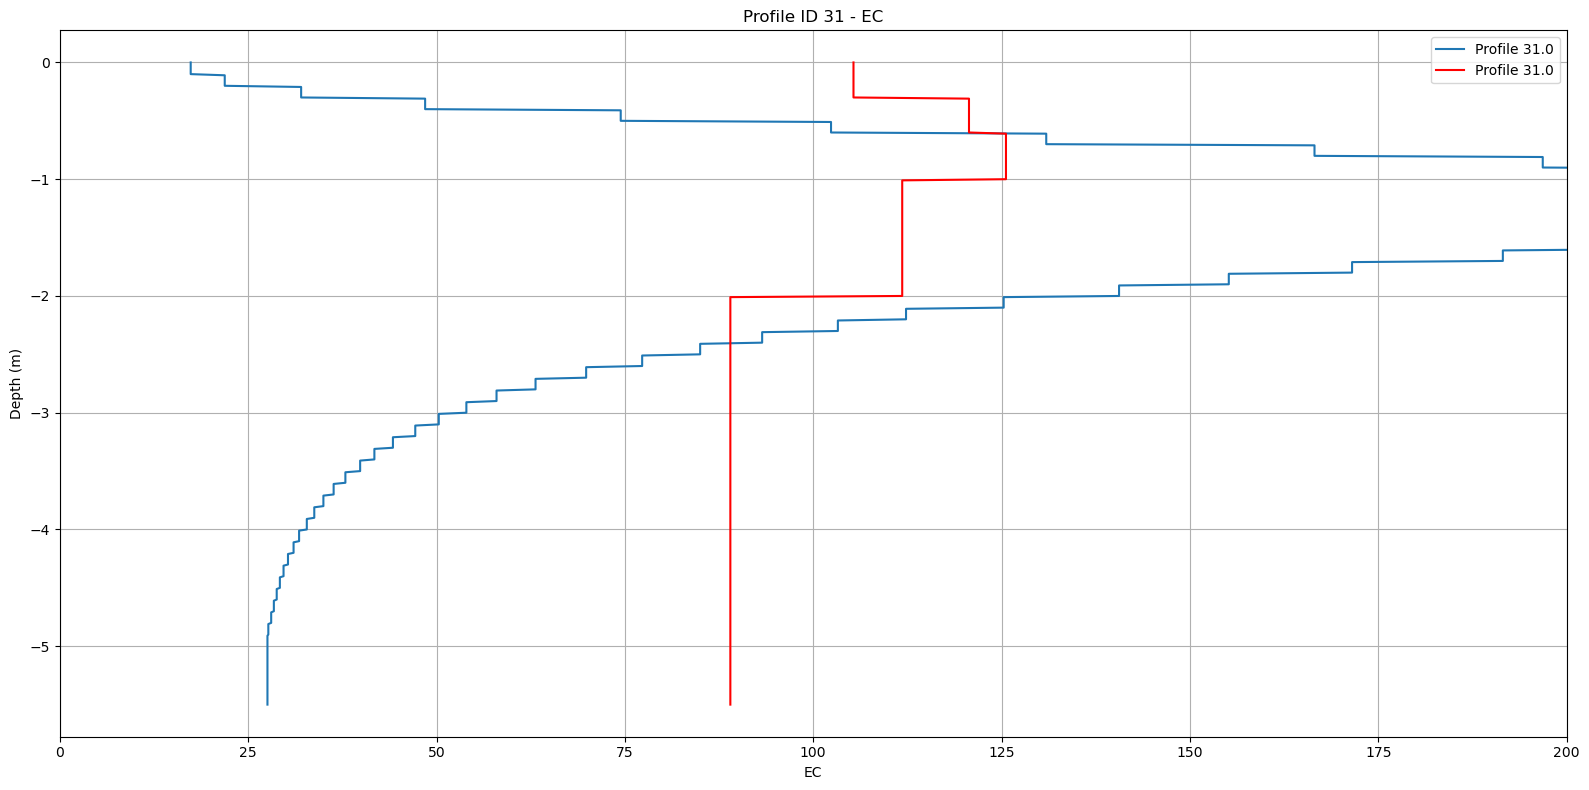

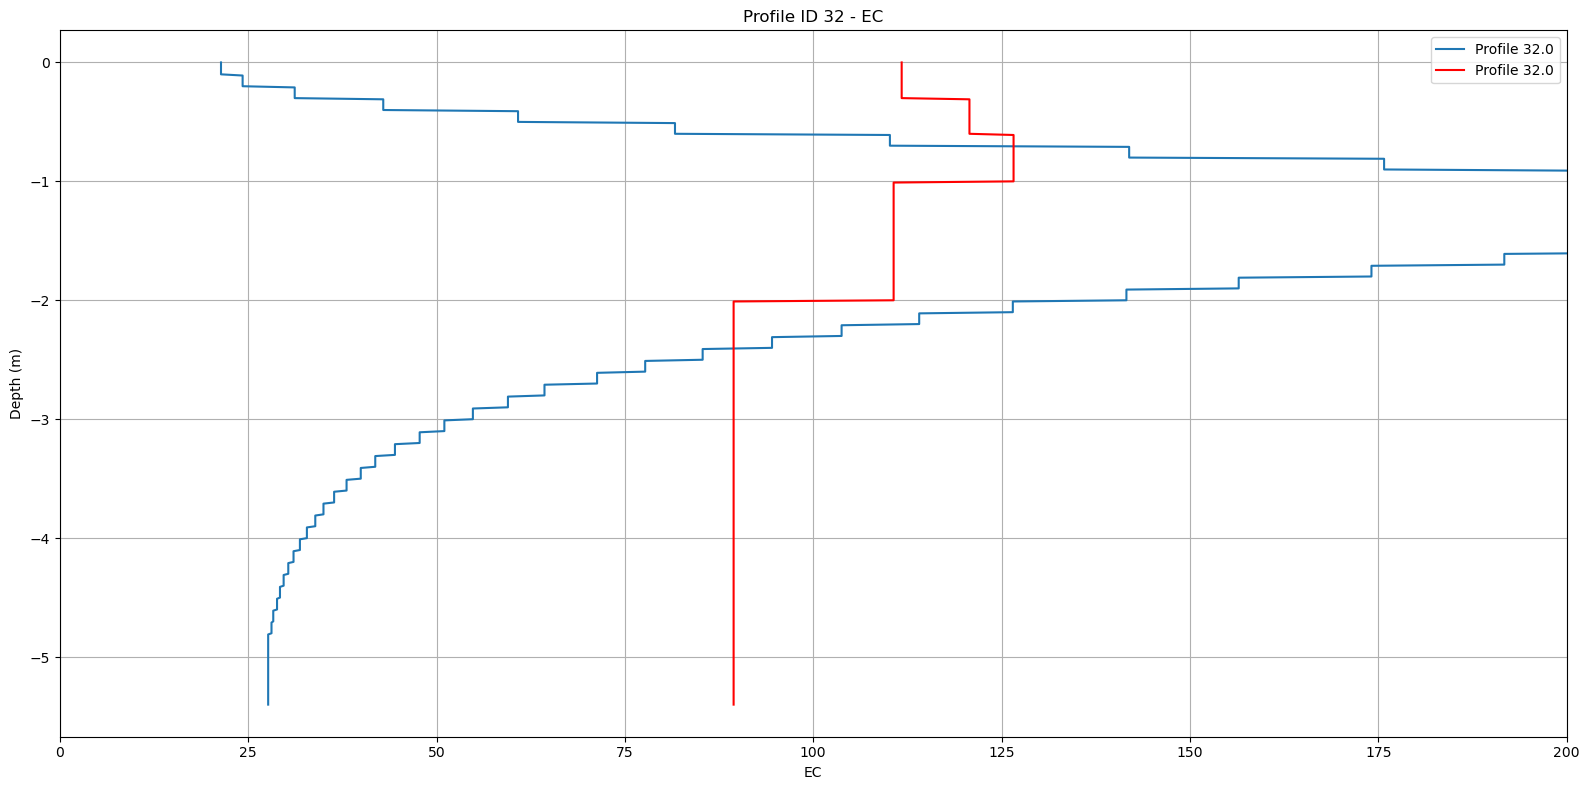

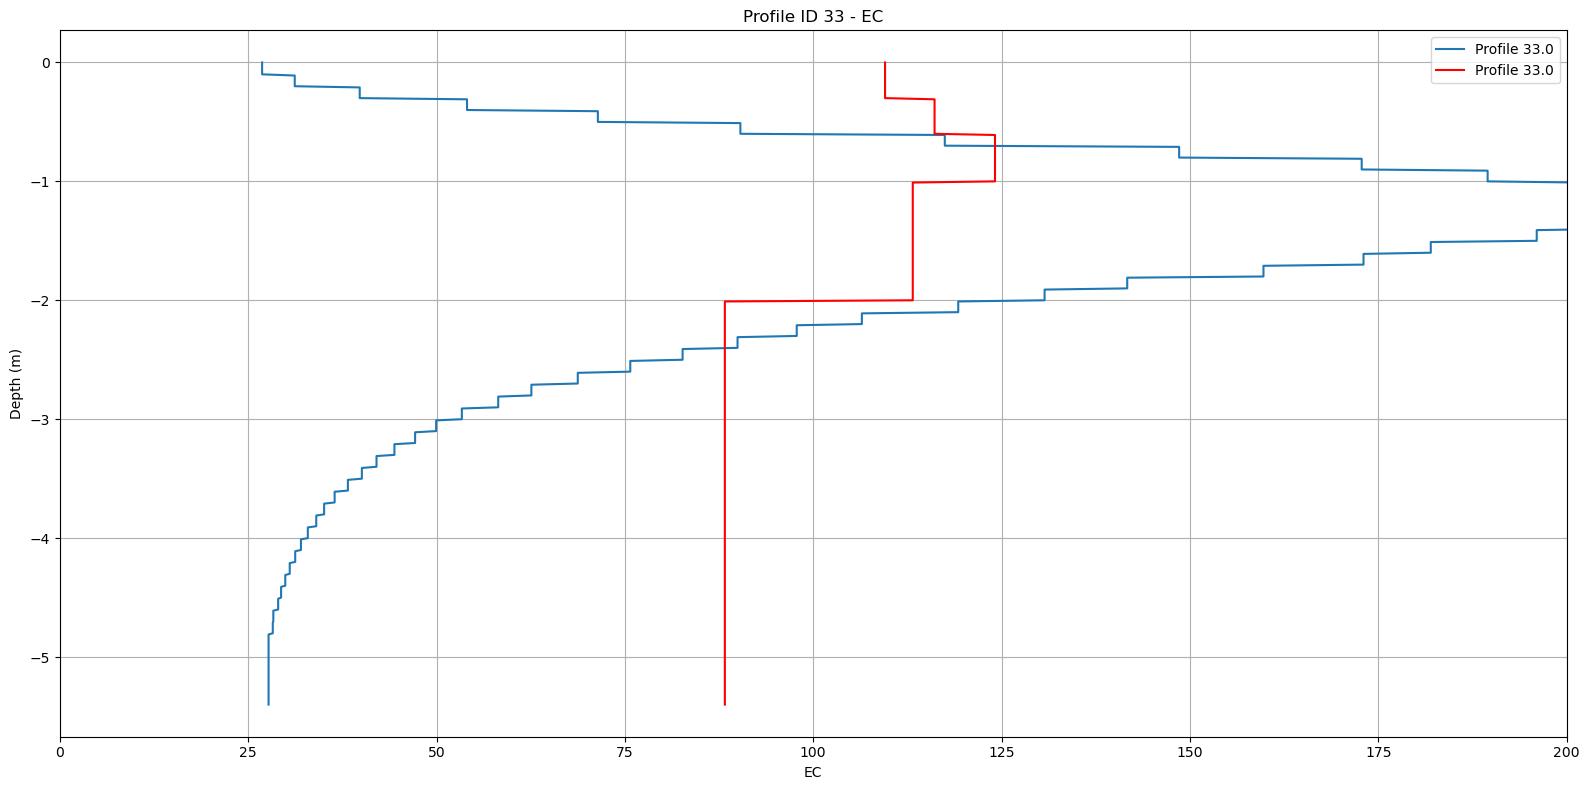

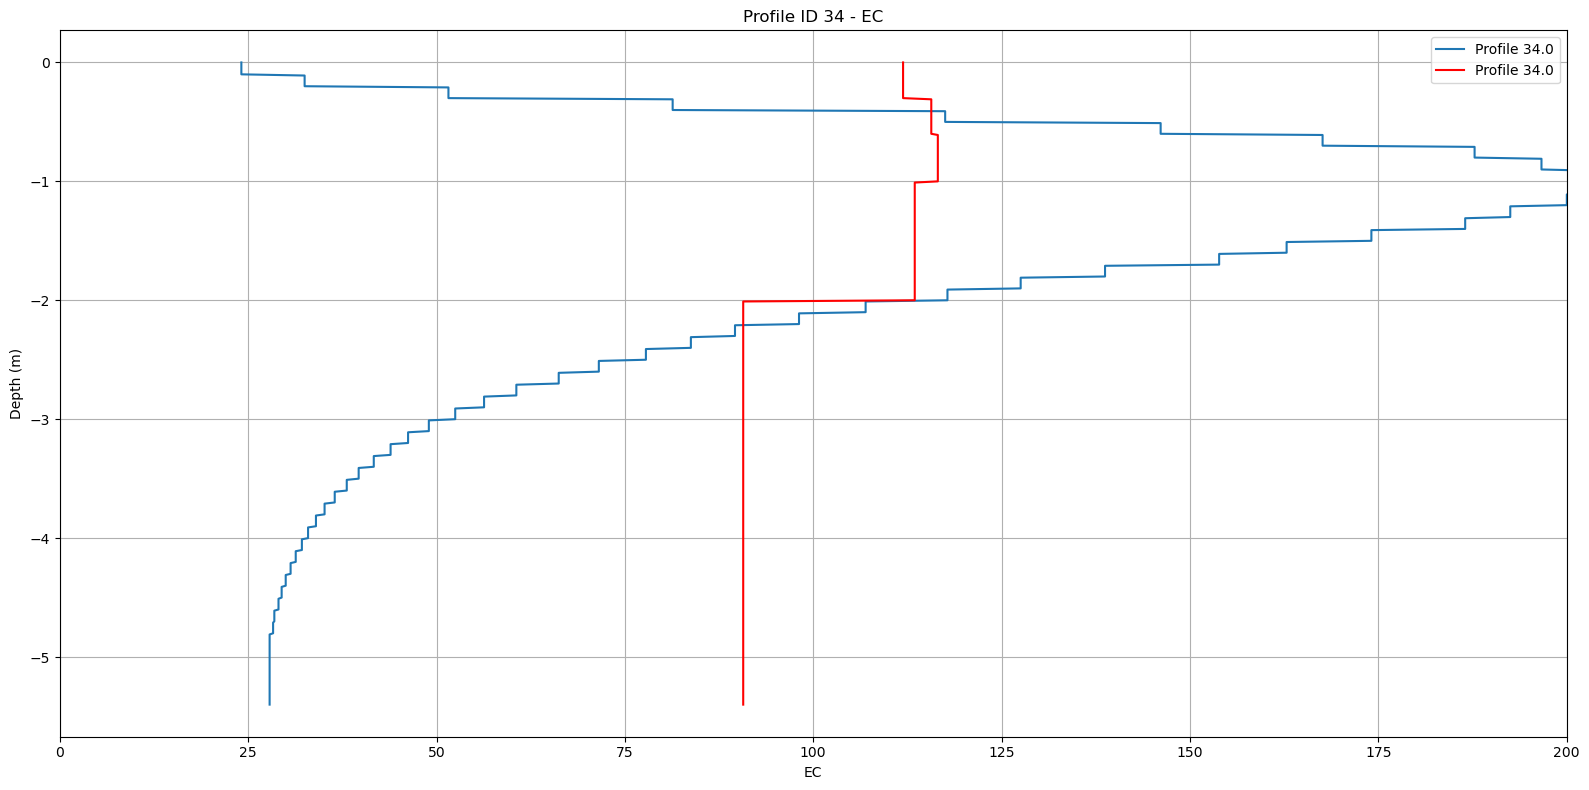

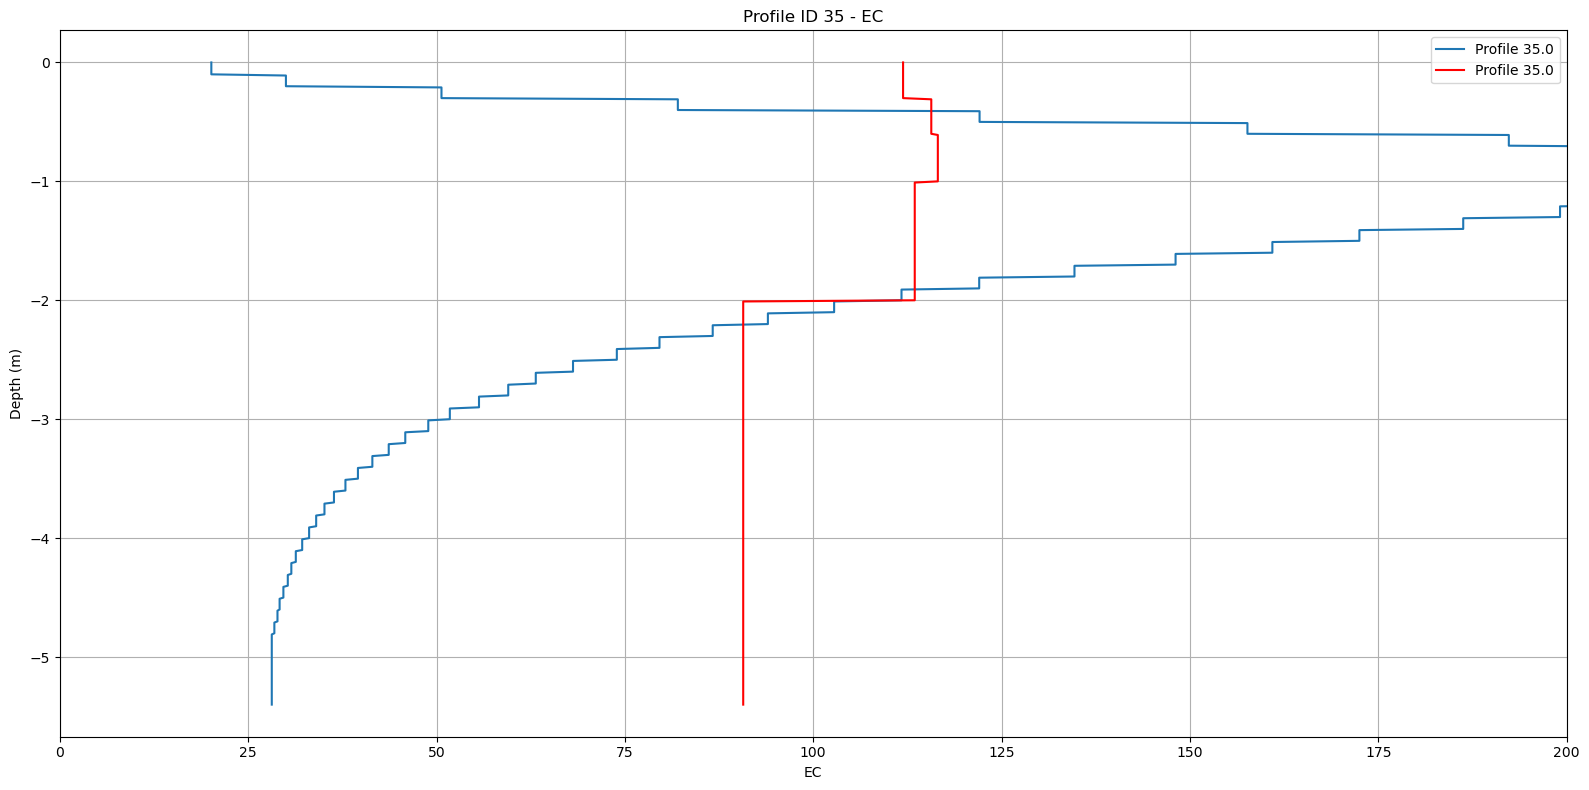

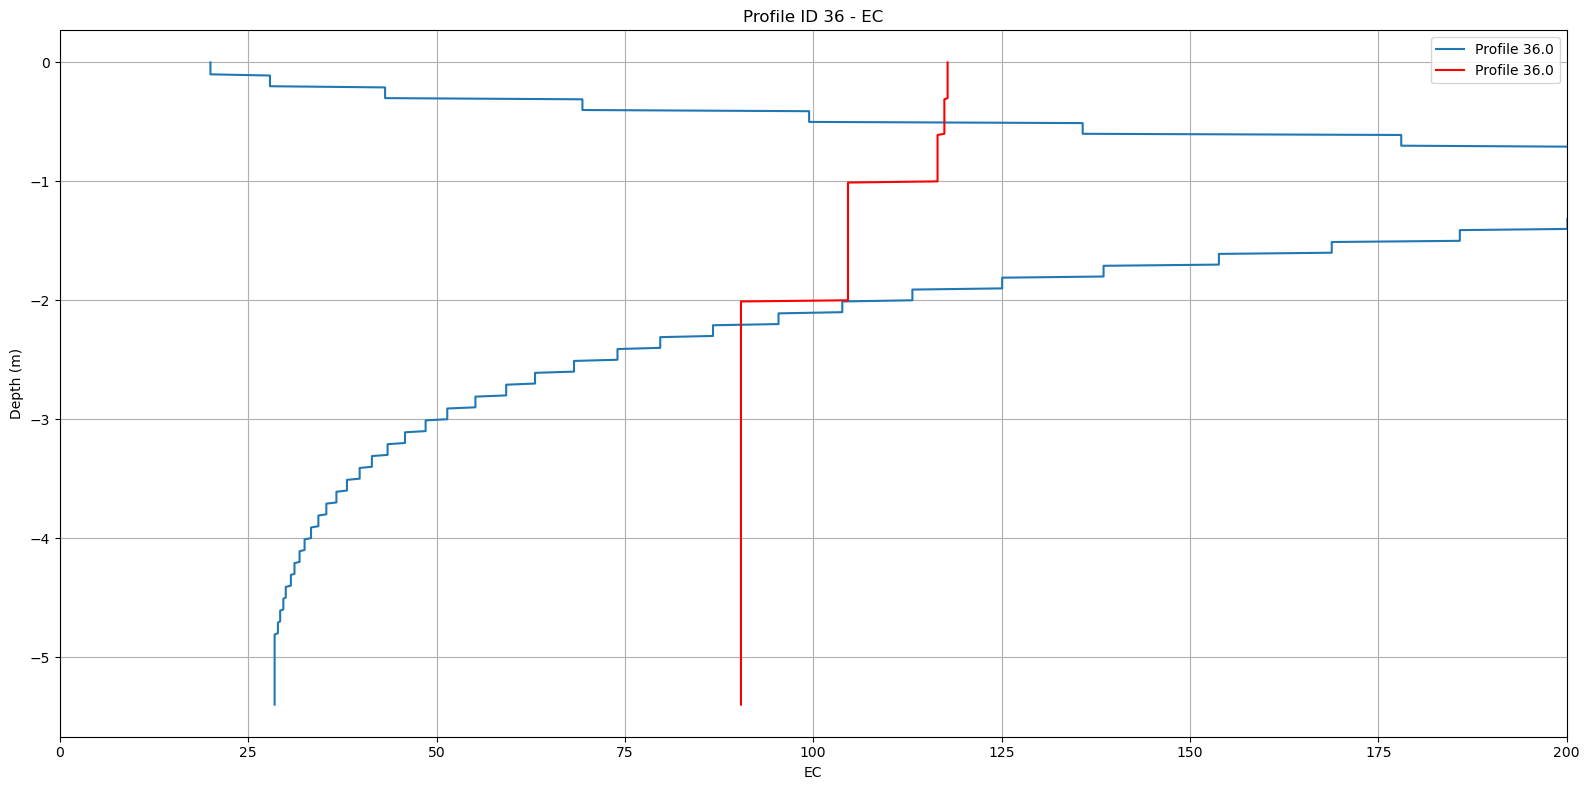

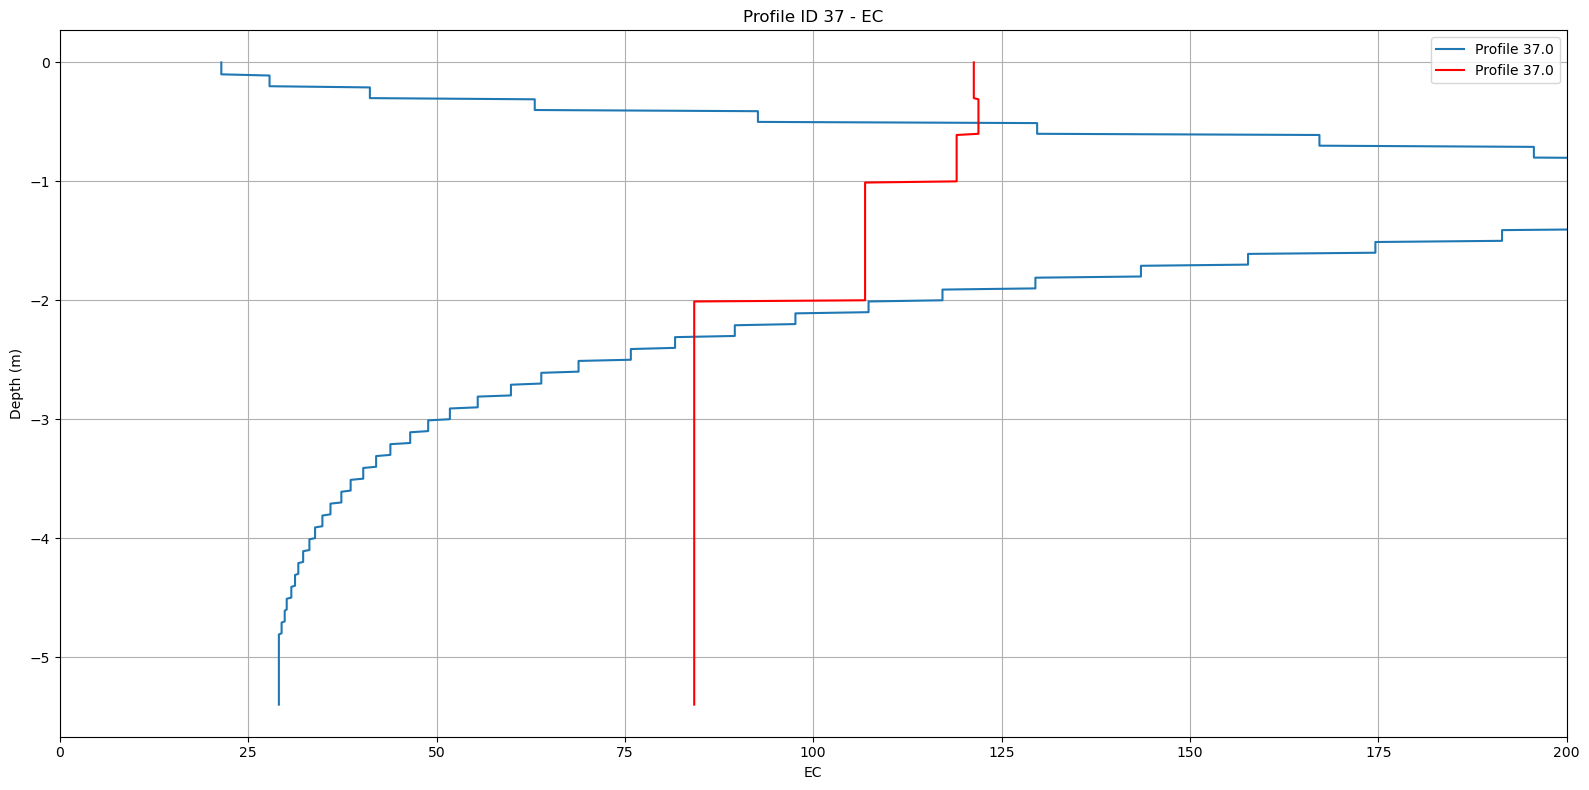

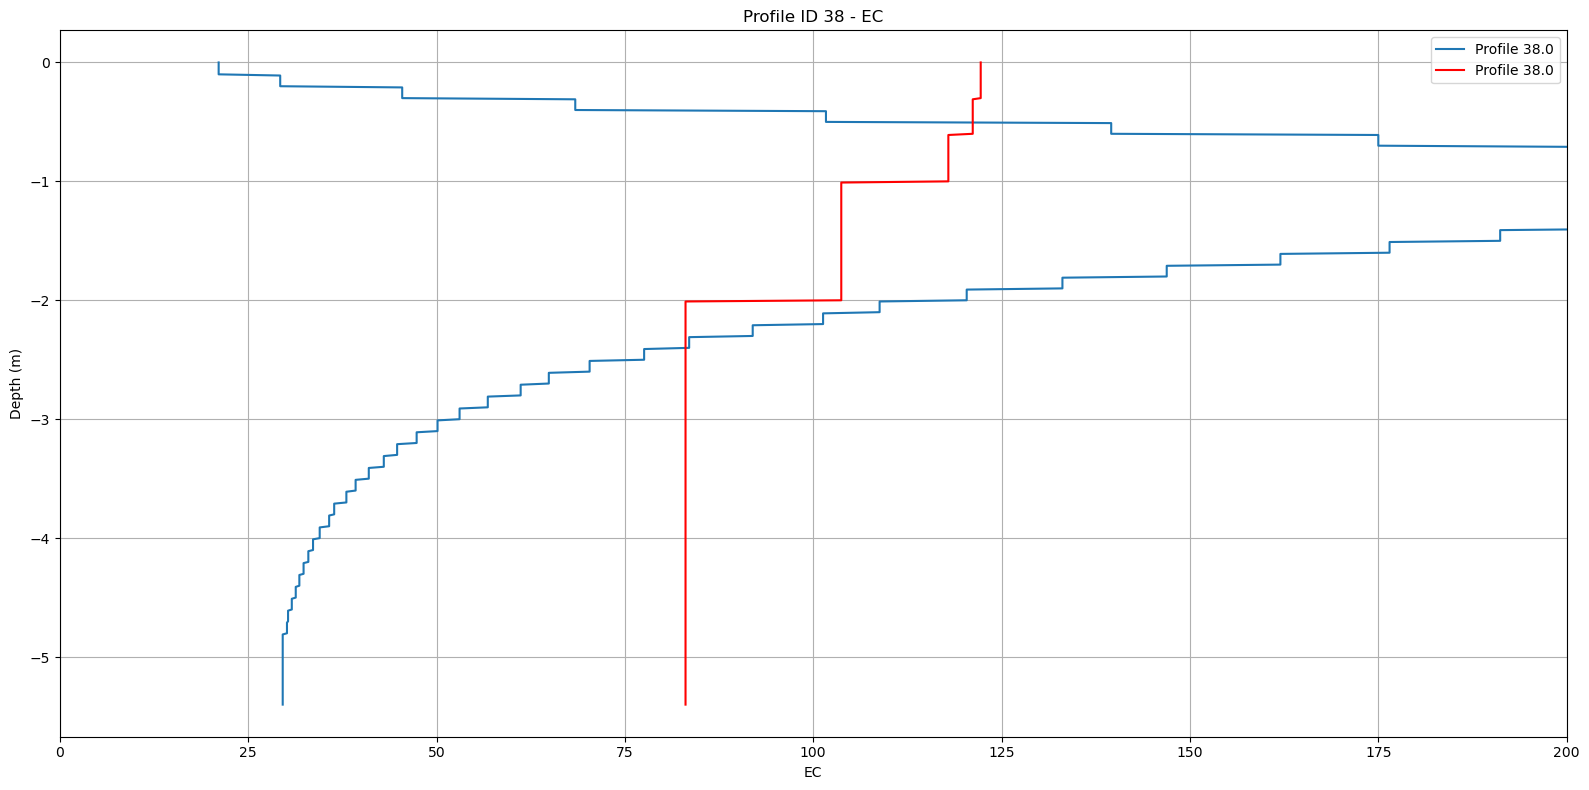

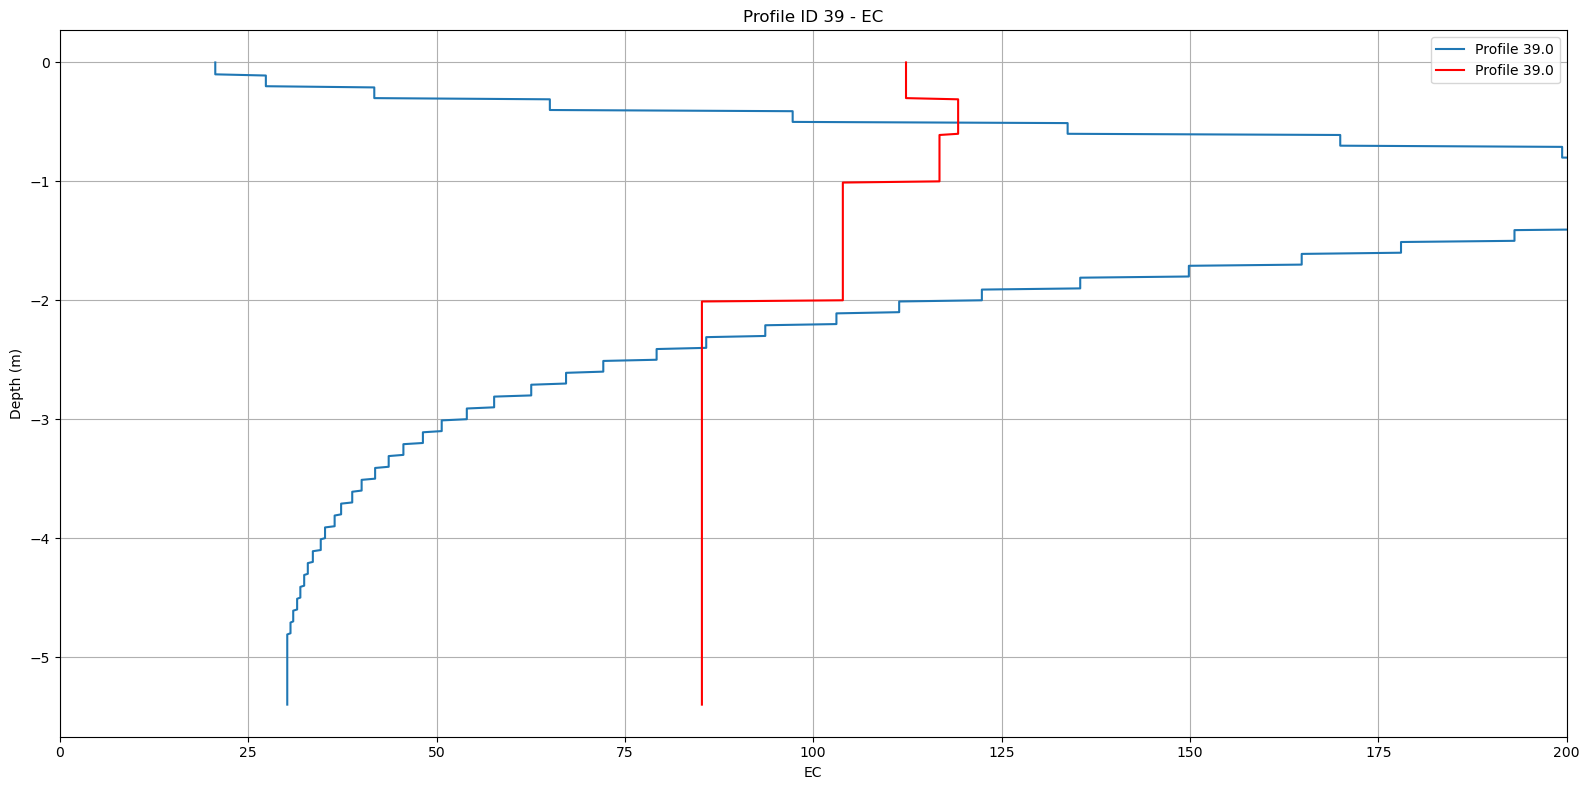

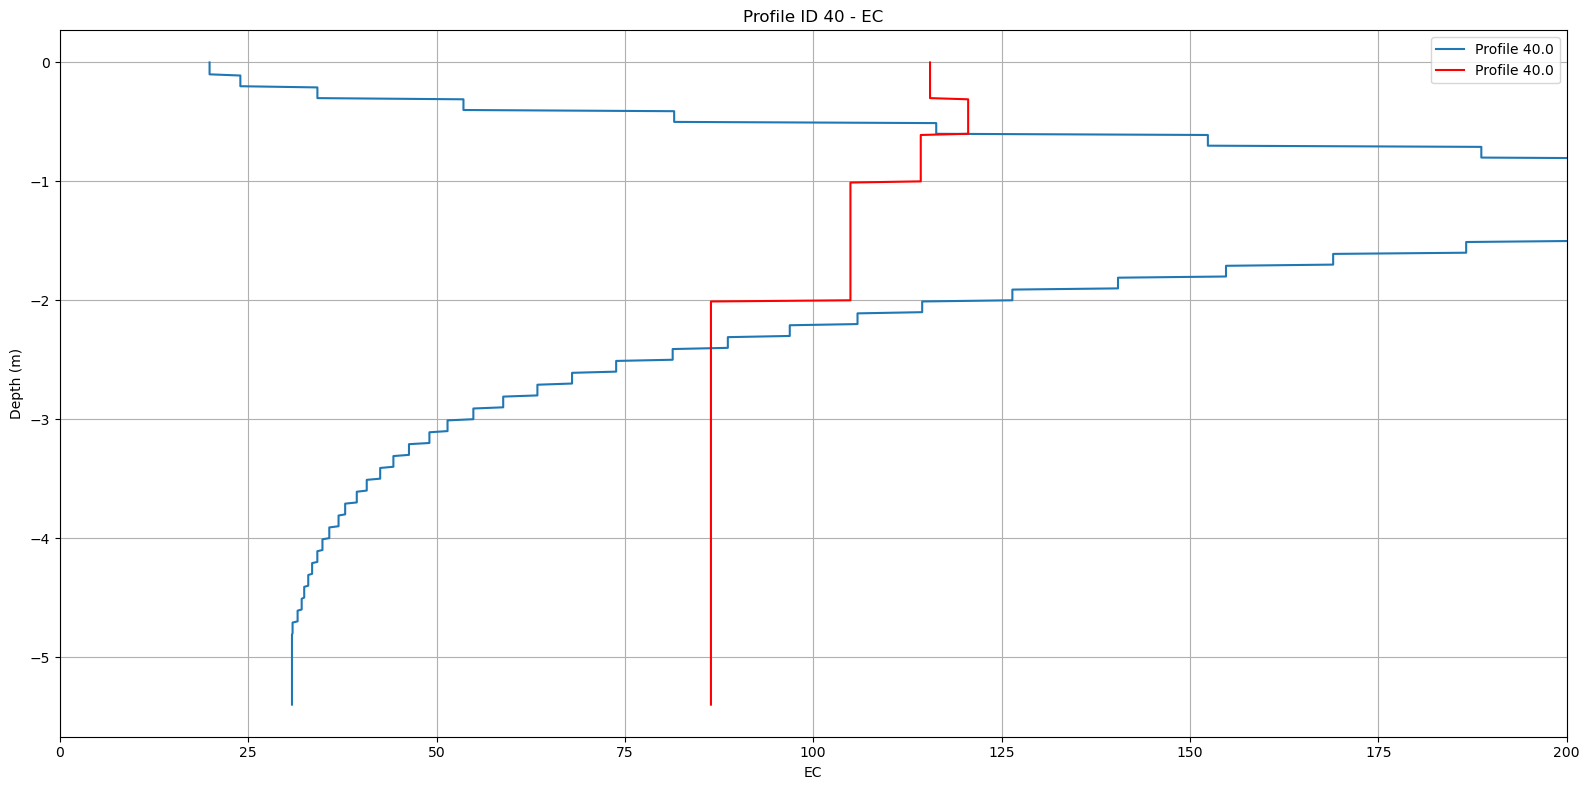

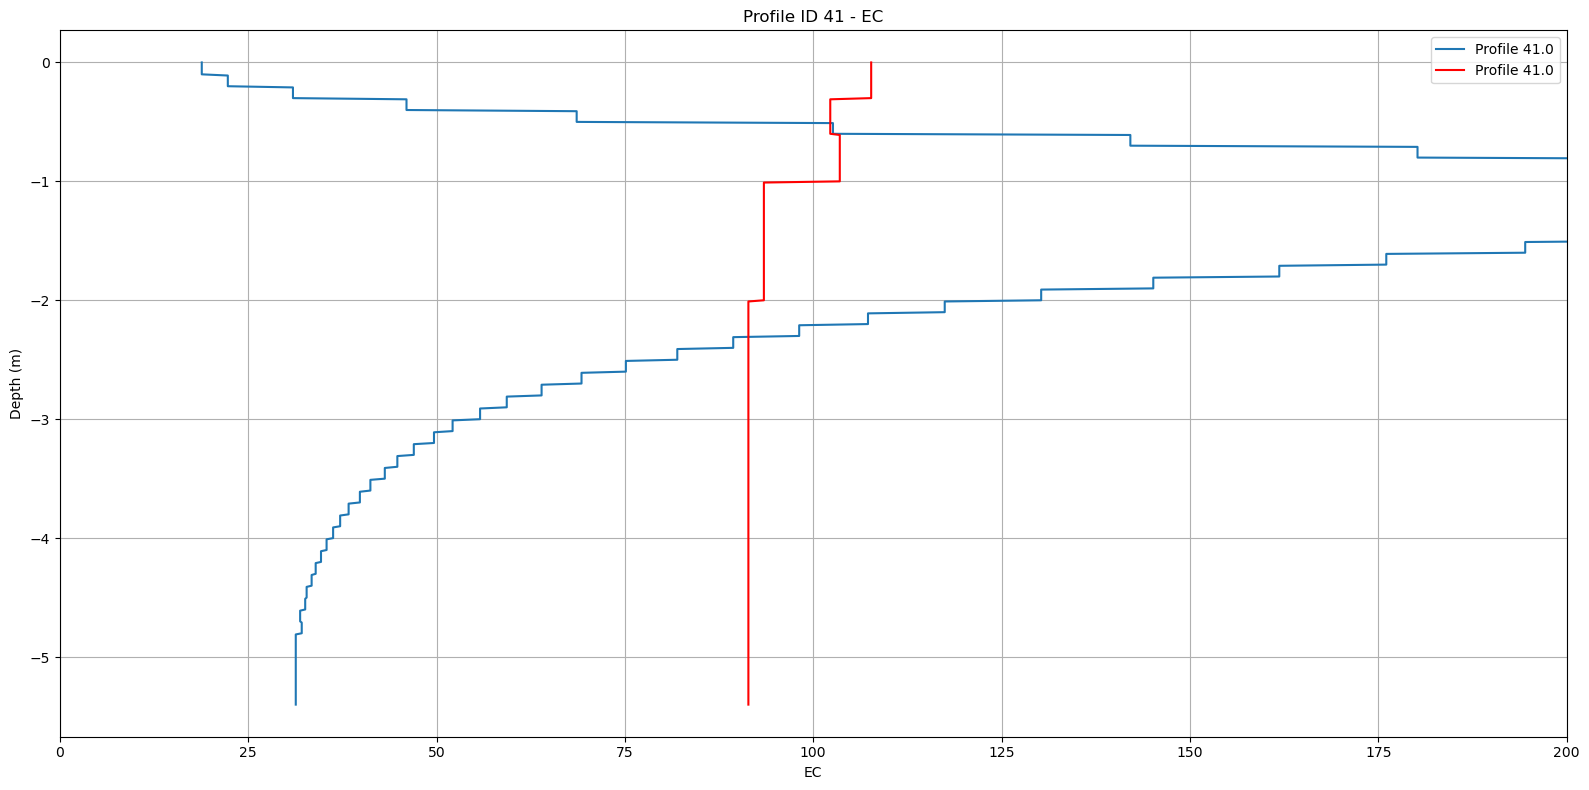

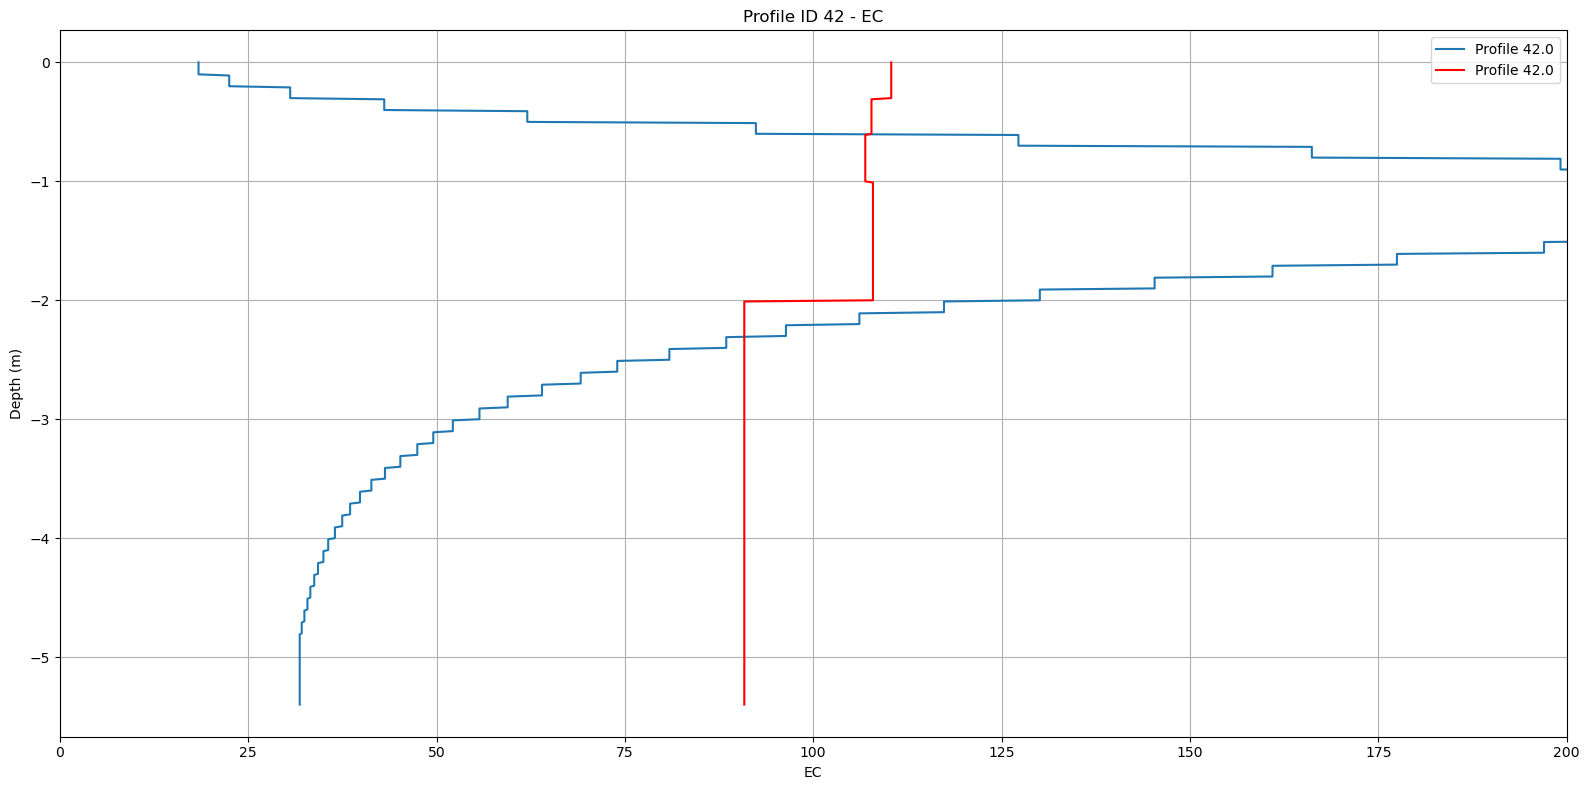

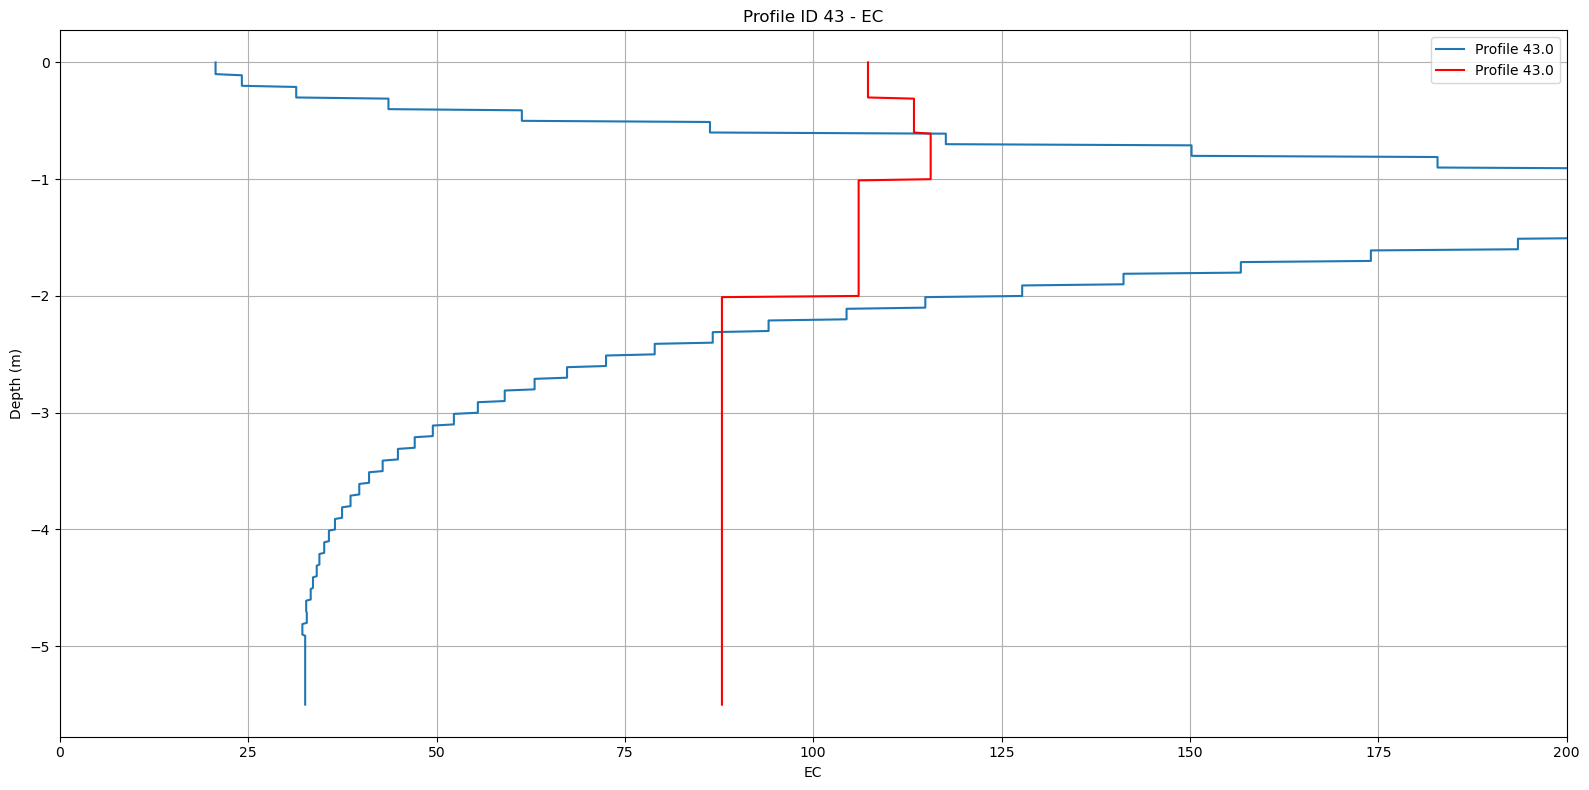

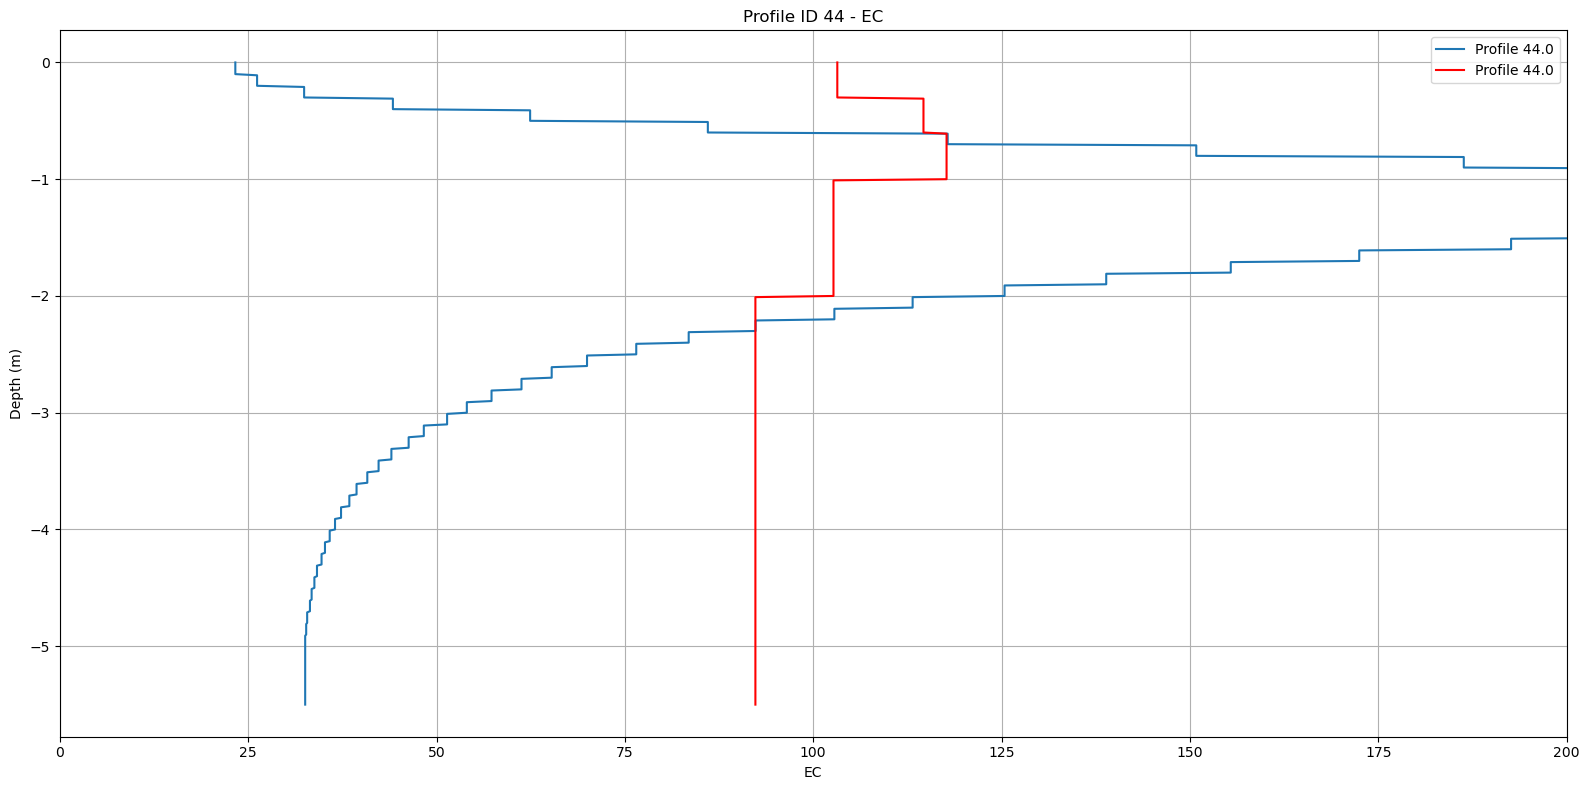

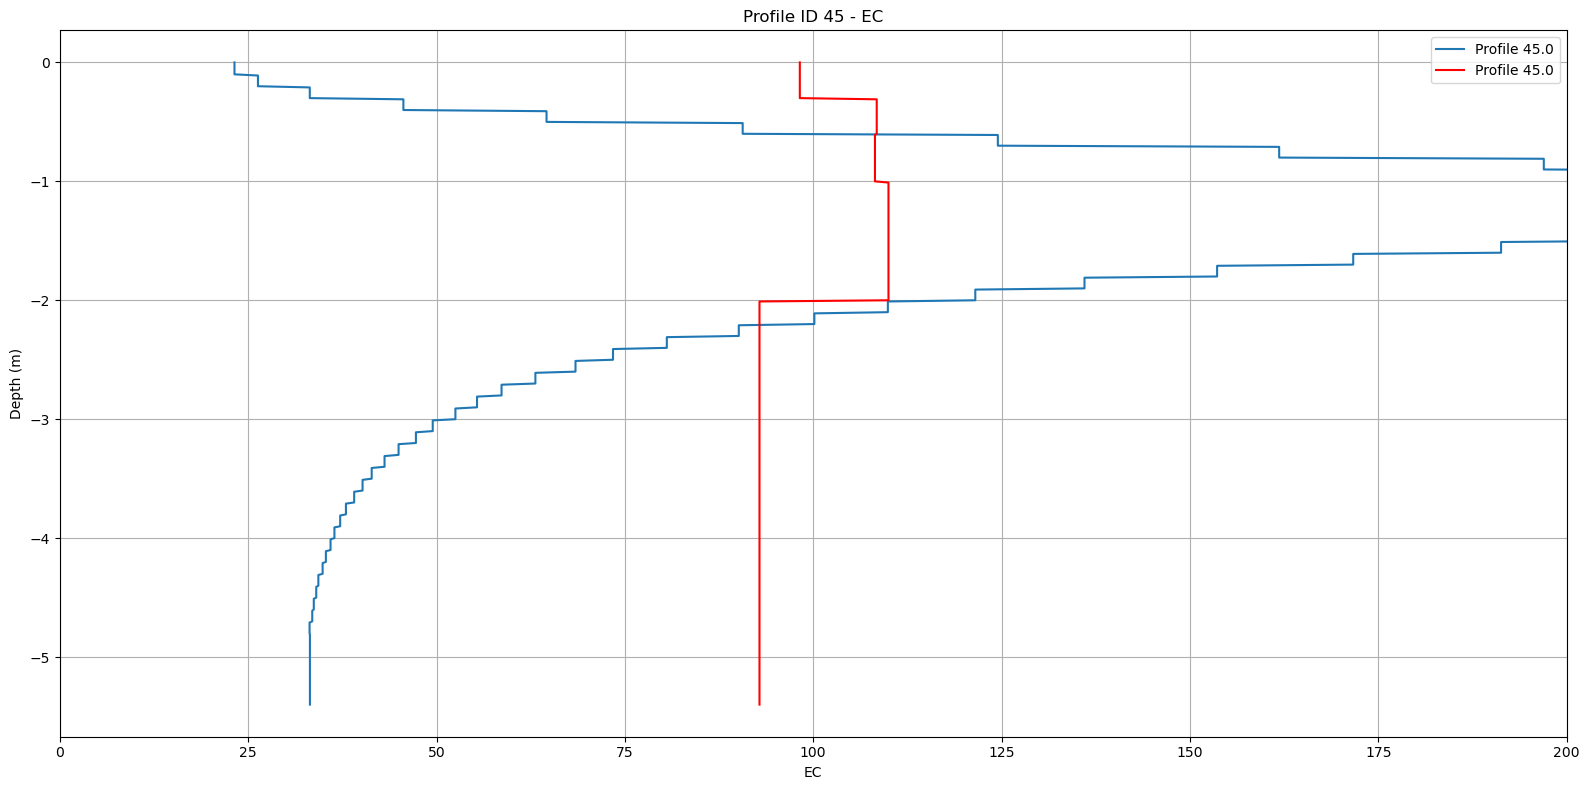

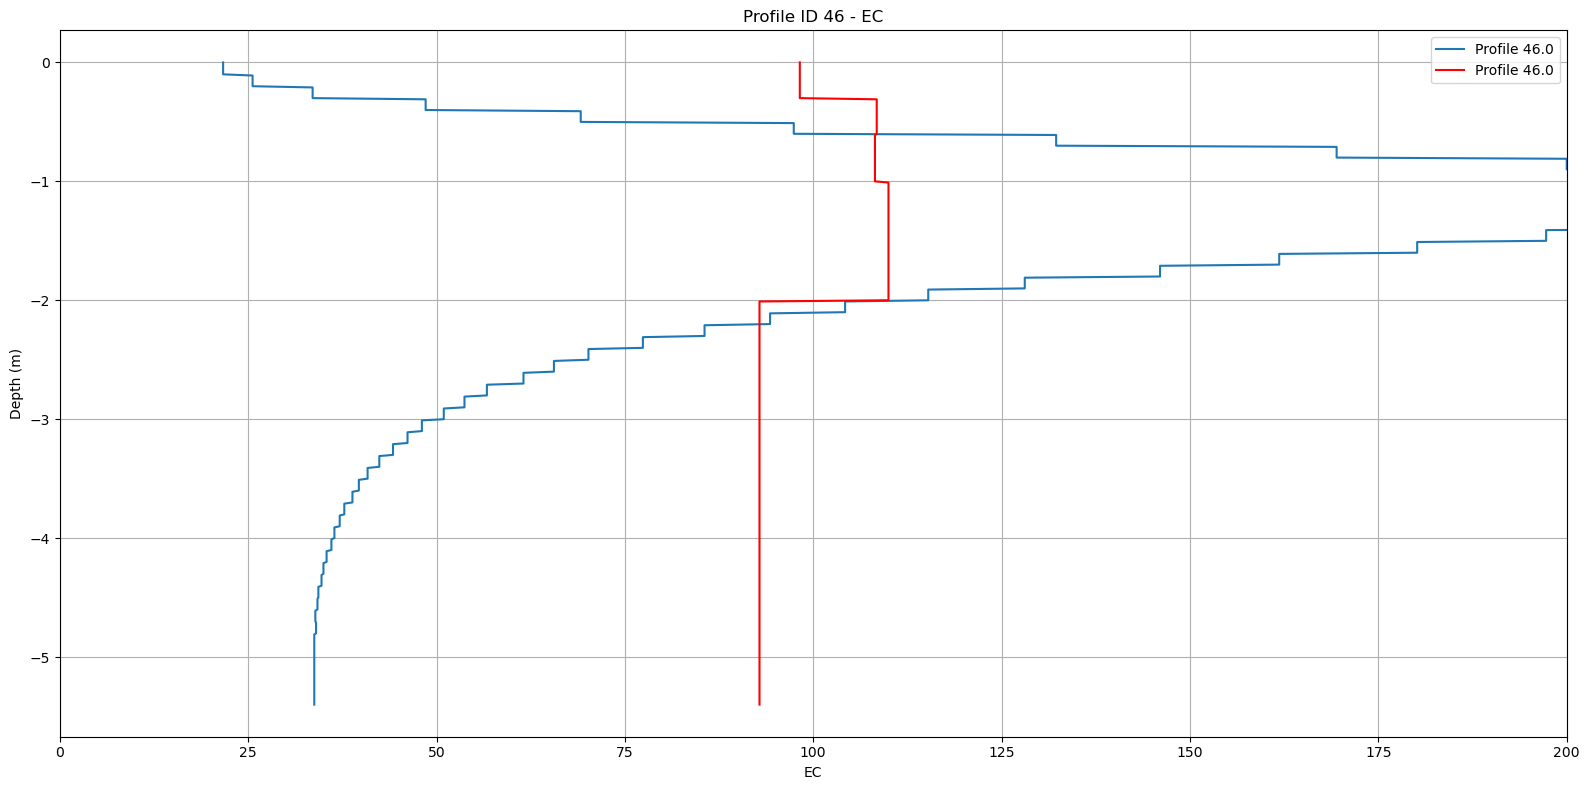

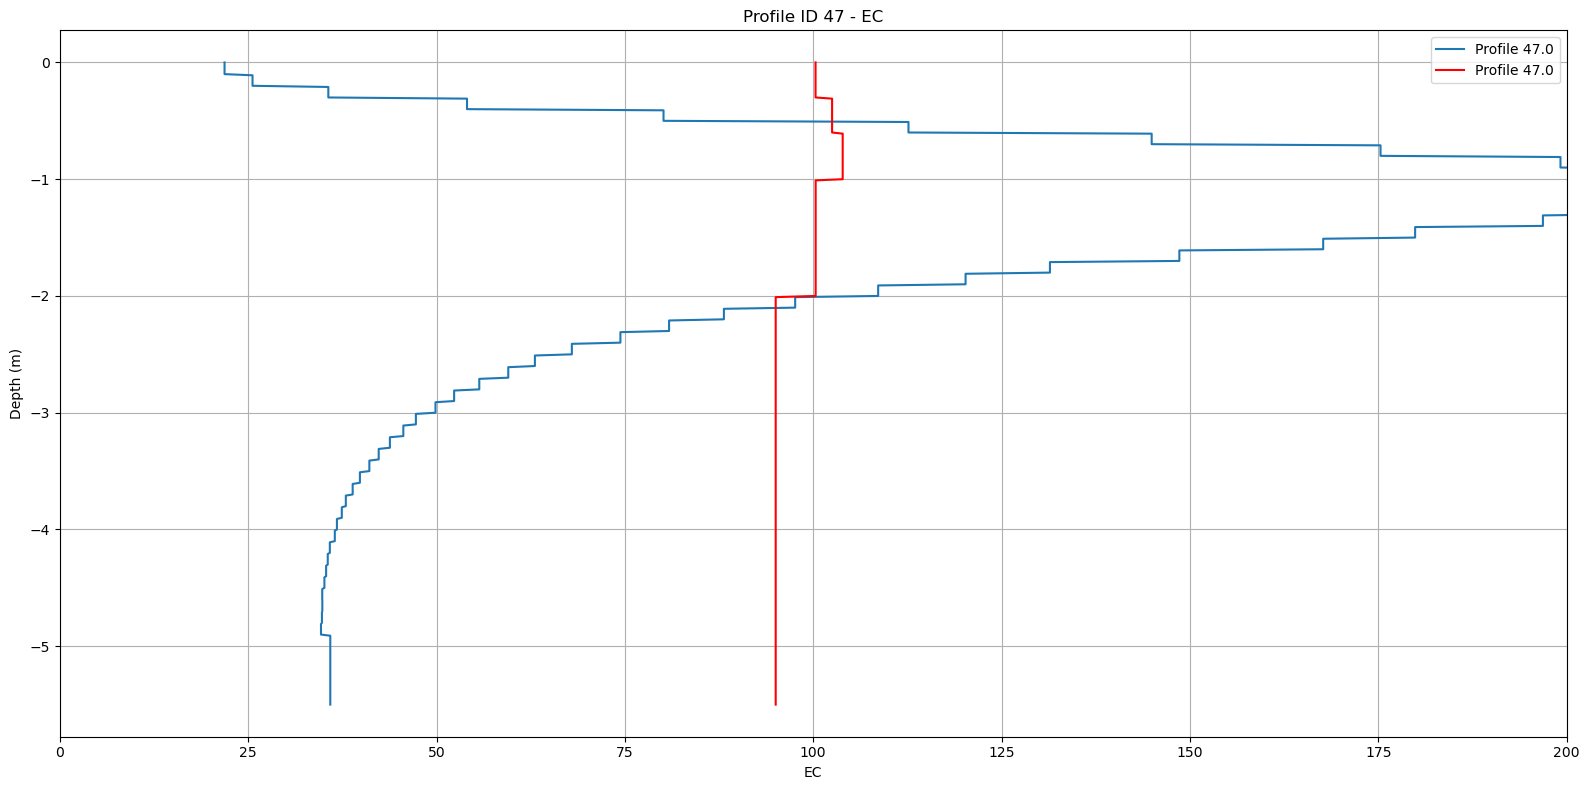

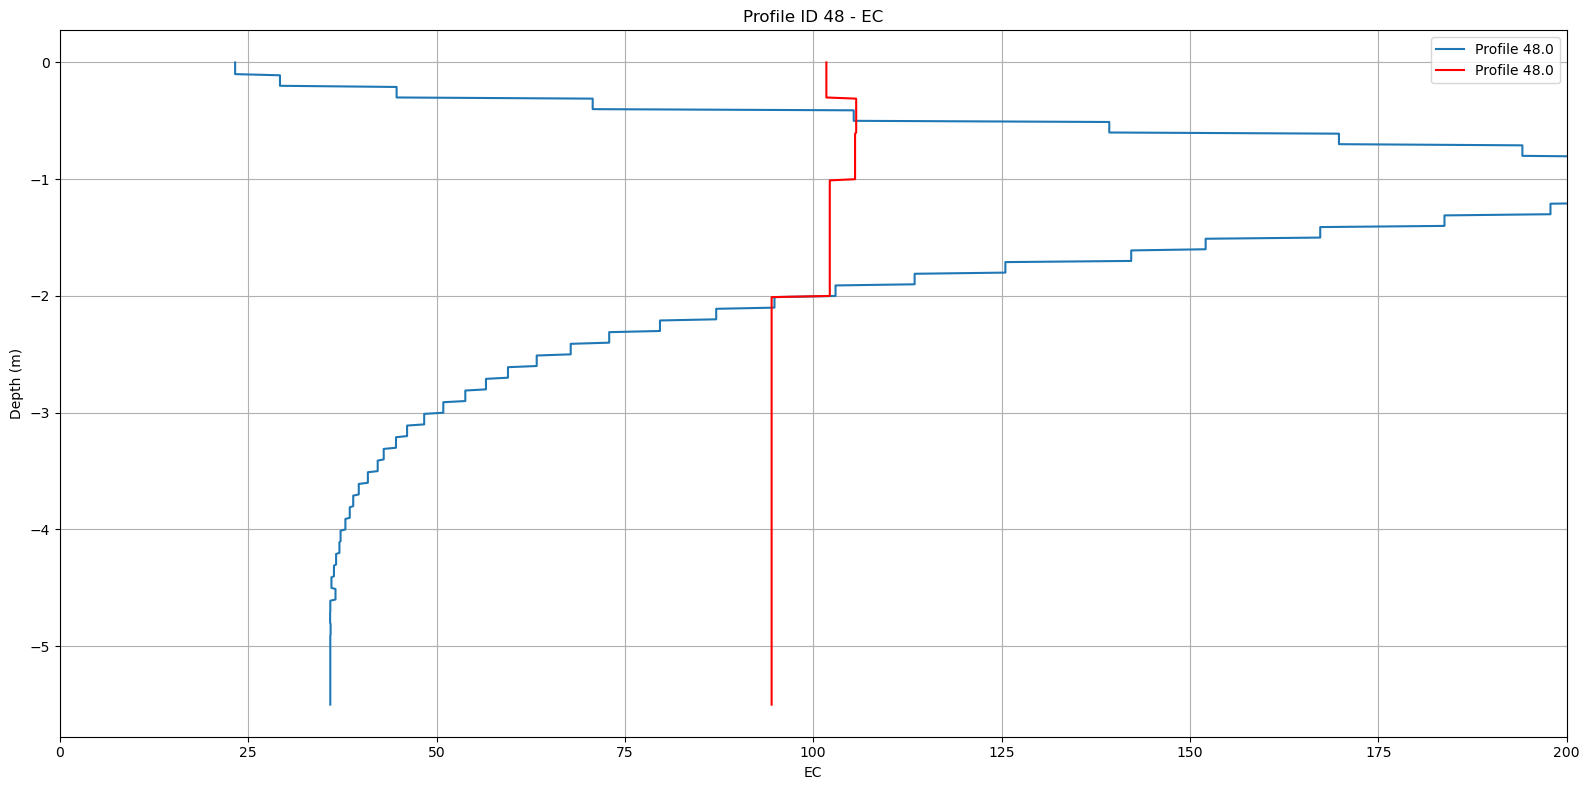

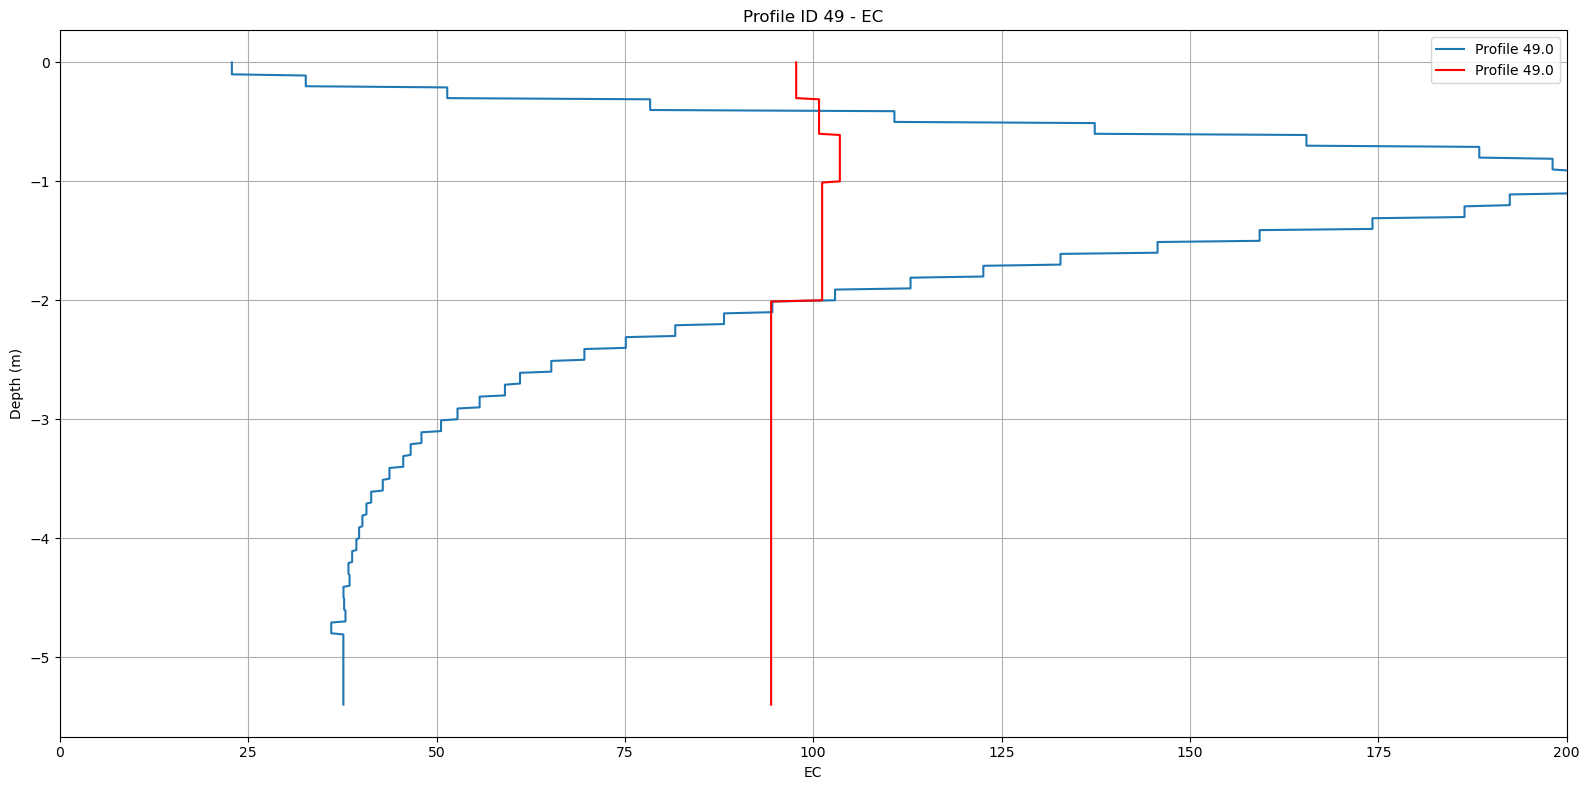

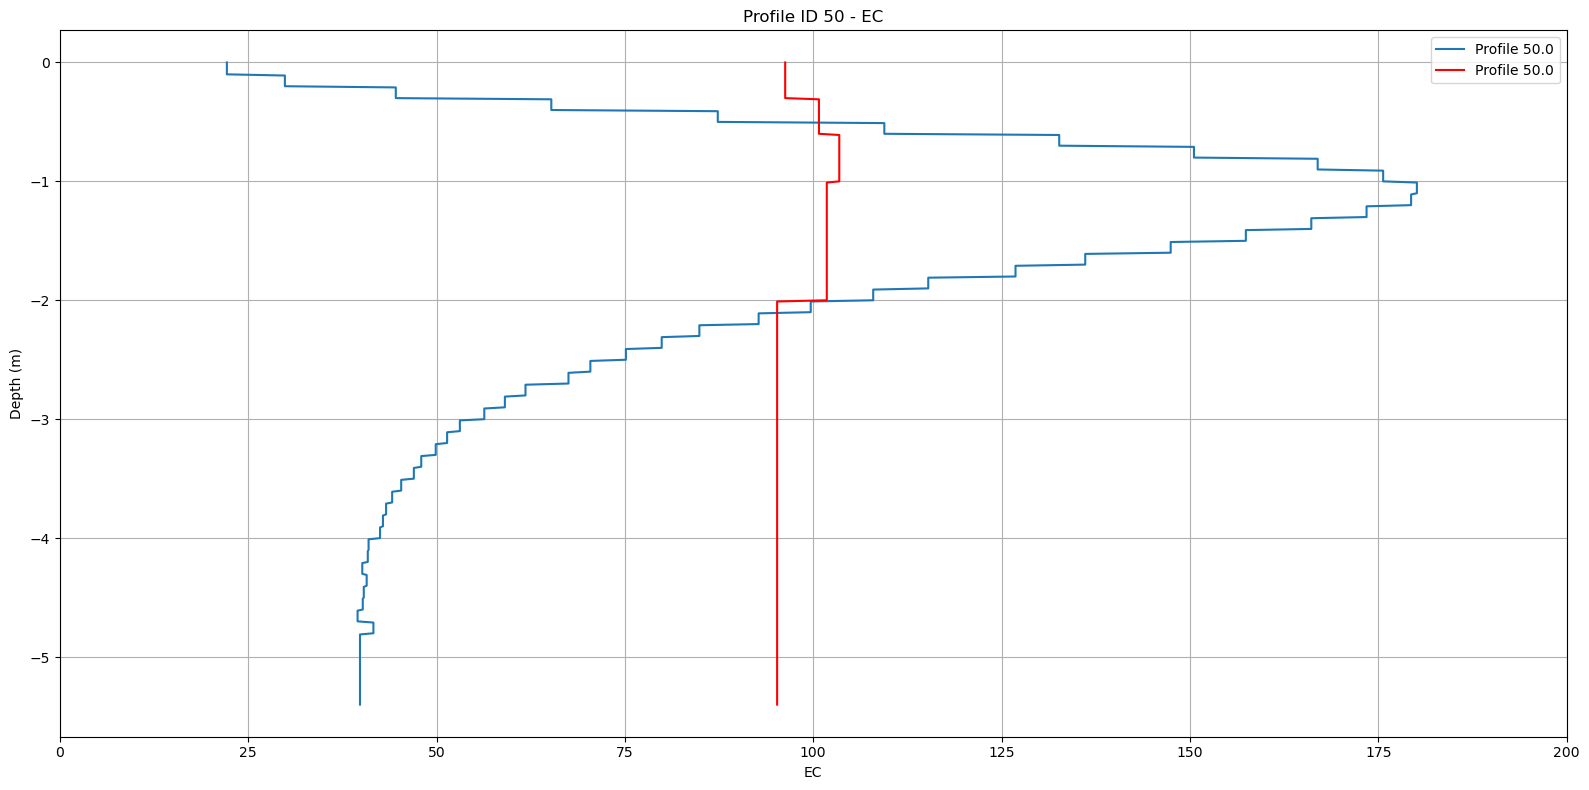

In [11]:
%autoreload

if not only_samples:
    # Function to extract depth from column name
    def extract_depth(col_name):
        if col_name.startswith('EC_'):
            return float(col_name.split('_')[1])
        return None

    # Extracting depth values and sorting them
    depth_cols = [col for col in dt_inv.columns if col.startswith('EC_')]
    depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
    depths.sort()

    # Calculate depth for 'EC_end'
    if depths:
        end_depth = depths[-1] + depths[0]
        depths.append(end_depth)

    # Creating the new DataFrame
    transformed_data = {
        'Z': [],
        'EC': [],
        'easting': [],
        'northing': [],
        'ID': []
    }

    # Populating the new DataFrame
    for _, row in dt_inv.iterrows():
        for depth, depth_col in zip(depths, depth_cols):
            transformed_data['Z'].append(-depth)
            transformed_data['EC'].append(row[depth_col])
            transformed_data['easting'].append(row['x'])
            transformed_data['northing'].append(row['y'])
            transformed_data['ID'].append(row['pos'])

    transformed_df = pd.DataFrame(transformed_data)

    pdf_files = []
    inv_meth = config['fs_emp']
    for i in transformed_df['ID'].unique():
        profile_label = str(i)
        if '.0' in profile_label:
            profile_label = profile_label.split('.')[0]
        filename = plot_profile(dc_corr, i, dataset_name,
                    compare=True, compare_df = transformed_df, compare_name = 'EC',
                    xlims=(0,200),
                    block=True,
                    save_plot = True, 
                    plot_name = f'{inv_meth}_inversion_p{profile_label}'
                    ) # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):
        
        pdf_files.append(filename)

    # Merge and save PDFs
    merger = PdfMerger()
    for pdf in pdf_files:
        merger.append(pdf)
    merged_pdf_filename = f'{now}_{emfile_prefix}_{inv_meth}_transect.pdf'
    outfile_transect_pdf = os.path.join(inv_folder, merged_pdf_filename)
    merger.write(outfile_transect_pdf)
    merger.close()
    for pdf in pdf_files:
        os.remove(pdf)
    clear_output(wait=False)

In [12]:
# Perform inversion on sampling locations (to be used in pedophysical modelling)

if 'code' in em_samples.columns:
    em_samples = em_samples.rename(columns={'code': 'ID'})

# if config['n_omit'] != 0:
#     unique_ids = em_input['ID'].unique()
#     print(unique_ids)
#     selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
#     em_input = em_input.loc[em_input['ID'].isin(selected_ids)]

temp_dir = 'temp_emp_02' 
infile_name = 'infile_s02.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
n = 4
em_samples.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_samples.columns.values[n:n+i] = new_columns

em_samples.to_csv(temp_file)
print('em_samples', em_samples)
print('mod_layers', mod_layers)
print('conductivities', conductivities)

# transect inversion settings

s_rec = Problem()
s_rec.createSurvey(temp_file)
#t_rec.rollingMean(window=12)

s_rec.setInit(
    depths0=np.flipud(mod_layers),
    conds0=conductivities
    # fixedDepths=startmodel['fixedDepths'],
    # fixedConds=startmodel['fixedConds']
    )
#print(np.flipud(mod_layers), conductivities)

#shutil.rmtree(temp_dir)

if config['remove_coil']:
    if type(config['coil_n']) == list:
        config['coil_n'] = sorted(config['coil_n'])
        for i in enumerate(config['coil_n']):
            r_coil = s_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
            s_rec.removeCoil(config['coil_n'][i[0]]-i[0])
    else:
        s_rec.removeCoil(config['coil_n'])

print(f'Data used for inversion: {s_rec.coils}')

em_samples                    x              y          z         t  HCP1.0f9000h0.165  \
2647   107720.422475  183327.165273  26.201000  33302.50          55.049289   
10002  107756.481771  183331.583499  26.731814  34904.54          20.999151   
11164  107798.679042  183279.309539  27.950000  35136.95         114.118495   
9695   107763.888389  183317.830874  27.235485  34843.16          14.686379   
788    107723.148401  183308.909654  26.699000  32930.71          68.744006   
6854   107741.766035  183329.347640  26.403000  34144.13          42.029942   
11575  107806.104685  183273.870393  28.659261  35219.15         124.020511   
7909   107758.569123  183312.798271  27.350000  34485.90          21.073937   
11008  107776.575053  183310.642459  26.990019  35105.74          62.594615   
2714   107727.526041  183319.347288  26.622000  33315.92          84.181696   
11409  107767.495210  183328.069628  27.164000  35185.32          22.397037   
9737   107776.924149  183299.388370  27.6

Inversion using FSeq with L-BFGS-B, reg=l2, alpha=0.07
15/15 inverted

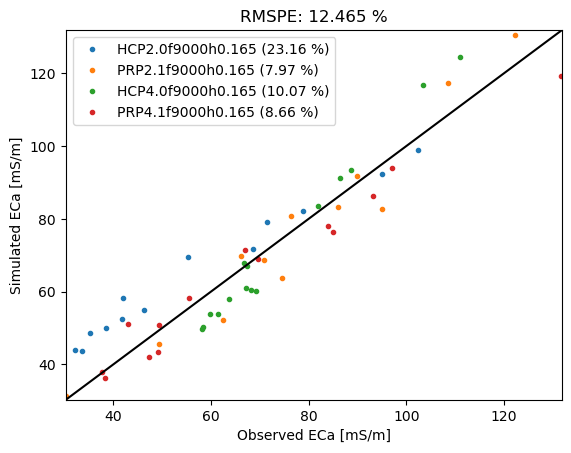

In [13]:
# invert using ROPE solver (RObust Parameter Estimation)
warnings.filterwarnings('ignore')
opt_meth = config['opt_method']
inv_meth = config['fs_emp']
reg_meth = config['regularization']
alph_param = config['alpha']
if opt_meth in ['MCMC', 'ROPE']:
    if config['constrain']:
        print(f'Constrained inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        s_rec.invert(forwardModel=config['fs_emp'], method=opt_meth, 
                regularization=reg_meth, alpha=alph_param, 
                bnds=bounds
                )
    else:
        print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        s_rec.invert(forwardModel=config['fs_emp'], method=opt_meth, 
        regularization=reg_meth, alpha=alph_param, njobs=-1
        )

else:
    print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
    s_rec.invert(forwardModel='FSeq', method='Gauss-Newton', alpha=alph_param,regularization=reg_meth)
s_rec.showOne2one()

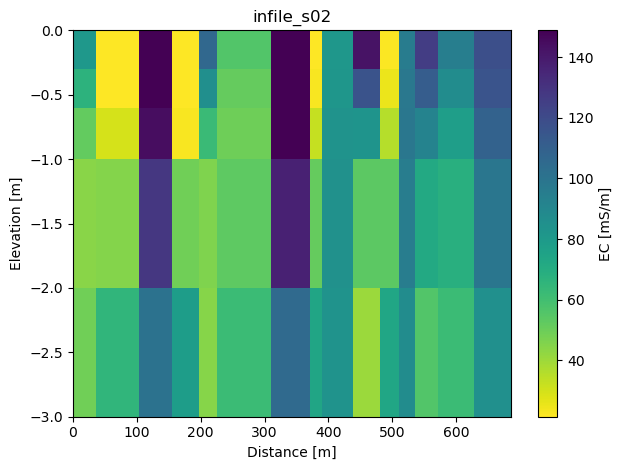

In [14]:
# 4.1: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------
csv_filename = f'{now}_{emfile_prefix}_inverted_samples_{opt_meth}_02.csv'

# ******************************************************************** #

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).
s_rec.showResults(dist=True, errorbar = True) 

# Extracting the values from the first row of the transect.depths[0] array
depth_values = s_rec.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[s_rec.surveys[0].df[['x', 'y']].values, s_rec.models[0]]

# Creating the final dataframe with the desired column names
ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
ds_inv['pos'] = em_samples['ID'].to_numpy()
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
outfile_transect = os.path.join(inv_folder, csv_filename)
ds_inv.to_csv(outfile_transect)

               x              y     EC_0.30     EC_0.60     EC_1.00  \
0  107720.422475  183327.165273   80.674911   66.922209   52.171989   
1  107756.481771  183331.583499   20.543765   21.720094   29.420818   
2  107798.679042  183279.309539  148.380443  149.778652  144.662861   
3  107763.888389  183317.830874    1.224403    6.998888   22.865977   
4  107723.148401  183308.909654  106.323021   85.841526   62.638847   

      EC_2.00      EC_end  pos  
0   43.965447   48.837342    1  
1   45.171129   65.487774    2  
2  128.516257  100.979606    3  
3   48.960148   78.216035    4  
4   46.247348   44.684158    5  


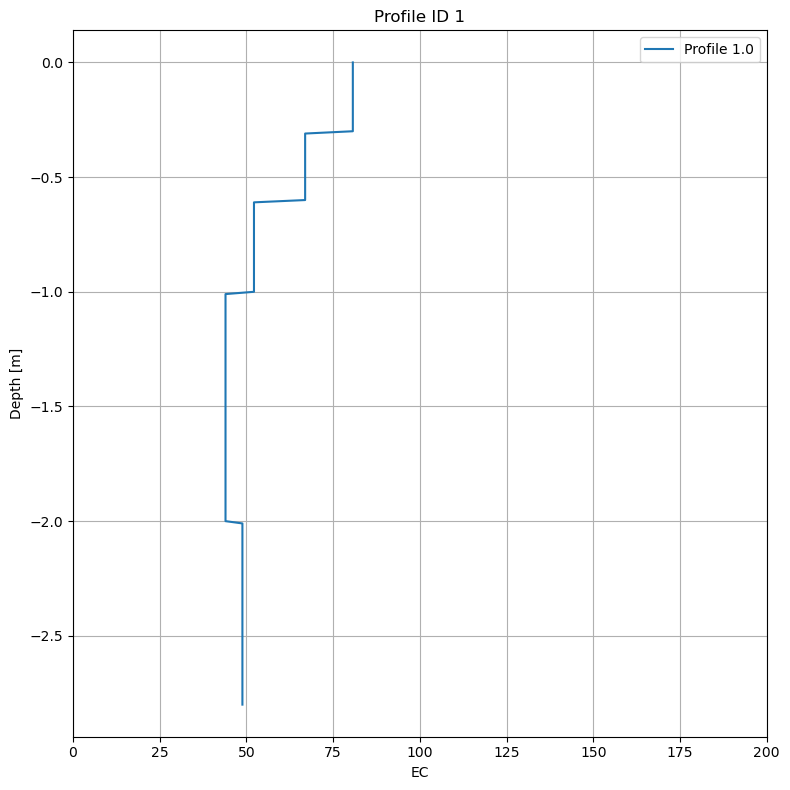

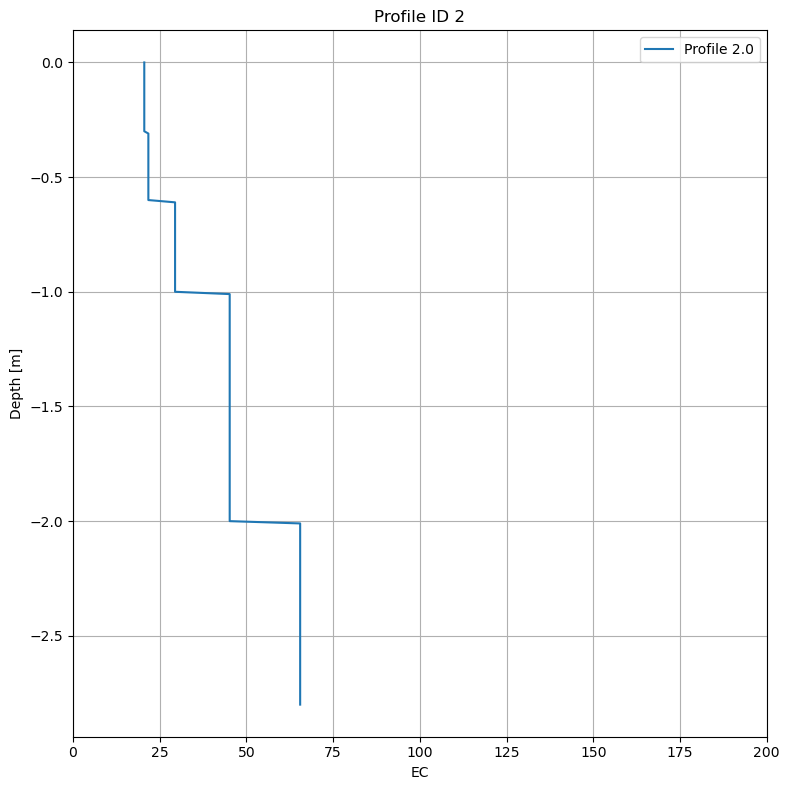

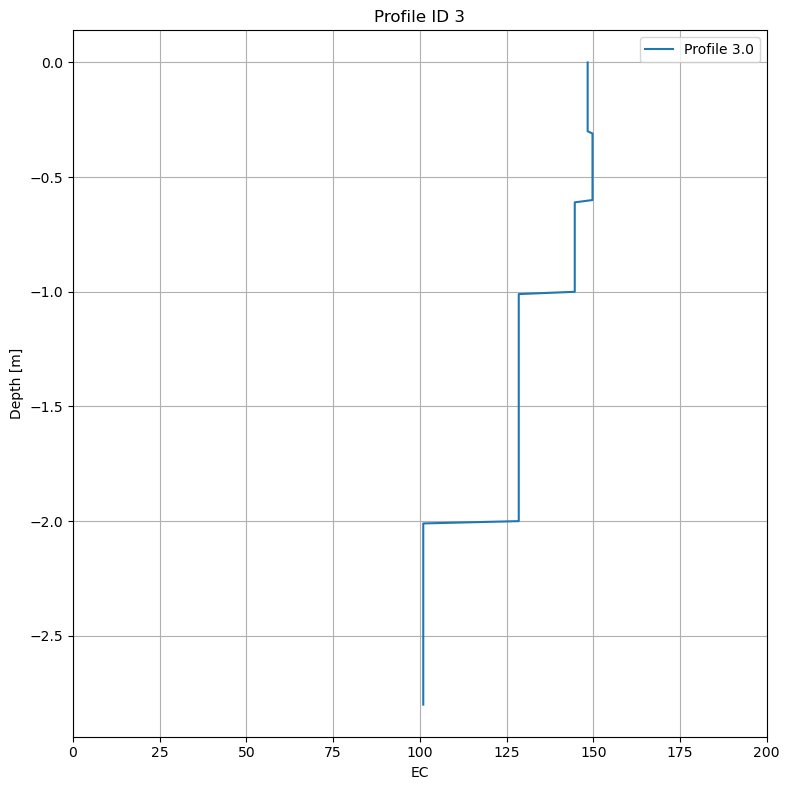

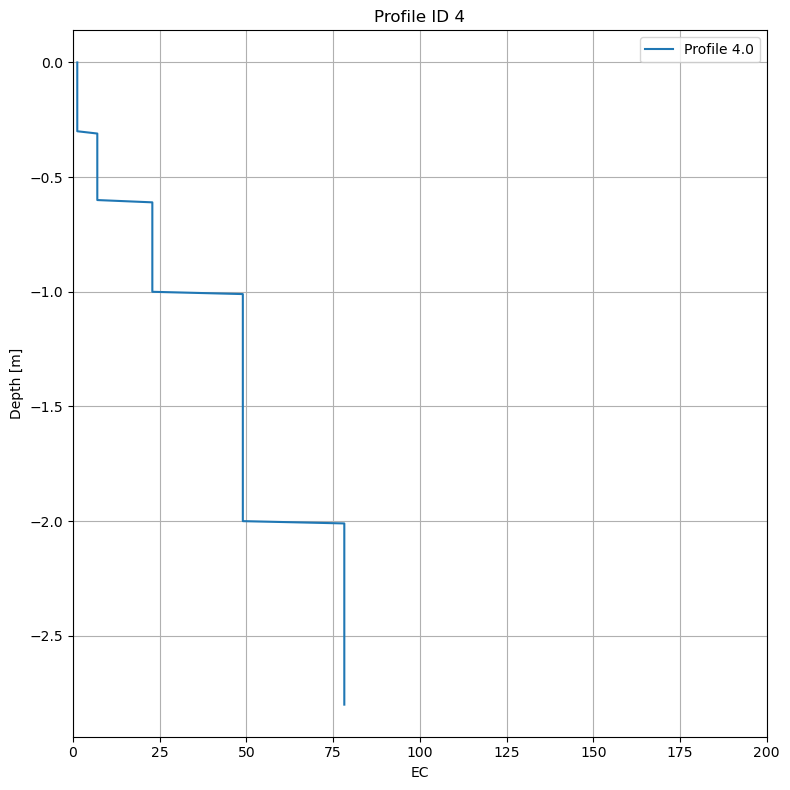

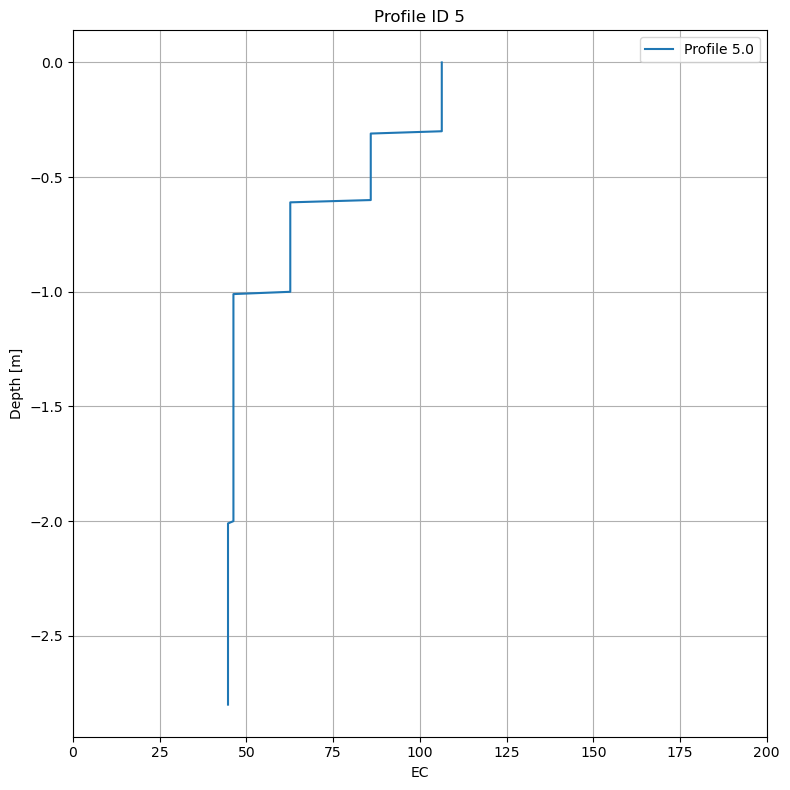

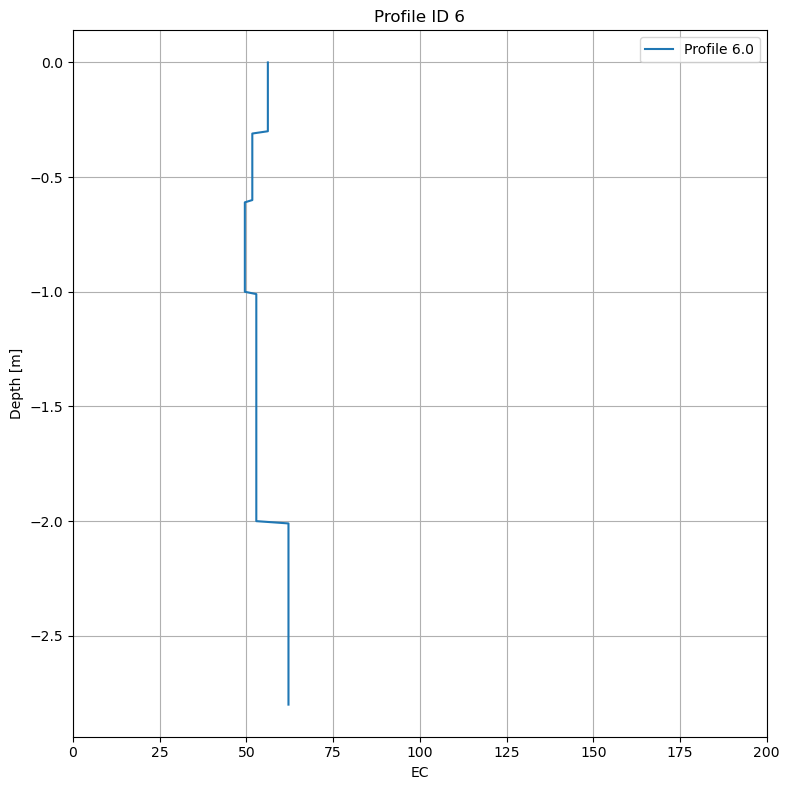

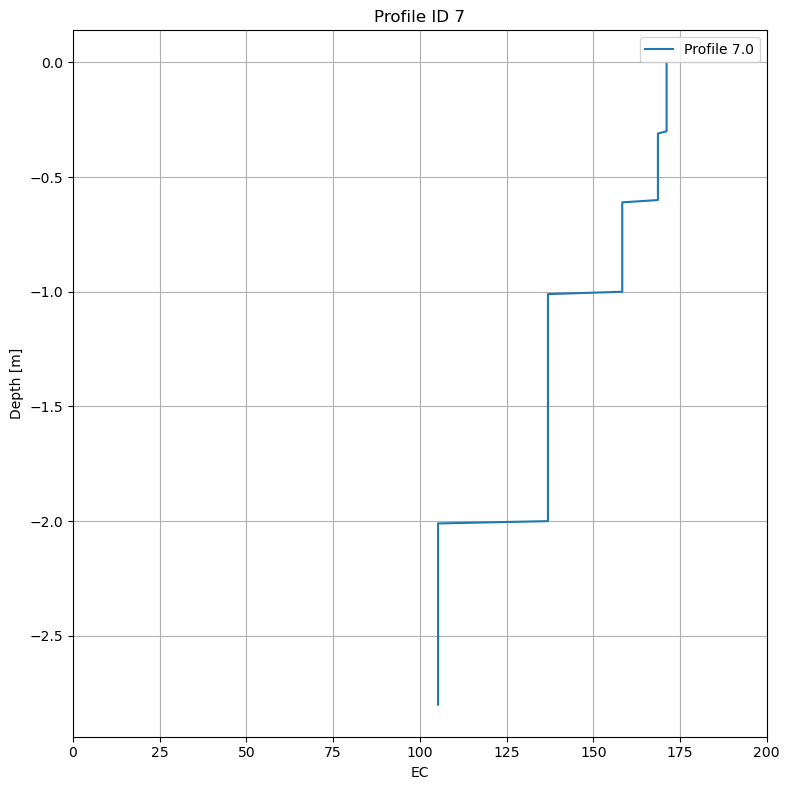

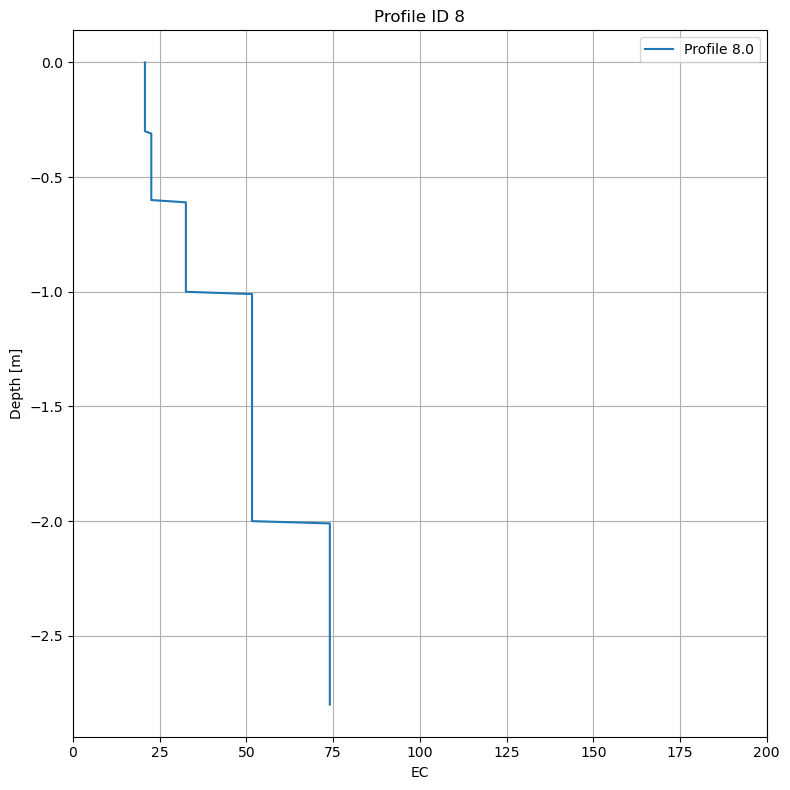

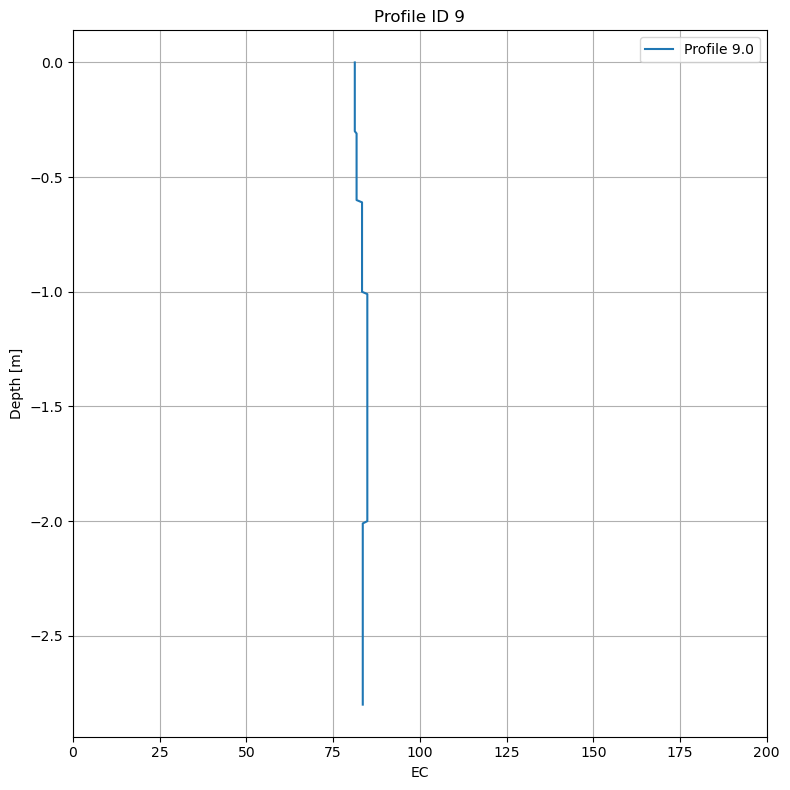

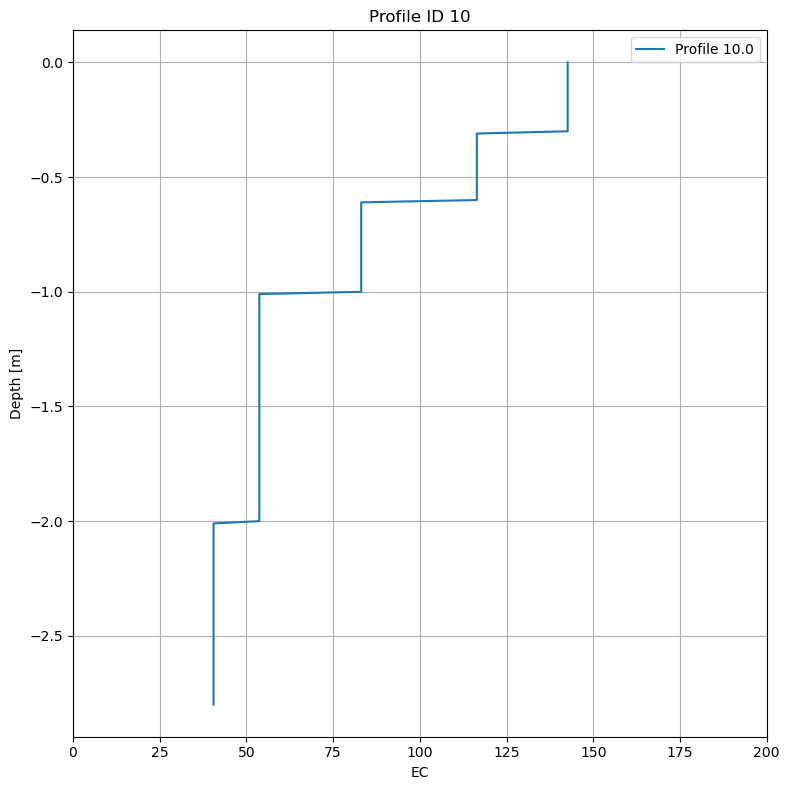

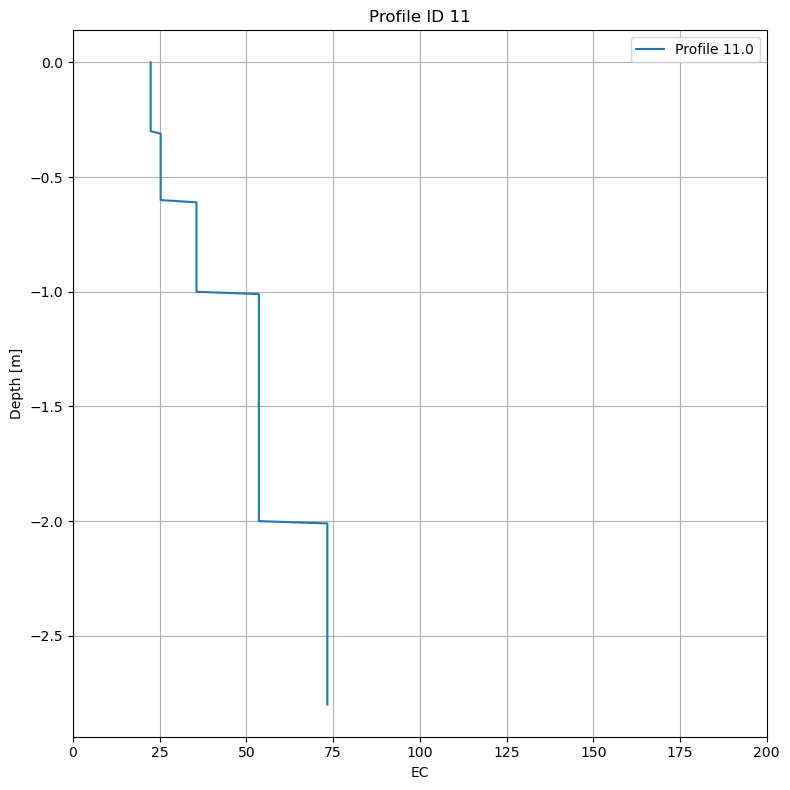

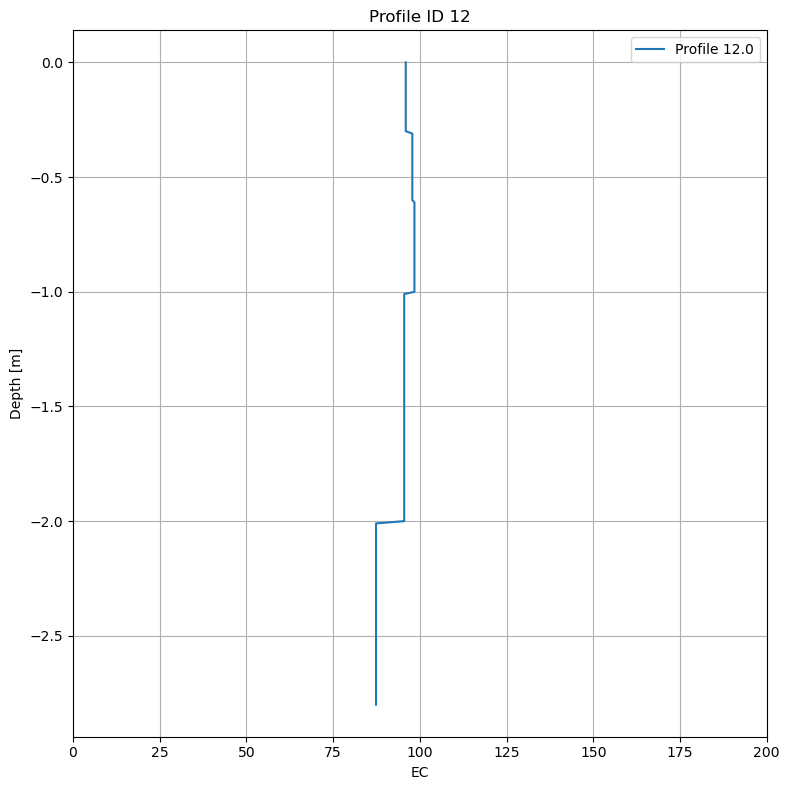

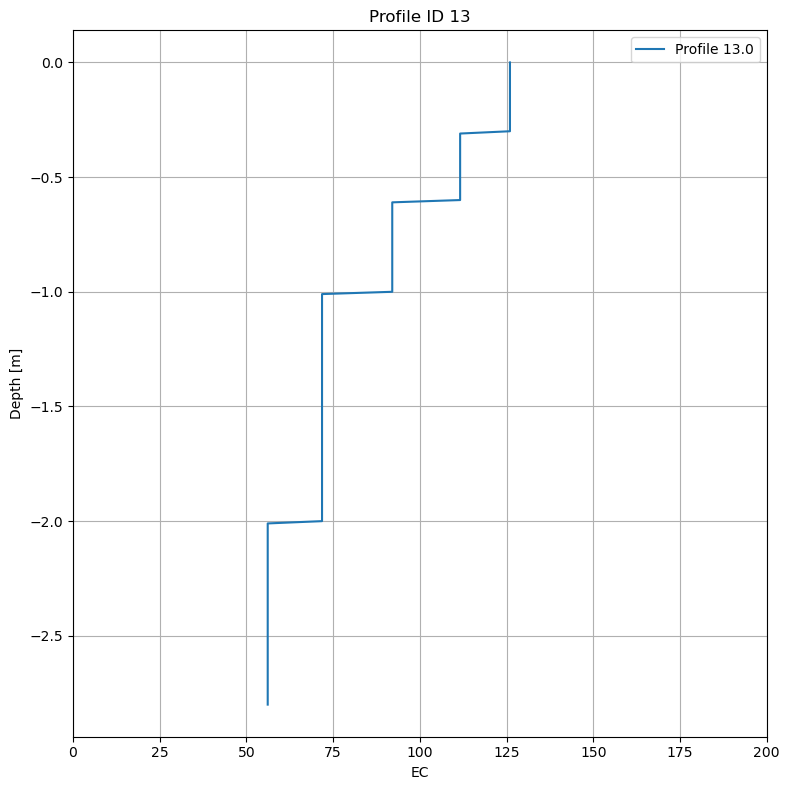

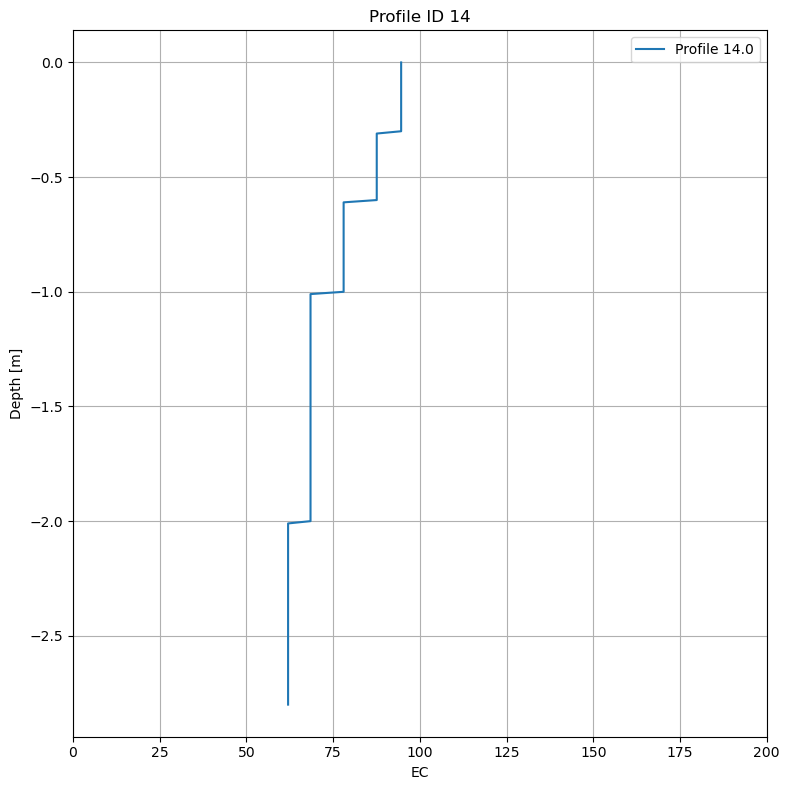

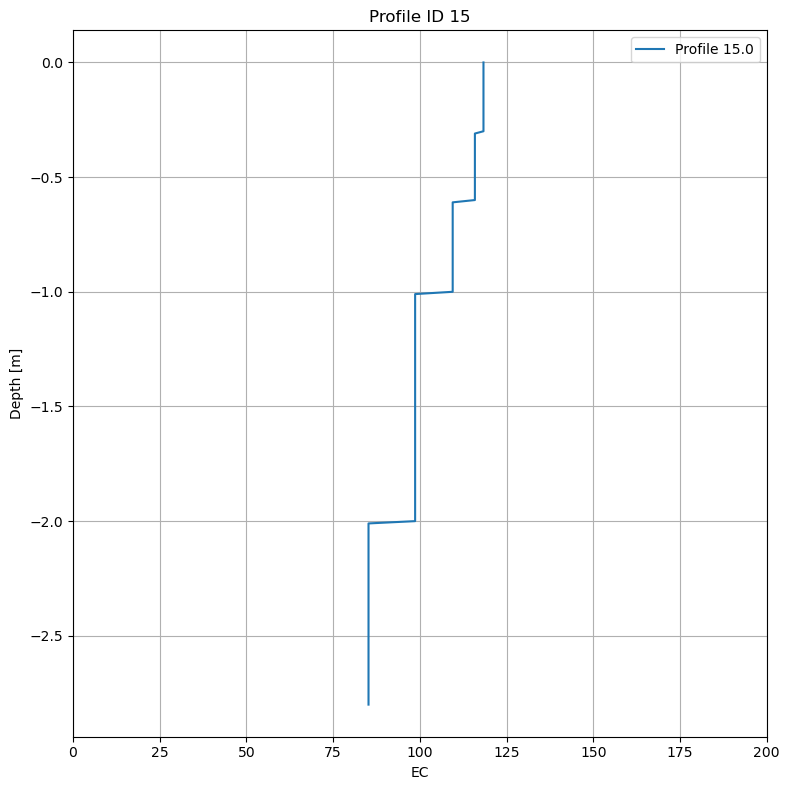

In [15]:
%autoreload
# Function to extract depth from column name
def extract_depth(col_name):
    if col_name.startswith('EC_'):
        return float(col_name.split('_')[1])
    return None

# Extracting depth values and sorting them
depth_cols = [col for col in ds_inv.columns if col.startswith('EC_')]
depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
depths.sort()

# Calculate depth for 'EC_end'
if depths:
    end_depth = depths[-1] + depths[0]
    depths.append(end_depth)

# Creating the new DataFrame
transformed_data = {
    'Z': [],
    'EC': [],
    'easting': [],
    'northing': [],
    'ID': []
}

# Populating the new DataFrame
for _, row in ds_inv.iterrows():
    for depth, depth_col in zip(depths, depth_cols):
        transformed_data['Z'].append(-depth)
        transformed_data['EC'].append(row[depth_col])
        transformed_data['easting'].append(row['x'])
        transformed_data['northing'].append(row['y'])
        transformed_data['ID'].append(row['pos'])

transformed_df = pd.DataFrame(transformed_data)

pdf_files = []
inv_meth = config['fs_emp']
for i in transformed_df['ID'].unique():
    profile_label = str(i)
    if '.0' in profile_label:
        profile_label = profile_label.split('.')[0]
    filename = plot_profile(transformed_df, i, 'EC', xlims=(0,200),
                 block=True,
                 save_plot = True, 
                 plot_name = f'{inv_meth}_inversion_p{profile_label}'
                 ) # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):
    
    pdf_files.append(filename)

# Merge and save PDFs
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)
merged_pdf_filename = f'{now}_{emfile_prefix}_{inv_meth}_samples.pdf'
outfile_samples_pdf = os.path.join(inv_folder, merged_pdf_filename)
merger.write(outfile_samples_pdf)
merger.close()
for pdf in pdf_files:
    os.remove(pdf)
clear_output(wait=False)

print(ds_inv.head())

In [16]:
filename = f"{now}_{emfile_prefix}_parameters_02.json"
filepath = os.path.join(inv_folder,filename)
file = open(filepath, 'w')

file.write('\t"input file + path": "{}",'.format(infile) + '\n\n')
file.write('\t"instrument": "{}",'.format(config['instrument_code'] ) + '\n')
file.write('\t"instrument mode": "{}",'.format(config['instrument_orientation']) + '\n')
file.write('\t"instrument height (m)": {:.3f},'.format(config['instrument_height']) + '\n')

if config['remove_coil']:
    rem_coils = instrument.cc_names[config['coil_n']]
    file.write('\t"configurations not used in inversion": "{}",'.format(rem_coils) + '\n\n')

file.write('\t"forward model": "{}",'.format(config['fs_emp']) + '\n')
file.write('\t"optimisation method":"{}",'.format(config['opt_method']) + '\n')
file.write('\t"regularisation": "{}",'.format(config['regularization']) + '\n')
file.write('\t"alpha parameter": "{}",'.format(alph_param) + '\n\n')
file.write('\t"reference EC profile":"{}",'.format(config['reference_profile']) + '\n')

if config['constrain']:
    file.write('\t "constrained inversion":' + '\n')
    if config['n_int']:
        file.write('\t"custom interface boundaries": "{}"\n'.format(config['interface']) + '\n')
    if config['custom_bounds']:
        file.write('\t"custom inversion constraints (bnds)": "{}" \n'.format(config['bounds']) + '\n')
    else:
        file.write('\t"automated inversion constraints (bnds)": "{}"\n'.format(bounds) + '\n')
file.close()